
### Directorio de trabajo



In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




*   Uso de R en python



In [ ]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

*   Librerías utilizadas

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.8 MB/s 
     |████████████████████████████████| 9.9 MB 31.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
!pip install statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 9.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 2.0.2 requires statsmodels>=0.13.2, but you have statsmodels 0.13.0 which is incompatible.


In [ ]:
# Tratamiento de datos
# ================================================================================
import pandas as pd
import numpy as np

# Gráficos
# ================================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ================================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# Configuración para las series
# ================================================================================
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm

import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats # prueba normalidad en residuos
from pmdarima.arima import auto_arima

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from pandas.core.frame import DataFrame
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración matplotlib
# ================================================================================
plt.rcParams['figure.figsize'] = 17, 8 # Dimensiones de los gráficos
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ================================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración No sé pero ahí estaba
# ================================================================================
from pandas.plotting import register_matplotlib_converters

# ***Concentración de material particulado inferior a 10 micras en Bogotá***

El material particulado inferior a 10 micras, denotado por PM10, consiste en materia sólida o líquida dispersa en el aire capaz de ingresar a la zona extratorácica y bronquial del ser humano, por lo que se considera un contaminante criterio. Su medida es necesaria para vigilar los niveles de contaminación en el aire, indagar en sus causas y establecer estrategias para su reducción.

Fuente: [IDEAM](http://www.ideam.gov.co/documents/11769/641368/V2.07+HM+Concentracion+PM10.pdf/77892937-1fe3-4188-9089-59abe56bd3c0#:~:text=El%20Material%20Particulado%20menor%20a,la%20atmósfera%20sobre%20amplias%20extensiones.)

## **Importación de datos**

La serie contiene información sobre la concentración promedio de PM10 en Bogotá por mes, medida desde diciembre de 2006  hasta junio de 2022, los datos son la suma de los promedios de cada estación de Bogotá con un 75% de representatividad.

In [ ]:
Cont = pd.read_csv('/content/drive/Shareddrives/Series/OAB-PM10PM.csv')
print(Cont)

     Periodo       Valor
0    2006-12   51.900002
1    2007-01   66.500000
2    2007-02  100.500000
3    2007-03   91.900002
4    2007-04   66.400002
..       ...         ...
182  2022-02   41.000000
183  2022-03   38.000000
184  2022-04   31.000000
185  2022-05   31.000000
186  2022-06   31.000000

[187 rows x 2 columns]


Periodo
2006-12-01     51.900002
2007-01-01     66.500000
2007-02-01    100.500000
2007-03-01     91.900002
2007-04-01     66.400002
                 ...    
2022-02-01     41.000000
2022-03-01     38.000000
2022-04-01     31.000000
2022-05-01     31.000000
2022-06-01     31.000000
Name: Valor, Length: 187, dtype: float64


Text(0.5, 1.0, 'Concentración de material particulado inferior a 10 micras')

Text(0, 0.5, '$\\mu g/m^3$')

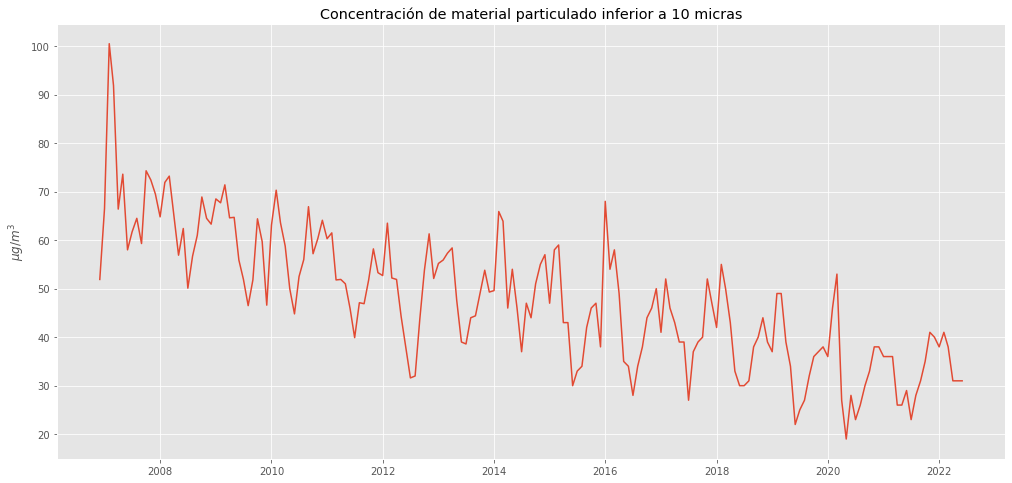

In [ ]:
Cont['Periodo']=pd.to_datetime(Cont['Periodo']) # pasar a formato fecha
Valores_cont=Cont.set_index('Periodo') # nuevo dataframe indexado por la fecha
cont_ts=Valores_cont['Valor'] # vector con los valores de la serie
print(cont_ts)

plt.plot(cont_ts)
plt.title('Concentración de material particulado inferior a 10 micras')
plt.ylabel('$\mu g/m^3$')
plt.show()

En el gráfico de la serie original se observa una tendencia decreciente y aparentemente lineal. Hay picos que sugieren un comportamiento repetitivo en el tiempo, posiblemente anual, pero con tamaños distintos, lo cual es un inicio de que la serie presenta varianza marginal no constante.

# **Análisis descriptivo**

## 1. Transformación de Box-Cox

En orden de corregir una posible heterocedasticidad marginal presente en la serie, se considera realizar una transformación de Box-Cox en la misma, la cual está dada por la siguiente fórmula.

\begin{equation}
	f_{\lambda}(u_{t})= \begin{cases}
		\lambda^{-1}(u^{\lambda}_{t}-1), &  \text{si  $u_{t} \geq 0$, para $\lambda>0$,}\\
		\ln(u_{t}), &\text{ si $u_{t}>0$, para $\lambda=0$}.
	\end{cases}
	\
\end{equation}

donde el $λ$ apropiado debe ser estimado, como se realiza a continuación.

In [ ]:
## Asignación de la frecuencia mensual
Valores_cont.index.freq='MS'
cont_ts.index.freq='MS'#ts.index

##### Comandos para la transformación Box-Cox
sp.stats.boxcox(Cont['Valor'],alpha=0.05)

(array([10.462367  , 11.90972552, 14.69424248, 14.04809695, 11.90046172,
        12.5483263 , 11.09203261, 11.45579229, 11.72292156, 11.22129999,
        12.60935985, 12.44292786, 12.18405421, 11.75114947, 12.39871939,
        12.51330251, 11.76992693, 10.98136352, 11.52320829, 10.26861708,
        10.96111191, 11.38794112, 12.12973366, 11.72292156, 11.60925913,
        12.09337083, 12.02028232, 12.35433642, 11.73233912, 11.74174841,
        10.87969785, 10.46236684,  9.86891832, 10.45170385, 11.71349572,
        11.26075089,  9.88025347, 11.59019697, 12.25606968, 11.63778847,
        11.1717738 , 10.25773835,  9.67406615, 10.52610154, 10.88991057,
        11.94670253, 11.01166541, 11.31964717, 11.68516832, 11.3196471 ,
        11.43645092, 10.45170377, 10.462367  , 10.36597658,  9.80061556,
         9.08776628,  9.93672324,  9.91417659, 10.45170385, 11.11202606,
        10.61044212, 10.54725461, 11.62828718, 10.49428611, 10.46236684,
         9.61596142,  8.83674958,  7.992878  ,  8.0

El $λ$ estimado es de 0.433 y su intervalo de confianza no incluye al 1, por lo que se hace necesario aplicar la transformación con la estimación puntual de $λ$.

Text(0.5, 1.0, 'Serie con Tranformación Box-Cox (lambda=0.433)')

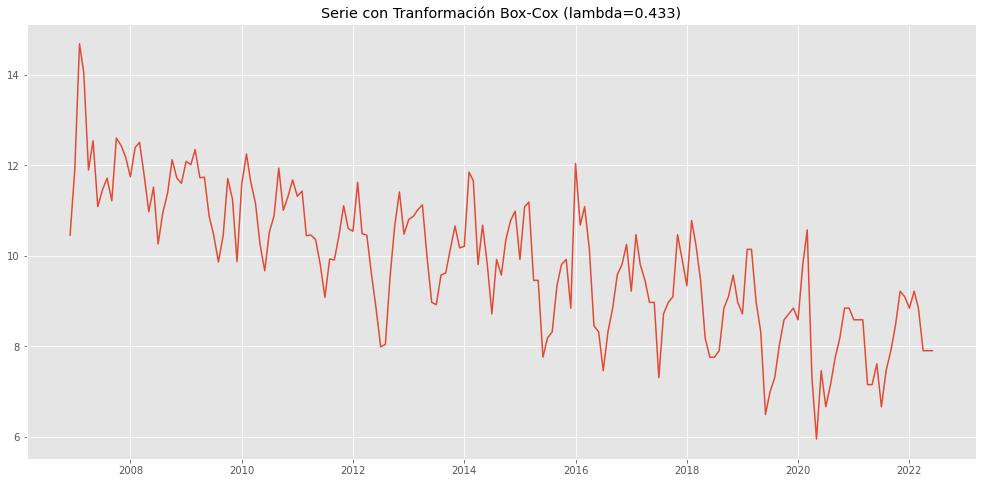

In [ ]:
rCont=sp.stats.boxcox(Cont['Valor'],lmbda=0.433)
Cont = Cont.assign(rCont=rCont) # al dataframe original le añadimos los valores de la transformación

rValor=Cont.set_index('Periodo')  # Otro dataframe con el índice de la fecha
rContV= rValor['rCont'] # la serie de la transformación guardada en el dataframe anterior
plt.plot(rContV)
plt.title('Serie con Tranformación Box-Cox (lambda=0.433)')
plt.show()

Se observa una menor acentuación en los picos más grandes, haciendo que todos se vean más similares en tamaño y permitiendo explorar mejor otro tipo de comportamientos.


Ahora, se estima nuevamente un $λ$ para la serie ya transformada para verificar si es o no necesaria otra transformación de Box-Cox.

In [ ]:
sp.stats.boxcox(rValor['rCont'],alpha=0.05)

(array([ 9.30839143, 10.72024893, 13.43165238, 12.80298557, 10.71121822,
        11.34261013,  9.92284469, 10.27765099, 10.53813114, 10.0489439 ,
        11.40207424, 11.23991491, 10.98764256, 10.56565283, 11.19683762,
        11.30848561, 10.58396014,  9.81487593, 10.34339479,  9.11924675,
         9.79511726, 10.2114788 , 10.93470021, 10.53813114, 10.42730545,
        10.8992586 , 10.8280184 , 11.15358871, 10.54731316, 10.55648705,
         9.71568103,  9.30839128,  8.72893141,  9.29798268, 10.52894098,
        10.08742491,  8.74000267, 10.40871794, 11.05782712, 10.45512381,
        10.0006333 ,  9.10862551,  8.53859498,  9.37060315,  9.72564598,
        10.75629482,  9.84443956, 10.14487067, 10.50132137, 10.1448706 ,
        10.25878864,  9.2979826 ,  9.30839143,  9.21429666,  8.66221603,
         7.96564114,  8.79515583,  8.77313524,  9.29798268,  9.94234912,
         9.45292259,  9.39124994, 10.44585938,  9.33954837,  9.30839128,
         8.48182923,  7.72022332,  6.89463509,  6.9

La nueva estimación es aproximadamente de 1, y 1 pertenece al intervalo de confianza, por lo que se considera que la varianza ya está estabilizada y se continua el análisis con la serie transformada.

### ***Gráficos de dispersión con los retardos***



Una vez transformada la serie se realizan los gráficos de dispersión de la variable $X_t$ con sus retardos para darnos una idea de un posible comportamiento cíclico en el nivel de PM10 en Bogotá.

<Figure size 1224x576 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

Text(0.5, 1.0, 't vs t-2')

Text(0.5, 1.0, 't vs t-3')

Text(0.5, 1.0, 't vs t-4')

Text(0.5, 1.0, 't vs t-5')

Text(0.5, 1.0, 't vs t-6')

Text(0.5, 1.0, 't vs t-7')

Text(0.5, 1.0, 't vs t-8')

Text(0.5, 1.0, 't vs t-9')

Text(0.5, 1.0, 't vs t-10')

Text(0.5, 1.0, 't vs t-11')

Text(0.5, 1.0, 't vs t-12')

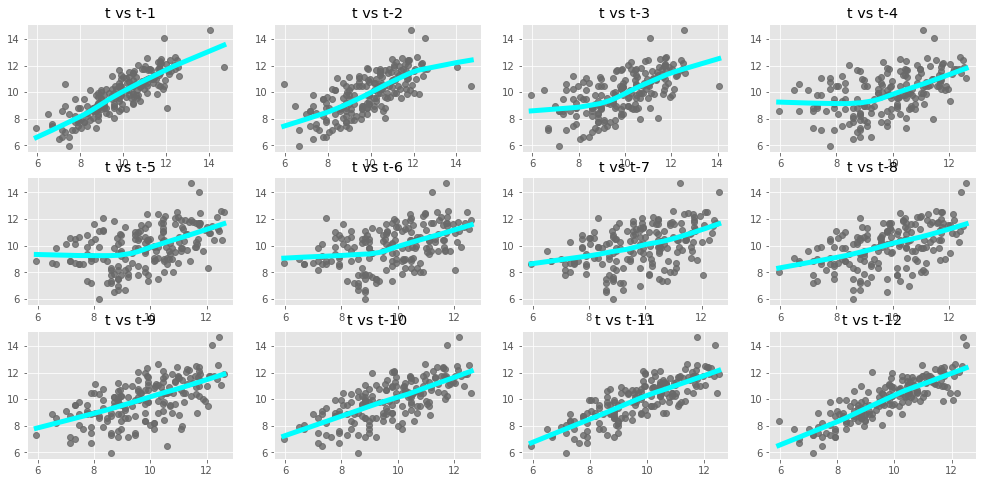

In [ ]:
from matplotlib.pyplot import rc
import seaborn as sns
# Análisis de retardos con transformación boxcox
from pandas.plotting import scatter_matrix
values = pd.DataFrame(rContV)
lags = 12
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(3,4, i)
	ax.set_title('t vs t-' + str(i))
	sns.regplot(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values,color="dimgray",lowess=True,
            line_kws={"color":"cyan", "linewidth":5}, label=f'Plot')
plt.show()

Se observa una correlación lineal considerable con los 12 retardos, lo cual puede estar ocasionado por la tendencia de la serie.

### ***Gráfico de autocorrelación***

De la misma manera, se realiza el gráfico de autocorrelación de la serie transformada para verificar la presencia de tendencia y estacionalidad en la misma.

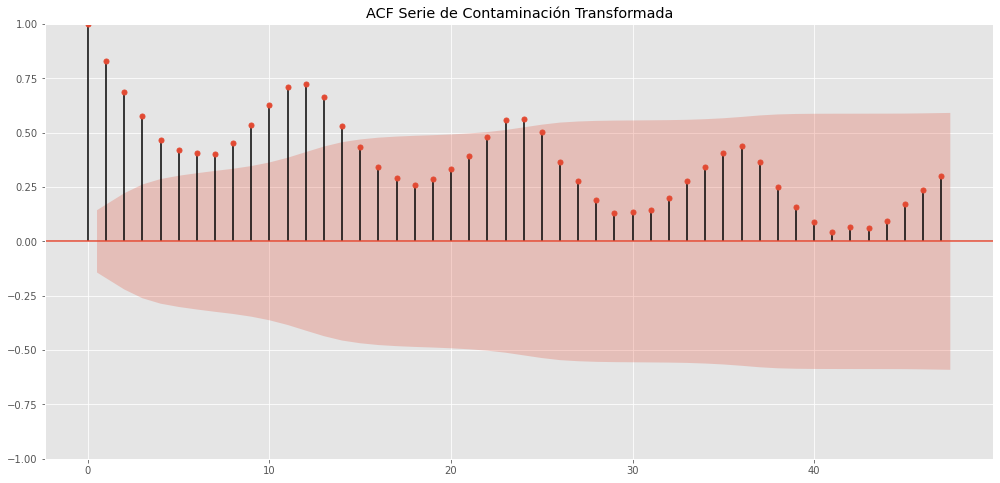

In [ ]:
plt.rcParams['figure.figsize'] = 17, 8
acf_box=plot_acf(rContV,adjusted=False,lags=47,title='ACF Serie de Contaminación Transformada')
plt.show(acf_box)

Dada la cantidad de rezagos con una autocorrelación distinta de cero (16), se ve que esta correlación se acerca a 0 lentamente, evidenciando la presencia de tendencia en la serie. Por otro lado, la gráfica muestra un claro comportamiento estacional, la cual se va a estudiar luego de eliminar la tendencia para poder realizar una interpretación correcta.

## 2. Descomposición por promedios móviles

Para estimar la componente de tendencia de la serie y debido a que esta ya se visualizó, se realiza una descomposición por promedios móviles, en donde se considera un modelo aditivo, es decir, $X_t=m_t+S_t+Y_t$ , y se utiliza un filtro de promedios móviles para la estimación de la componente de tendencia y estacional de la siguiente manera:
$$\begin{align*}
\text{Promedio móvil: }  & W_{t}=(2q+1)^{-1}\sum_{j=-q}^{q}X_{t-j}\\
\text{Tendencia estimada: } & \hat{m}_t = (0.5x_{t-q}+x_{t-q+1}+⋯+x_{t+q-1}+0.5x_{t+q})/d \hspace{0.3cm} \text { para } q \leq t \leq n-q \text{ y } d=2q\\
\text{C. estacional estimada:  } & \hat{S}_k=w_k-d^{-1}\sum_{j=1}^{d} w_j \hspace{0.5cm} \text { con } k=1,\cdots, d \text{ y } \hat{S}_k=\hat{S}_{k+d} \text{ para } k>d \\
\text{donde } w_k &\text{ es el promedio de las desviaciones } \{(x_{k+jd}-\hat{m}_{k+jd}), q < k+dj \leq n-q \}
\end{align*}$$  

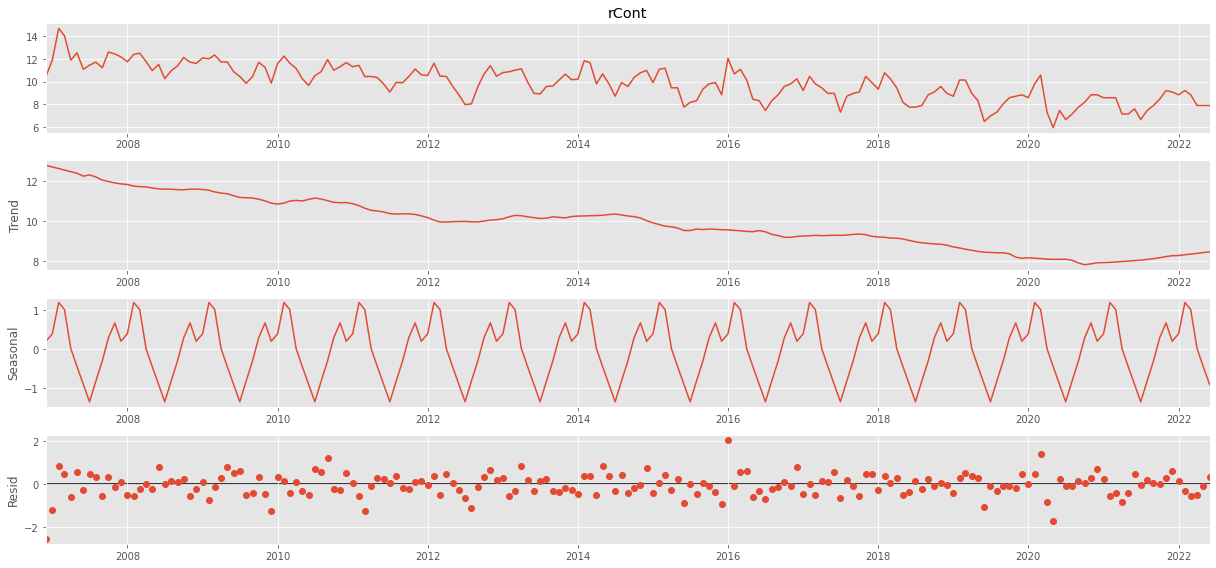

In [ ]:
####Descomposición usando promedos móviles
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

result = seasonal_decompose(rContV, model='additive',extrapolate_trend=6)
descomposicion_Cont=result.plot()
pyplot.show()

### ***Eliminación de la tendencia***

Por medio de esta estimación, se elimina la tendencia de la serie para poder estudiar de manera apropiada la estacionalidad.

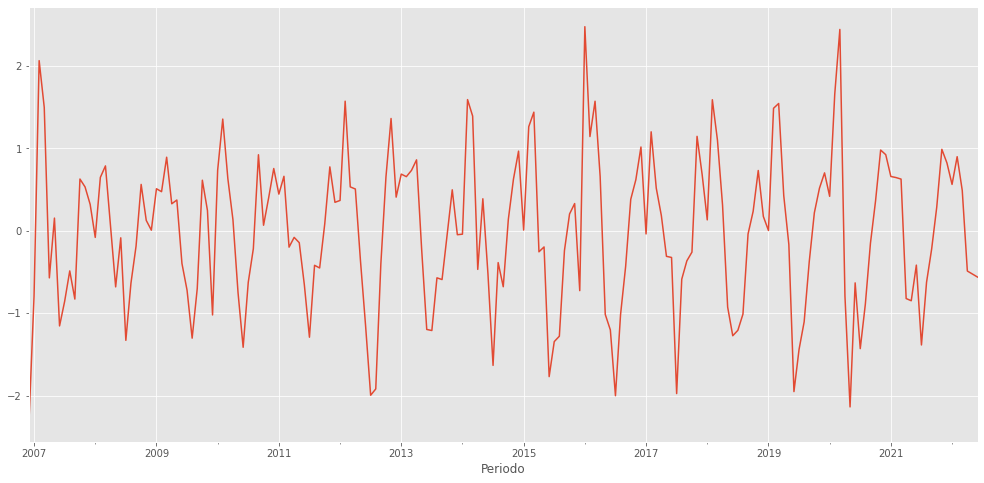

In [ ]:
# Serie sin la tendencia de promedios
Conta_sin_tend = rContV - result.trend
Conta_sin_tend.plot()

### ***Gráfico de autocorrelación***

Nuevamente, se realiza el gráfico de autocorrelación sobre la serie trasformada y sin tendencia.

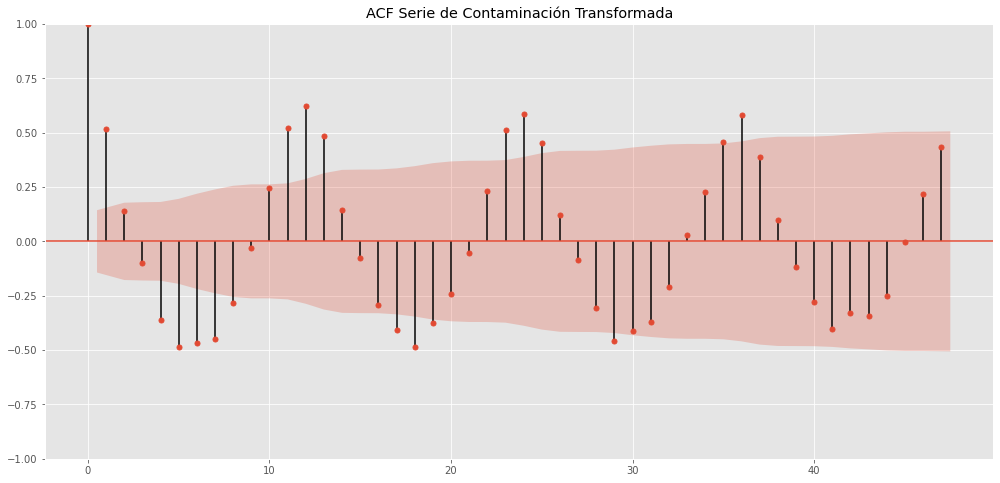

In [ ]:
acf_tend =plot_acf(Conta_sin_tend,unbiased=False,lags=47,title='ACF Serie de Contaminación Transformada')
plt.show(acf_tend)

En el gráfico se aprecia que la autocorrelación de los retardos disminuyó en general por el efecto de eliminar la tendencia y se observa una clara componente estacional de periodo 12, pues en el rezago 12 se maximiza la autocorrelación y desde este retardo se repite el comportamiento.

## 3. Análisis de ciclos estacionales

Habiendo eliminado la tendencia de la serie, se procede con el análisis de la estacionalidad en la misma.

### ***Gráficos de retardos sin tendencia***

<Figure size 1224x576 with 0 Axes>

Text(0.5, 1.0, 't vs t-1')

Text(0.5, 1.0, 't vs t-2')

Text(0.5, 1.0, 't vs t-3')

Text(0.5, 1.0, 't vs t-4')

Text(0.5, 1.0, 't vs t-5')

Text(0.5, 1.0, 't vs t-6')

Text(0.5, 1.0, 't vs t-7')

Text(0.5, 1.0, 't vs t-8')

Text(0.5, 1.0, 't vs t-9')

Text(0.5, 1.0, 't vs t-10')

Text(0.5, 1.0, 't vs t-11')

Text(0.5, 1.0, 't vs t-12')

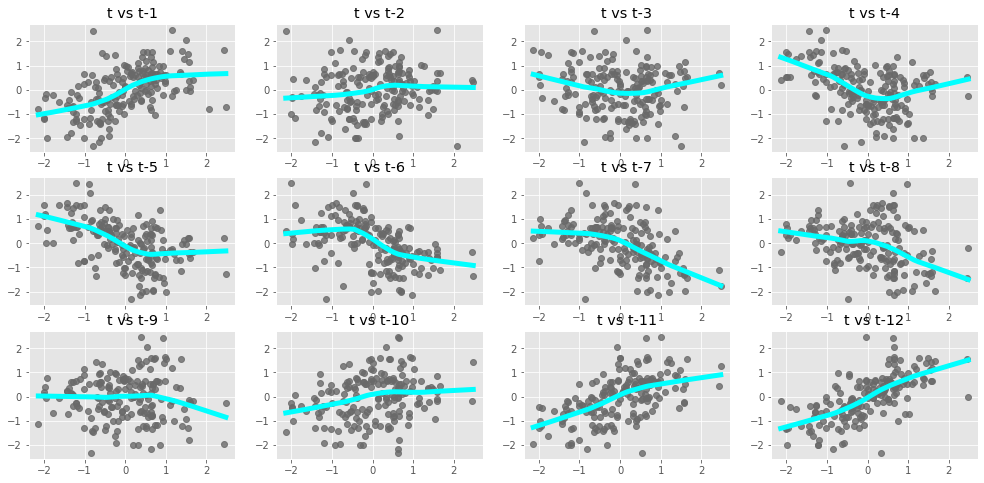

In [ ]:
from matplotlib.pyplot import rc
import seaborn as sns
# Análisis de retardos con transformación boxcox
from pandas.plotting import scatter_matrix
values = pd.DataFrame(Conta_sin_tend)
lags = 12
columns = [values]
for i in range(1,(lags + 1)):
	columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
	columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
	ax = plt.subplot(3,4, i)
	ax.set_title('t vs t-' + str(i))
	sns.regplot(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values,color="dimgray",lowess=True,
            line_kws={"color":"cyan", "linewidth":5})
plt.show()

La correlación con los retardos disminuyó considerablemente en contraste con los gráficos de la serie con la tendencia. Para el rezago 12 se observa la correlación lineal más clara, lo cual apoya la idea de una componente estacional de periodo 12.

### ***Gráfico de subseries por mes***

En este sentido, se realiza el gráfico de las subseries para observar el comportamiento de los niveles de PM10 por mes.

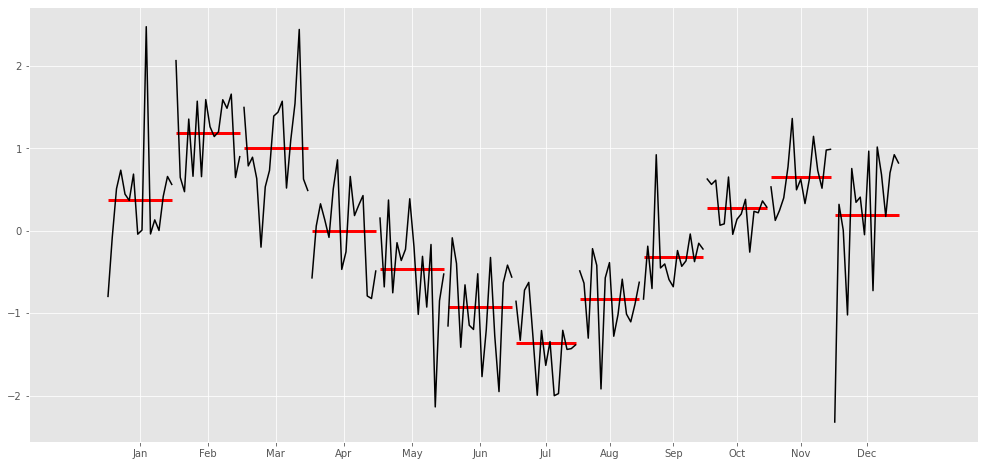

In [ ]:
meses=sm.graphics.tsa.month_plot(Conta_sin_tend)
plt.show(meses)

Es claro que las medias de cada mes no oscilan alrededor del mismo valor, además podemos observar que las medidas toman sus valores máximos en febrero y van disminuyendo hasta julio para después volver a aumentar.

Este comportamiento evidencia la estacionalidad de la serie y se muestra en el cálculo de los promedios por mes presentados a continuación.

### ***Medias por mes***

In [ ]:
#Idexación de la base por mes
d = {'valCont': Conta_sin_tend.values, 'fecha': Conta_sin_tend.index,'año':Conta_sin_tend.index.year,'mes':Conta_sin_tend.index.month_name()}
df_conta = pd.DataFrame(data=d)
df_conta
d1 = {'valCont': Conta_sin_tend.values, 'fecha': Conta_sin_tend.index,'año':Conta_sin_tend.index.year,'mes':Conta_sin_tend.index.month}
df_conta1 = pd.DataFrame(data=d1)

valCont      fecha   año       mes
0   -2.321529 2006-12-01  2006  December
1   -0.796635 2007-01-01  2007   January
2    2.064890 2007-02-01  2007  February
3    1.497010 2007-03-01  2007     March
4   -0.571830 2007-04-01  2007     April
..        ...        ...   ...       ...
182  0.899255 2022-02-01  2022  February
183  0.489415 2022-03-01  2022     March
184 -0.488721 2022-04-01  2022     April
185 -0.525359 2022-05-01  2022       May
186 -0.561998 2022-06-01  2022      June

[187 rows x 4 columns]

In [ ]:
#Cálculo de las medias para cada mes
mediaspormes=df_conta[['valCont','mes']].groupby(df_conta['mes']).mean()
nuevo={'Contaminaciónprom': mediaspormes['valCont'].values,'mes':mediaspormes.index}
df_mediaspormes=pd.DataFrame(data=nuevo)
df_mediaspormes

Contaminaciónprom        mes
0           -0.000672      April
1           -0.830618     August
2            0.187915   December
3            1.182189   February
4            0.378087    January
5           -1.363721       July
6           -0.919408       June
7            1.000218      March
8           -0.461053        May
9            0.658543   November
10           0.275621    October
11          -0.316243  September

### ***Gráficos de caja por mes***

Además, se muestran los boxplot por mes para visualizar más claramente cómo cambia el comportamiento de los valores de PM10 en Bogotá para cada uno.

<Figure size 1152x396 with 0 Axes>

Text(0.5, 1.0, 'Box Plot contaminación por meses')

Text(0.5, 0, 'Mes')

Text(0, 0.5, 'Micras promedio de contaminación')

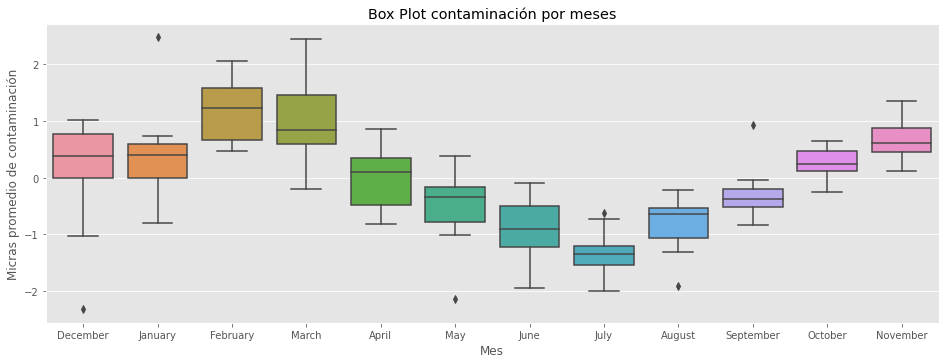

In [ ]:
plt.figure(figsize=(16, 5.5))
g = sns.boxplot(data=df_conta, y='valCont', x='mes')
g.set_title('Box Plot contaminación por meses')
g.set_xlabel('Mes')
g.set_ylabel('Micras promedio de contaminación')

Teniendo en cuenta que el PM10 puede proceder de distintas fuentes, ya sean naturales u ocasionadas por actividad humana, como los son las erupciones volcánicas, los incendios forestales, la quema de combustibles sólidos, actividad agrícola, uso de por transporte automotor, entre otras, se asocian los valores bajos de PM10 en Bogotá hacia mitad del año por el periodo de vacaciones en instituciones educativas, en el que muchas personas salen de la cuidad, reduciendo el tránsito de automóviles. De igual manera, los valores altos en los primeros y los últimos meses de año puede estar relacionado con el regreso y transporte a dichas instituciones, el transporte al trabajo (puesto que son los meses con mayores cifras de empleabilidad) y la salida y llegada de aviones para fechas de navidad.

### ***Mapa de calor***

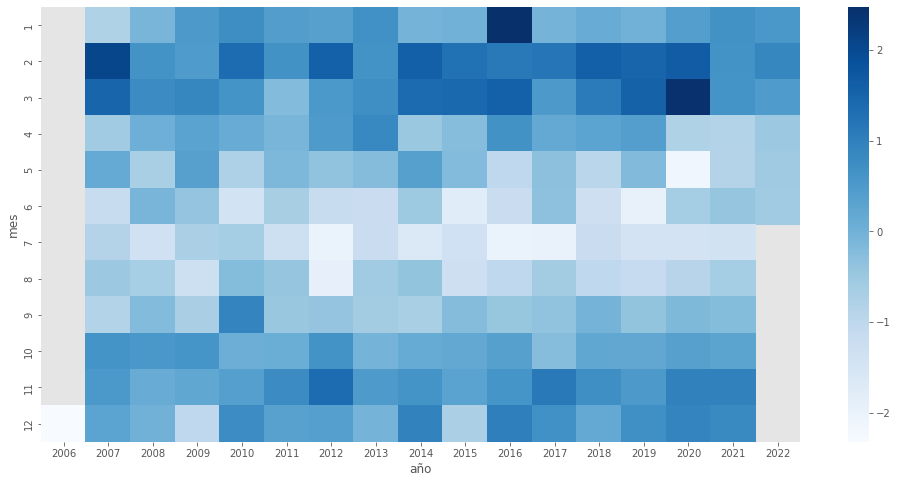

In [ ]:
df_nuevo_pivot = df_conta1.pivot("mes","año", "valCont")
ax = sns.heatmap(df_nuevo_pivot,cmap="Blues")

El mapa de calor muestra el comportamiento antes mencionado y un valor máximo en enero de 2016, el cual también se observa en el gráfico de las subseries, además de que los colores en 2014 y 2010 son ligeramente más intensos que los de los años contiguos. Esto va de la mano con las cifras de incendios forestales en Bogotá, que, según datos de distrito, ocurren sobre todo en los primeros meses del año, por el aumento de la temperatura y la incidencia del fenómeno del niño, y se dieron con mayor frecuencia en el 2016, 2014 y 2010 respectivamente.

Por otro lado, el valor más bajo se da en mayo de 2020, cosa que puede estar explicada por el efecto de la cuarentena debida al Covid-19, la cual redujo considerablemente el transporte y la quema de combustibles en Bogotá.

### **Periodograma**

16
0.0855614973262032


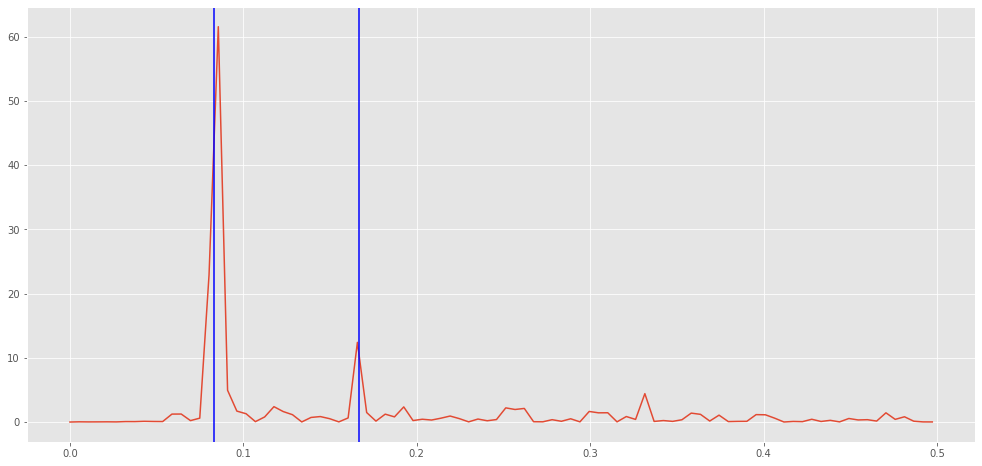

In [ ]:
f, Pxx_conta=sp.signal.periodogram(Conta_sin_tend)
plt.plot(f, Pxx_conta)
max_index_value_Cont = np.argmax(Pxx_conta, axis=0)
print(max_index_value_Cont)
frecuencia_max_Cont=f[max_index_value_Cont]
print(frecuencia_max_Cont)
plt.axvline(x=1/12,color='blue')
plt.axvline(x=2/12,color='blue')

En el periodograma se observa que la frecuencia que lo maximiza corresponde a la que respecta a un cico anual $(\frac{1}{12})$, lo cual corrobora la idea de una estacionalidad de periodo 12.

#  **Modelamiento**


## 4. Ajuste y diagnóstico de los modelos

Una vez realizado el análisis descriptivo de la serie, se da inicio al modelamiento de la misma. Este se hará por medio de 3 modelos:


*   Suavizamiento exponencial
*   Modelo ARMA con series de Fourier
*   Modelo ARMA con variables Dummy

Estos modelos serán contrastados con base en su capacidad predictiva para seleccionar el mejor y realizar preddiciones con él acerca del nivel medio de PM10 en Bogotá por mes para fechas posteriores a junio de 2022.

### *Conjunto de entrenamiento y prueba para modelos que no tienen hiperparámetros*.

Para el modelo hechos por medio de suavizamiento exponencial se divide la base en los conjuntos de entrenamiento (90% de los datos), el cual oscila entre diciembre del 2006 y noviembre del 2020, y prueba (10% restante) que corresponde al resto de meses en la serie de tiempo.

In [ ]:
train_weight = 0.9
split = int(len(rContV) * train_weight)

df_train = rContV.iloc[:split]
df_test = rContV.iloc[split:]

## 4.1 Suavizamiento Exponencial

En el modelo por medio de suavizamiento exponencial también se considera una descomposición de la serie de forma aditiva. Las componentes de tenendecia y la estacionalidad se estiman por medio de una estadística EWMA (promedio movil ponderado exponencialmente), dándole más peso a las observaciones más cercanas en cada tiempo.

Además, para este caso, se descompone la componente de tendencia en nivel y pendiente, y se estima un parámetro de la componente estacional por mes, como lo indica el periodo hallado de 12.  Las estimaciones se hallan de la siguiente manera:


$$\begin{align*}
\text{Componente de nivel: } & a_t=α(x_t-S_{t-p})+(1−α)(a_{t−1}+b_{t−1})\\
\text{Componente de pendiente: } & b_t=β(a_t−a_{t−1})+(1−β)b_{t−1} \\
\text{Componente estacional: } & S_t=\gamma(x_t−a_t)+(1−γ)S_{t−p} \\
\end{align*}$$

Se observa que

name         param  optimized
smoothing_level     alpha  8.441086e-02       True
smoothing_trend      beta  0.000000e+00       True
smoothing_seasonal  gamma  5.751153e-14       True
initial_level         l.0  1.219807e+01       True
initial_trend         b.0 -2.495733e-02       True
initial_seasons.0     s.0  1.176702e-01       True
initial_seasons.1     s.1  3.668489e-01       True
initial_seasons.2     s.2  1.254261e+00       True
initial_seasons.3     s.3  1.072428e+00       True
initial_seasons.4     s.4  9.796596e-02       True
initial_seasons.5     s.5 -4.281216e-01       True
initial_seasons.6     s.6 -9.863785e-01       True
initial_seasons.7     s.7 -1.357425e+00       True
initial_seasons.8     s.8 -8.437117e-01       True
initial_seasons.9     s.9 -3.308777e-01       True
initial_seasons.10   s.10  2.615504e-01       True
initial_seasons.11   s.11  6.165475e-01       True

Text(0, 0.5, 'Raíz de\n contaminación')

Text(0, 0.5, 'nivel')

Text(0, 0.5, 'slope')

Text(0, 0.5, 'season')

Text(0, 0.5, 'residuales')

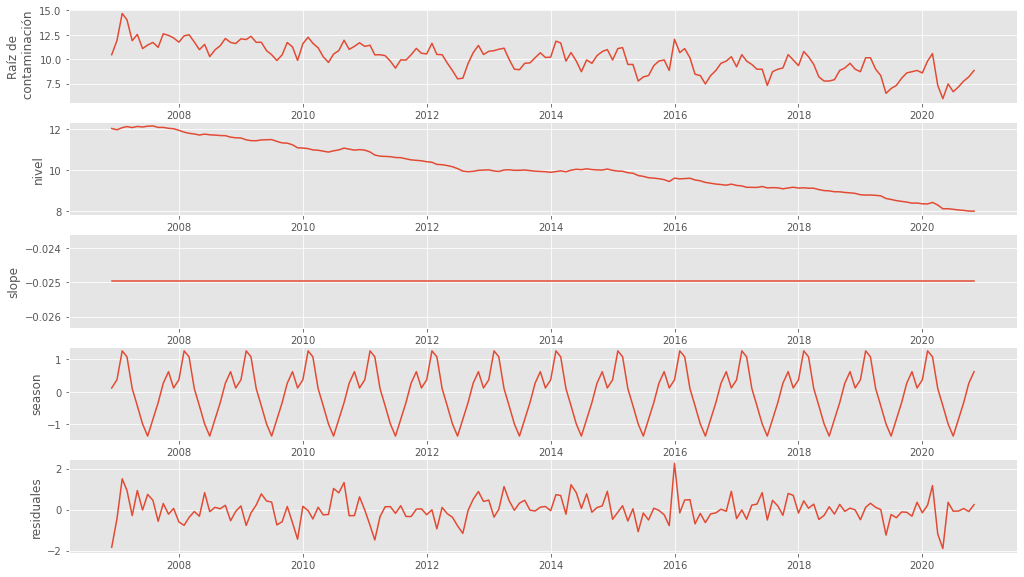

In [ ]:
fit1 = ExponentialSmoothing(df_train, seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated",use_boxcox=False).fit()

fit1.params_formatted

with plt.rc_context({'figure.figsize': (17,10)}):
 plt.subplot(5, 1, 1)
 plt.plot(df_train)
 plt.ylabel('Raíz de\n contaminación')
 plt.subplot(5, 1, 2)
 plt.plot(fit1.level)
 plt.ylabel('nivel')
 plt.subplot(5, 1, 3)
 plt.plot(fit1.trend)
 plt.ylabel('slope')
 plt.subplot(5, 1, 4)
 plt.plot(fit1.season)
 plt.ylabel('season')
 plt.subplot(5, 1, 5)
 plt.plot(fit1.resid)
 plt.ylabel('residuales') # estos residuales son quitando estacionalidad también


## 4.1.1 Análisis de Residuos para Suavizamiento

Al eliminar las componentes de tendecia y estacional estimadas por el suavizamiento exponencial, se obtienen los siguientes residuales

***Gráfico de los residuales***

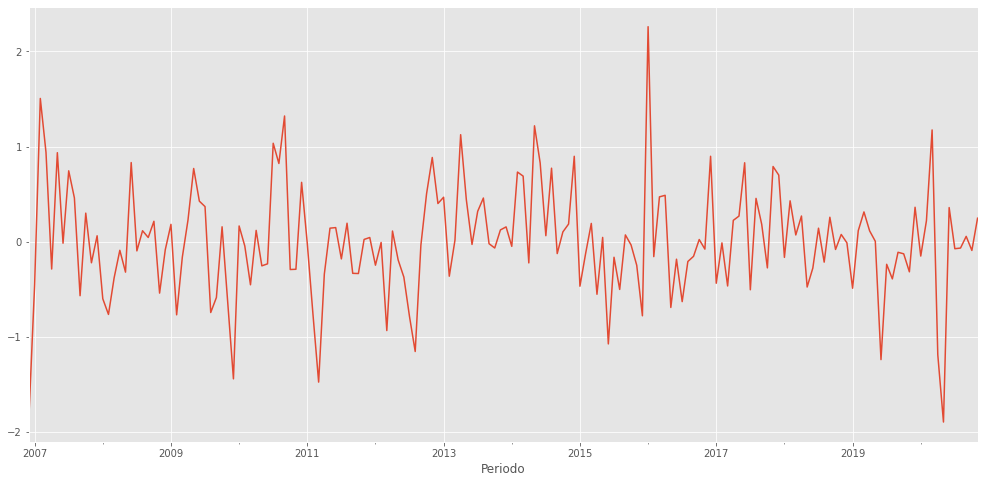

In [ ]:
residuos_exp = fit1.resid
residuos_exp.plot()

***Gráfico de autocorrelación de los residuales***

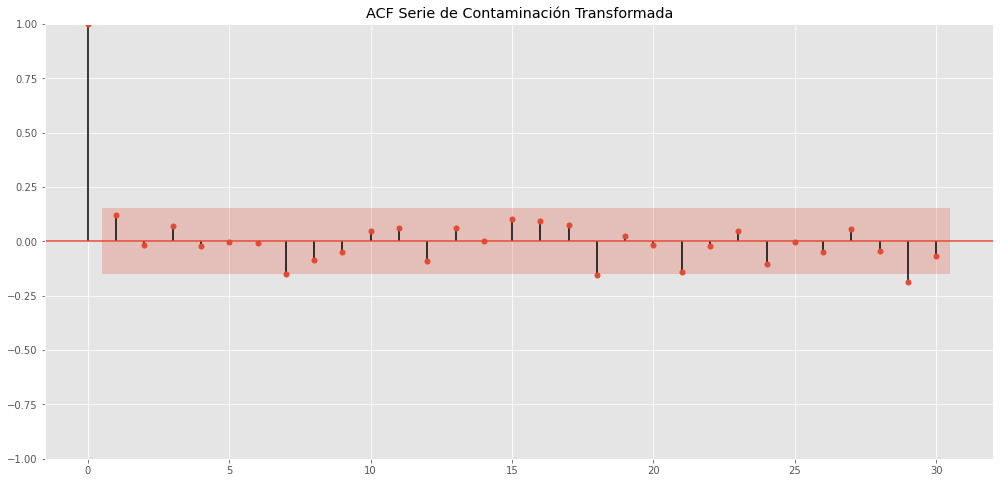

In [ ]:
acf_exp = plot_acf(residuos_exp,unbiased=False,lags=30,bartlett_confint=False,title='ACF Serie de Contaminación Transformada')
plt.show(acf_exp) # bandas para ruido blanco con bartlett = F

***Prueba de autocorrelación global cero***

In [ ]:
len(residuos_exp)/4 #42
np.sqrt(len(residuos_exp)) #12
sm.stats.acorr_ljungbox(residuos_exp, lags=[24],return_df=True)

42.0

12.96148139681572

lb_stat  lb_pvalue
24  28.446798   0.241647

El valor p obtenido es 0.2851 > 0.05, por lo que no se rechaza la hipótesis de no correlación.

## 4.2. Modelamiento ARMA

Ahora se buscará ajustar modelos ARMA a la serie de tiempo sin la tendencia estimada por medio de la descomposición de promedios móviles, puesto que para hacer modelamiento a través de procesos ARMA se requiere que la serie sea estacionaria.

### Conjunto de entrenamiento, validación y prueba para modelos con hiperparámetros

Dado que ya no se está usando la serie con la transformación de BoxCox y como este tipo de modelos requieren la estimación de hiperparámetros como $p$ y $q$, órdenes de los polinomios autoregresivos y de promedio móviles respectivamente, se requiere hacer una nueva división del conjunto de datos para poder realizar rolling y determinar el mejor modelo ARMA de los que se van a estudiar.

Para esto, el nuevo conjunto de entrenamiento corresponderá al 80% de los datos, es decir, hasta la fecha de abril del año 2019, se tiene que el conjunto de validación corresponderá al siguiente 10%. hasta la fecha de noviembre de 2020 y por último el 10% restante corresponderá al conjunto de prueba.


In [ ]:
train_weight2 = 0.8
split2 = int(len(Conta_sin_tend) * train_weight2)
split3 = int((len(Conta_sin_tend) - split2)/2) + split2

df_train2 = Conta_sin_tend.iloc[:split2]
df_valid = Conta_sin_tend.iloc[split2:split3]
df_test2 = Conta_sin_tend.iloc[split3:]

## 4.2.1 Modelamiento estacionalidad con Fourier

Con el fin de obtener una serie estacionaria a la cual se le puedan ajustar modelos ARMA, además de haber eliminado la tendencia se necesita también eliminar la componente estacional que se encontró en el análisis descriptivo. Para esto se estimará la componente estacional por medio de dos procedimientos diferentes para restarsela a los datos.

El primer modelo para la componente estacional se hará por medio de la expansión en series de Fourier dado que se aprecia que la componente estacional sigue un comportamiento determinístico y posiblemente sinosoidal. Así, el modelo es:

$$\begin{align*}
x_t&=  ∑_{i=1}^k a_icos(k𝜔t)+b_isen(k𝜔t) + w_t \\
\end{align*}$$

donde $k$ corresponderá al orden de la expansión en series de Fourier y los coeficientes $a_i$ y $b_i$ con $i=1,...,k$ serán estimados a través del método de mínimos cuadrados. El ca´lculo de esta componente se muestra a continuación considerando un orden $k=3$  

Text(0.5, 0, 'Time [h]')

Text(0.5, 1.0, 'Time of year signal')

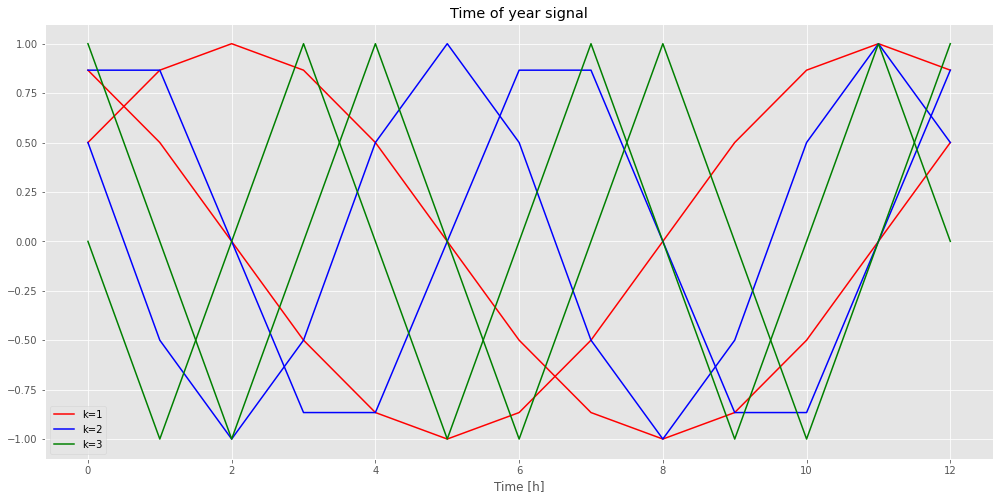

In [ ]:
#timesPas_s = np.arange(1,187)
year = 1/(1/12)
Cont2 = pd.DataFrame(df_train2)

#Fourier n=1 2pi*1
Cont2['Year sin'] = np.sin(np.arange(1,150)*(2 * np.pi / year))
Cont2['Year cos'] = np.cos(np.arange(1,150)*(2 * np.pi / year))

# Fourier n=2 2pi*2
Cont2['Year sin2'] = np.sin(np.arange(1,150)*(4 * np.pi / year))
Cont2['Year cos2'] = np.cos(np.arange(1,150)*(4 * np.pi / year))

# Fourier n=3 2pi*3
Cont2['Year sin3'] = np.sin(np.arange(1,150)*(6 * np.pi / year))
Cont2['Year cos3'] = np.cos(np.arange(1,150)*(6 * np.pi / year))

plt.plot(np.array(Cont2['Year sin'])[:13], color="red", label="k=1")
plt.plot(np.array(Cont2['Year cos'])[:13], color="red")

plt.plot(np.array(Cont2['Year sin2'])[:13], color="blue", label="k=2")
plt.plot(np.array(Cont2['Year cos2'])[:13], color="blue")

plt.plot(np.array(Cont2['Year sin3'])[:13], color="green", label="k=3")
plt.plot(np.array(Cont2['Year cos3'])[:13], color="green")

plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.legend()

In [ ]:
X=np.column_stack((Cont2['Year cos'],Cont2['Year sin'],Cont2['Year cos2'],Cont2['Year sin2'],Cont2['Year cos3'],Cont2['Year sin3']))
linmodel_ciclo = sm.OLS(df_train2, X)
results_ciclo = linmodel_ciclo.fit()
print(results_ciclo.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.642
Model:                            OLS   Adj. R-squared (uncentered):              0.627
Method:                 Least Squares   F-statistic:                              42.75
Date:                Thu, 01 Dec 2022   Prob (F-statistic):                    1.40e-29
Time:                        14:32:16   Log-Likelihood:                         -119.80
No. Observations:                 149   AIC:                                      251.6
Df Residuals:                     143   BIC:                                      269.6
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Una vez obtenidos los coeficientes que acompañan las funciones sinosoidales, procedemos a predecir los valores de la componente estacional como sigue

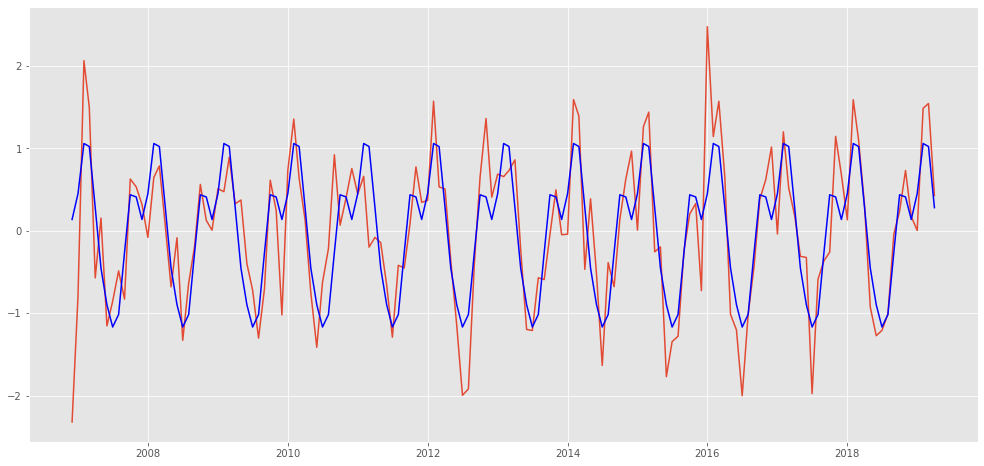

In [ ]:
ypred = results_ciclo.predict(X)
Cont2["predict estacion"] = ypred
plt.plot(df_train2)
plt.plot(Cont2["predict estacion"], color="blue")
plt.show()

Finalmente, la serie estacionaria resultante de restar la componente de tendencia y la componente estacional es la siguiente.

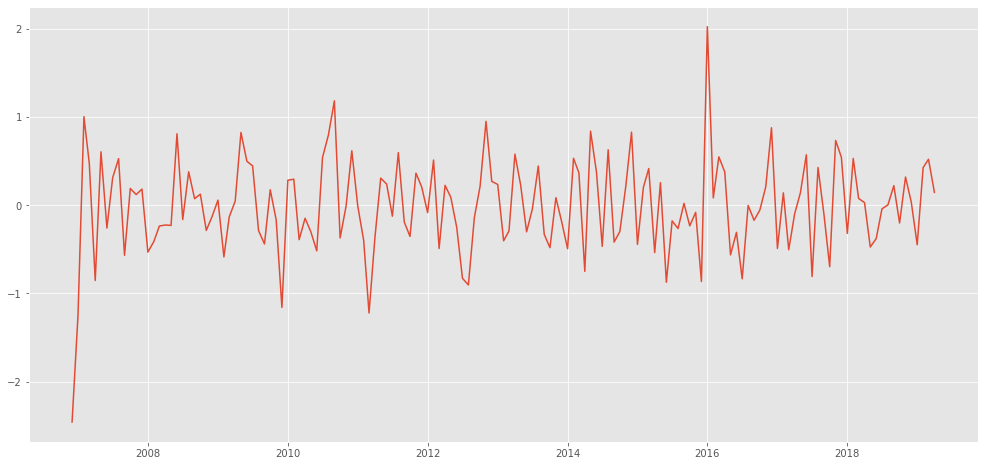

In [ ]:
# Serie sin tendencia ni estacionalidad
Conta_mod=df_train2-ypred
plt.plot(Conta_mod)

Sobre esta serie podemos crear los gráficos de autocorrelación simple y autocorrelación parcial, para determinar los máximos ordenes que se pueden considerar para los polinomios del modelo.

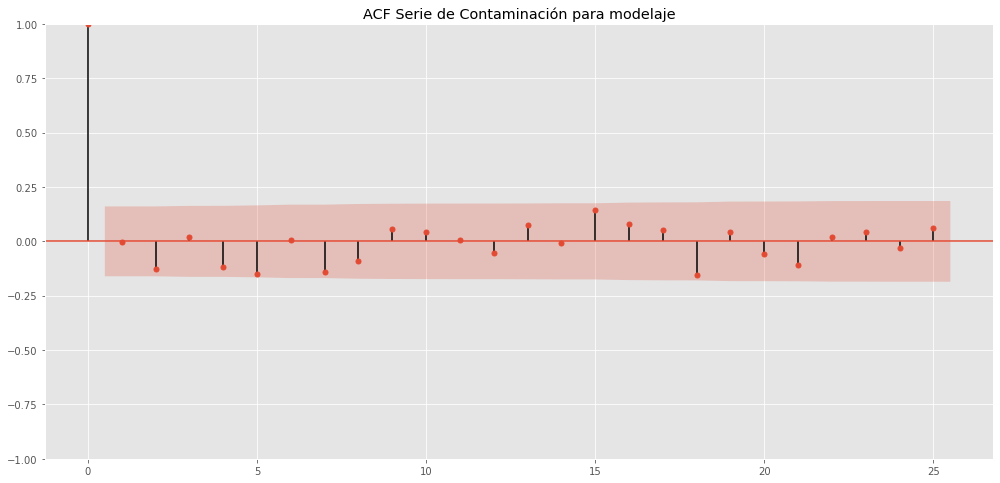

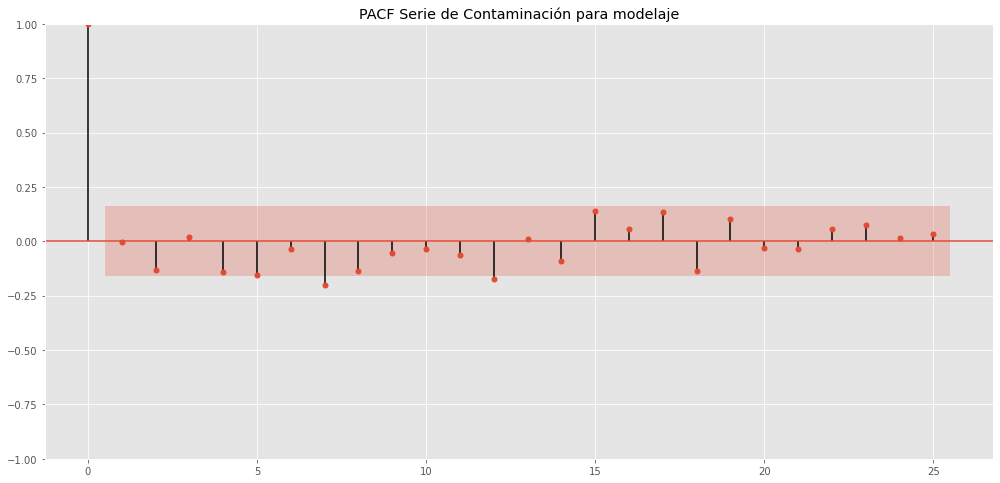

In [ ]:
acf_nofou = plot_acf(Conta_mod,unbiased=False,lags=25,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_nofou)
pacf_nofou = plot_pacf(Conta_mod,lags=25,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_nofou)

En cuanto al acf, podemos observar que ningún retardo sobrepasa las bandas de confianza, sin embargo con el fin de postular un modelo MA puro se decide tomar como máximo orden el retardo más cercano a las bandas, el cual es el 5. Por otro lado, para el pacf, se tiene que el máximo retardo diferente de cero para considerar para un AR puro, dentro del primer período de la serie, es el número 7.

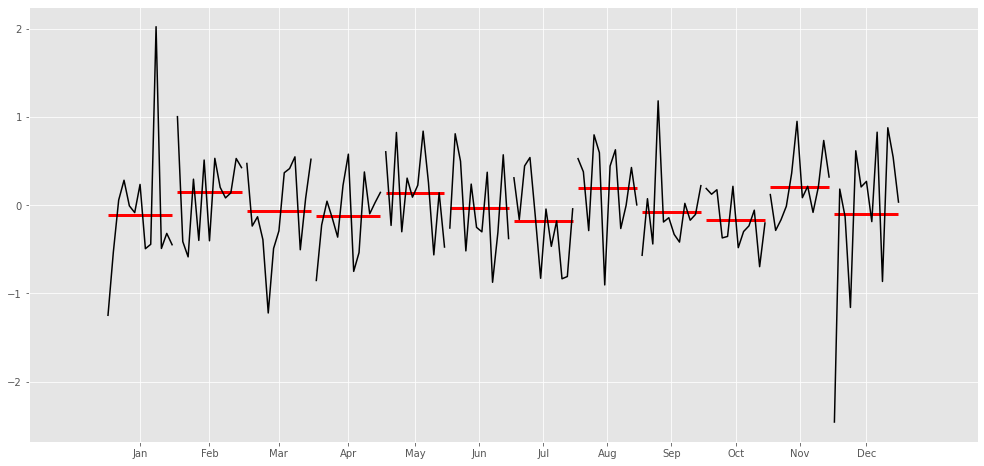

In [ ]:
meses2=sm.graphics.tsa.month_plot(Conta_mod)
plt.show(meses2)

A través del gráfico de la serie por meses, podemos observar como ya no hay tantas diferencias en el valor medio de cada mes, indicando que se obtuvo una buena estimación de la componente estacional.

## 4.2.2 Ajuste de modelos puros AR y MA

Habiendo observado los acf del proceso, los órdenes que es posible considerar para el ajuste de procesos puros, según los rezagos que se salen de las bandas, son AR(7) y MA(5).

Estos fueron refinados, en el AR(7) se establecieron como 0 los parámetros $𝚽_1$, $𝚽_3$ y $𝚽_6$ y el MA se usó un MA(5) con $θ_1$ como 0.


In [ ]:
import statsmodels as sm2

#### Ajuste de un modelo AR(7)
modelo_AR = sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod, trend='n', order=(7,0,0), enforce_stationarity=False)
with modelo_AR.fix_params({'ar.L6': 0.0, 'ar.L3':0.0, 'ar.L1':0.0}):
 resultauto_ar = modelo_AR.fit()
print(resultauto_ar.summary())

#### Ajuste de un modelo MA(5)
modelo_MA=sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod, trend='n', order=[0,0,2], enforce_stationarity=False)
#with modelo_MA.fix_params({'ma.L1': 0.0}):
resultauto_ma = modelo_MA.fit()
print(resultauto_ma.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(7, 0, 0)   Log Likelihood                 -91.241
Date:                Thu, 01 Dec 2022   AIC                            192.482
Time:                        14:32:19   BIC                            207.261
Sample:                    12-01-2006   HQIC                           198.488
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1 (fixed)          0        nan        nan        nan         nan         nan
ar.L2            -0.1019      0.094     -1.088      0.277      -0.286       0.082
ar.L3 (fixed)          0        nan     

#### 4.3.2.1 Análisis de Residuos AR(7)

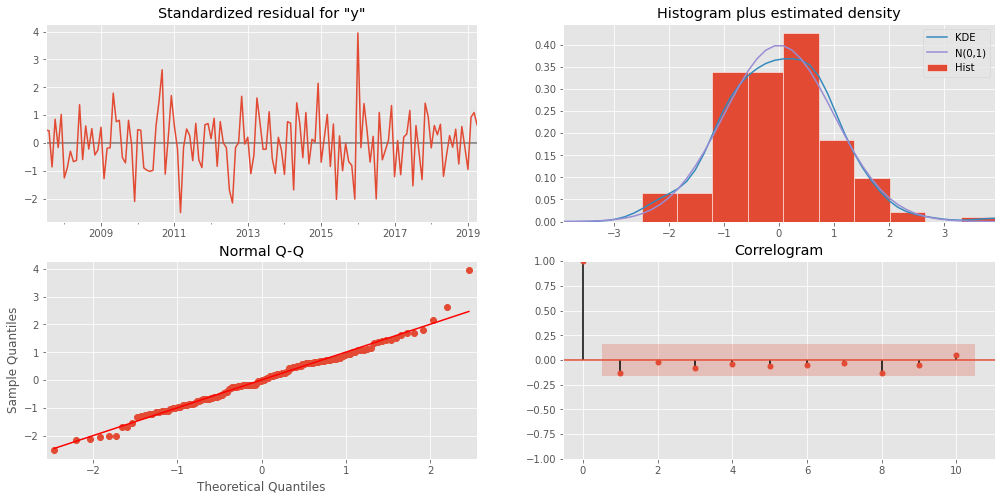

array([[1.18427039, 0.5643981 ]])

NormaltestResult(statistic=23.329616270949526, pvalue=8.590890713154513e-06)

In [ ]:

residuales_ar=resultauto_ar.resid
diag_ar = resultauto_ar.plot_diagnostics()
plt.show(diag_ar)
## Hipótesis nula de no heterocedasticidad
resultauto_ar.test_heteroskedasticity(method='breakvar') #[Est. de prueba, p-valor]

stats.normaltest(residuales_ar)
#1. Estadística de prueba
#2. El p valor
#3. Sesgo estimado de los datos
#4. Curtosis estimada


***Prueba de normalidad***

In [ ]:
 sp.stats.jarque_bera(residuales_ar)

Jarque_beraResult(statistic=69.29209870549236, pvalue=8.881784197001252e-16)

Se rechaza la hipótesis de normalidad

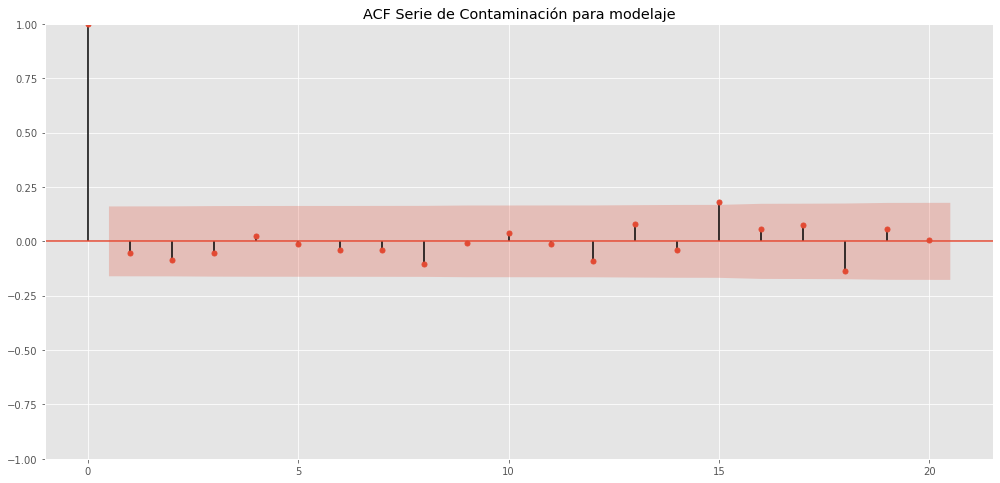

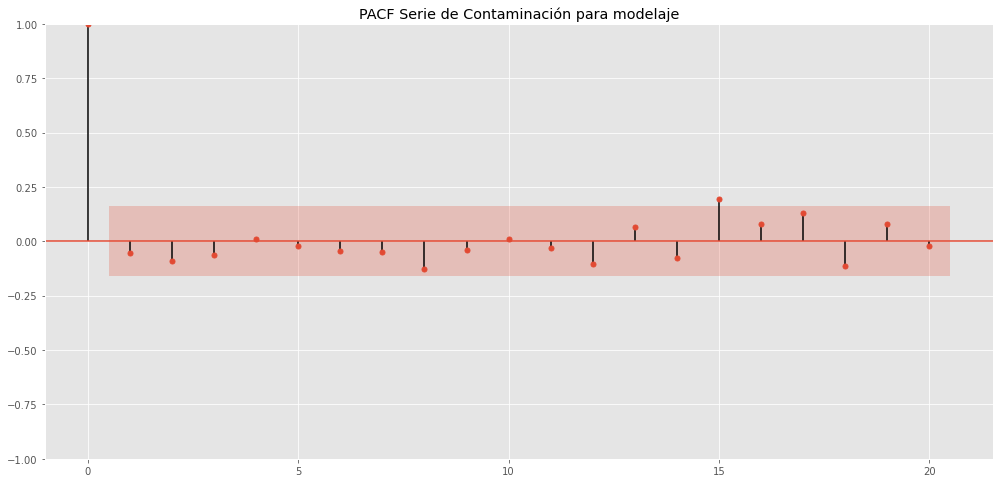

In [ ]:
acf_ar = plot_acf(residuales_ar,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_ar)
pacf_ar = plot_pacf(residuales_ar,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_ar)

***Prueba de autocorrelación global cero***

In [ ]:
len(residuales_ar)/4 #37.25
np.sqrt(len(residuales_ar)) #12.2
sm.stats.acorr_ljungbox(residuales_ar, lags=[24],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
24  21.466043   0.611103

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM AR(7)')

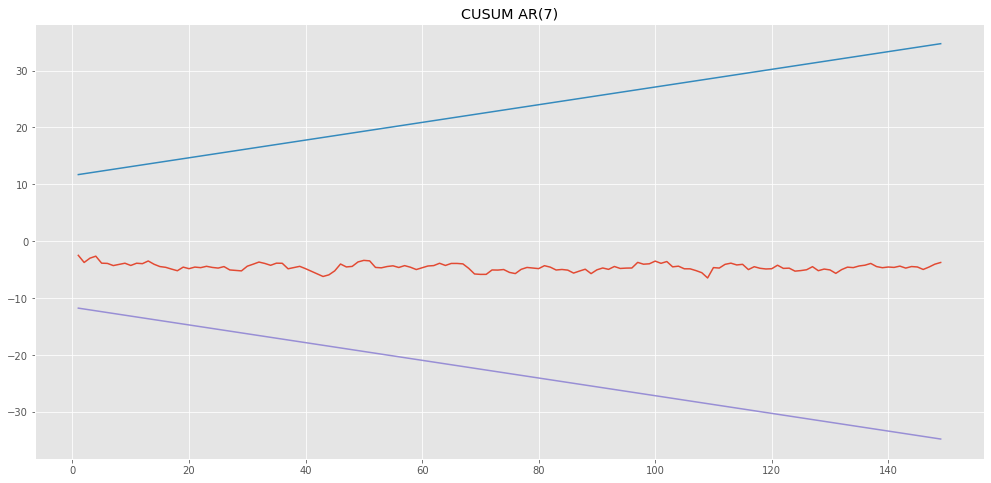

In [ ]:
cusum = residuales_ar.cumsum()
N=len(residuales_ar)
cusumsq = ((residuales_ar.values)**2)
tiempo = np.array(range(1,len(residuales_ar)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_ar.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM AR(7)")


Text(0.5, 1.0, 'CUSUM CUADRADO AR(7)')

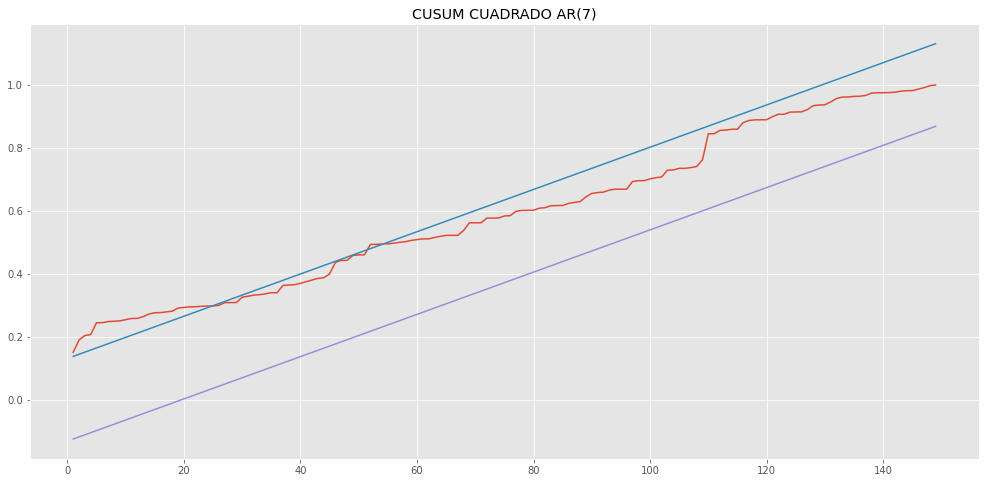

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO AR(7)")

#### 4.3.2.2 Análisis de residuos MA(2)

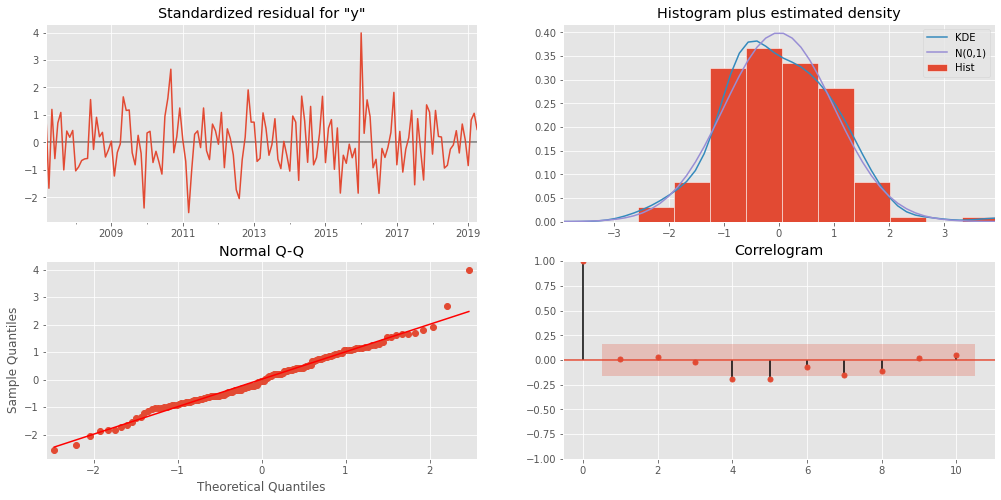

array([[1.07627584, 0.79800032]])

NormaltestResult(statistic=17.371721566849125, pvalue=0.00016895793431135342)

In [ ]:
#####Análisis de Residuales MA(2)  ######
residuales_ma=resultauto_ma.resid
diag_ma = resultauto_ma.plot_diagnostics()
plt.show(diag_ma)
## Hipótesis nula de no heterocedasticidad
resultauto_ma.test_heteroskedasticity(method='breakvar') #[Est. de prueba, p-valor]

stats.normaltest(residuales_ma)
#1. Estadística de prueba
#2. El p valor
#3. Sesgo estimado de los datos
#4. Curtosis estimada

***Prueba de normalidad***

In [ ]:
 sp.stats.jarque_bera(residuales_ma)

Jarque_beraResult(statistic=50.615798881969496, pvalue=1.0207501510706152e-11)

Se rechaza la hipótesis de normalidad

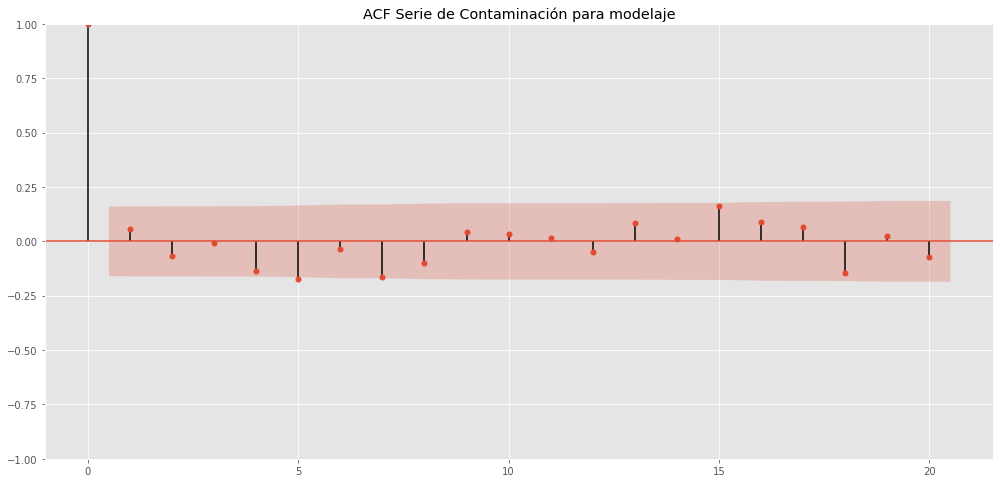

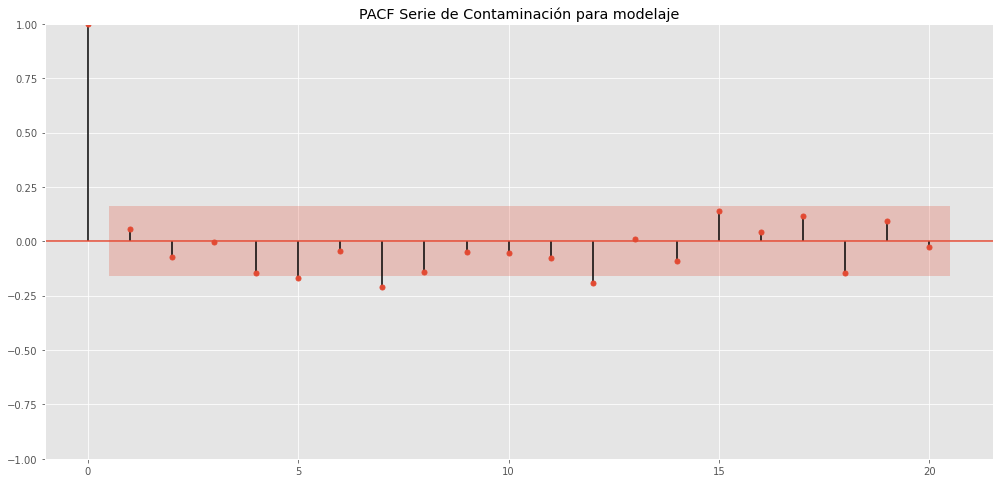

In [ ]:
acf_ma = plot_acf(residuales_ma,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_ma)
pacf_ma = plot_pacf(residuales_ma,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_ma)

***Prueba de autocorrelación global cero***

In [ ]:
len(residuales_ma)/4 #37.25
np.sqrt(len(residuales_ma)) #12.2
sm.stats.acorr_ljungbox(residuales_ma, lags=[24],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
24  30.609949    0.16535

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM MA(7)')

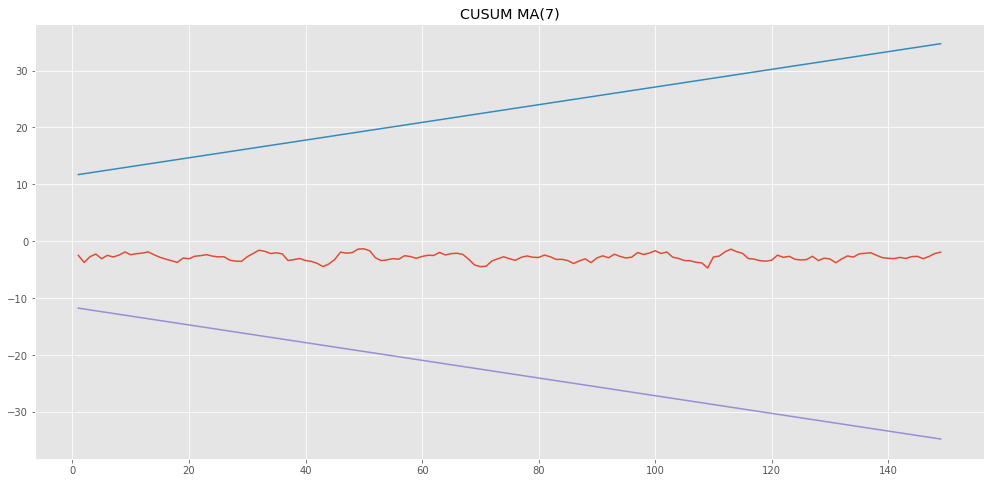

In [ ]:
cusum = residuales_ma.cumsum()
N=len(residuales_ma)
cusumsq = ((residuales_ma.values)**2)
tiempo = np.array(range(1,len(residuales_ma)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_ma.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM MA(7)")


Text(0.5, 1.0, 'CUSUM CUADRADO MA(7)')

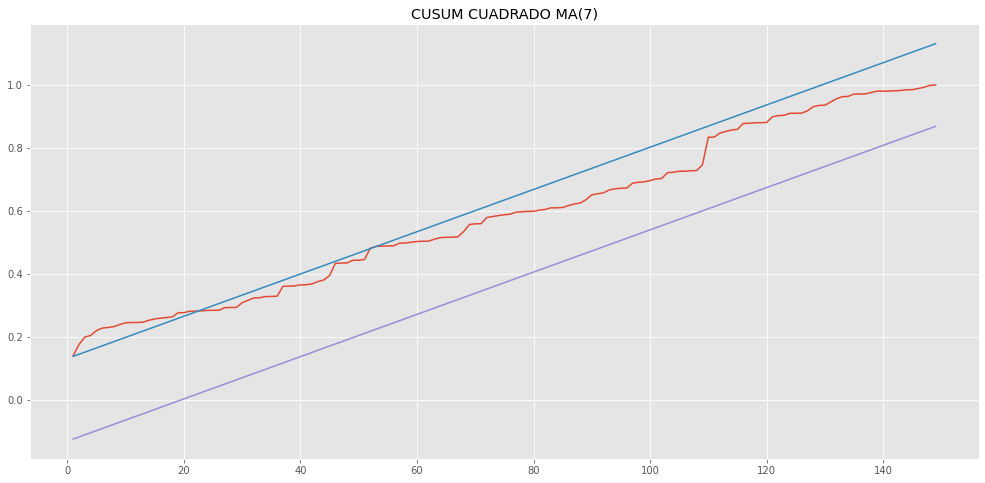

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO MA(7)")

## 4.2.3 Modelo mixto con Autoarima

In [ ]:
auto = auto_arima(Conta_mod,start_p=0,start_q=0,max_p=12,max_q=5,max_order=13,with_intercept=False,stepwise=False,stationary=True,seasonal=False,information_criterion='aicc')
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -102.890
Date:                Thu, 01 Dec 2022   AIC                            219.779
Time:                        14:33:25   BIC                            240.807
Sample:                    12-01-2006   HQIC                           228.322
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3177      0.223      5.901      0.000       0.880       1.755
ar.L2         -0.6308      0.220     -2.873      0.004      -1.061      -0.200
ar.L3          0.2217      0.140      1.581      0.114      -0.053       0.497
ar.L4         -0.2072      0.092     -2.256      0.024      -0.387      -0.027
ma.L1         -1.5952      0.231     -6.912      0.000      -2.048      -1.143
ma.L2          0.6096      0.227      2.686      0.007       0.165       1.054
sigma2         0.2283      0.021     10.936      0.000       0.187       0.269
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                24.67
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.51
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo sugerido es un ARMA(4,2)

In [ ]:
#####Análisis de Residuales ARMA(4,2)######
modelo_ARMA=sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod, trend='n', order=[4,0,2], enforce_stationarity=False)
ajuste_ARMA=modelo_ARMA.fit()
print(ajuste_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(4, 0, 2)   Log Likelihood                 -83.314
Date:                Thu, 01 Dec 2022   AIC                            180.629
Time:                        14:33:26   BIC                            201.466
Sample:                    12-01-2006   HQIC                           189.095
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2515      0.155      8.067      0.000       0.947       1.556
ar.L2         -0.4594      0.171     -2.687      0.007      -0.794      -0.124
ar.L3          0.0642      0.144      0.446      0.6

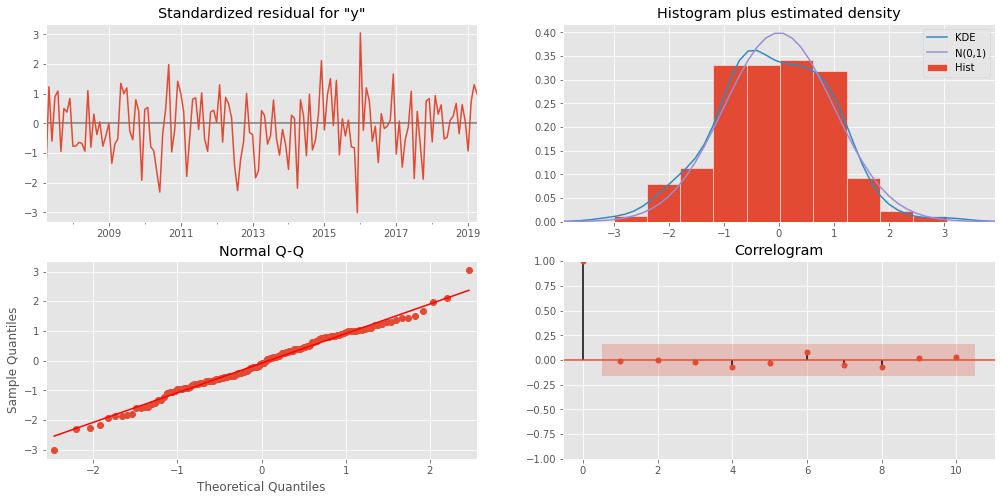

In [ ]:
residuales_arma=ajuste_ARMA.resid
diag_arma = ajuste_ARMA.plot_diagnostics()
plt.show(diag_arma)

***Prueba de normalidad***

In [ ]:
 sp.stats.jarque_bera(residuales_arma)

Jarque_beraResult(statistic=73.51578300840396, pvalue=1.1102230246251565e-16)

Se rechaza la hipótesis de normalidad

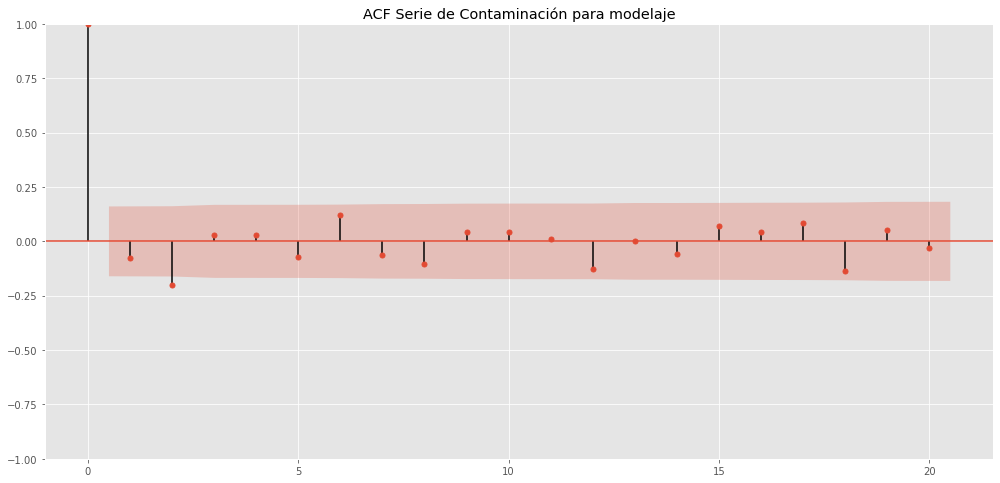

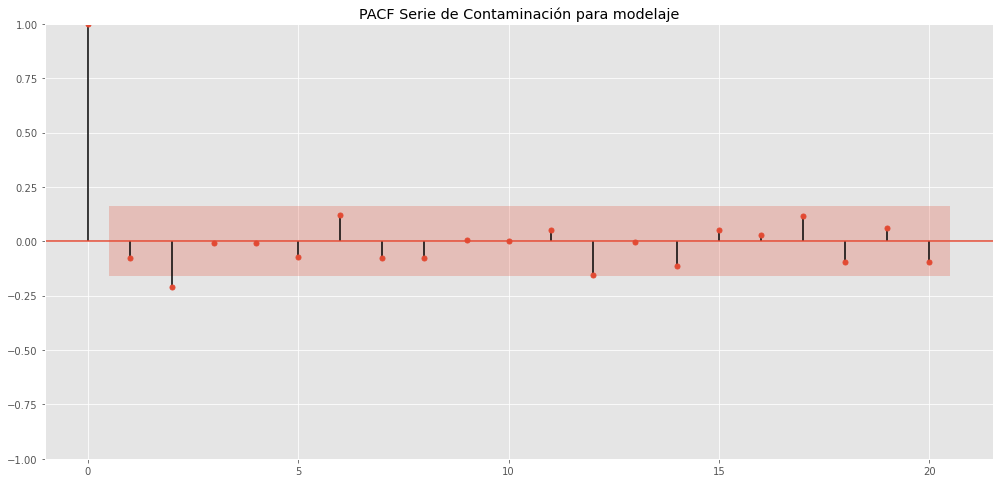

In [ ]:
acf_arma = plot_acf(residuales_arma,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_arma)
pacf_arma = plot_pacf(residuales_arma,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_arma)

***Prueba de autocorrelación global cero***

In [ ]:
len(residuales_arma)/4 #37.25
np.sqrt(len(residuales_arma)) #12.2
sm.stats.acorr_ljungbox(residuales_arma, lags=[24],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
24  24.260676   0.446775

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM ARMA(4,2)')

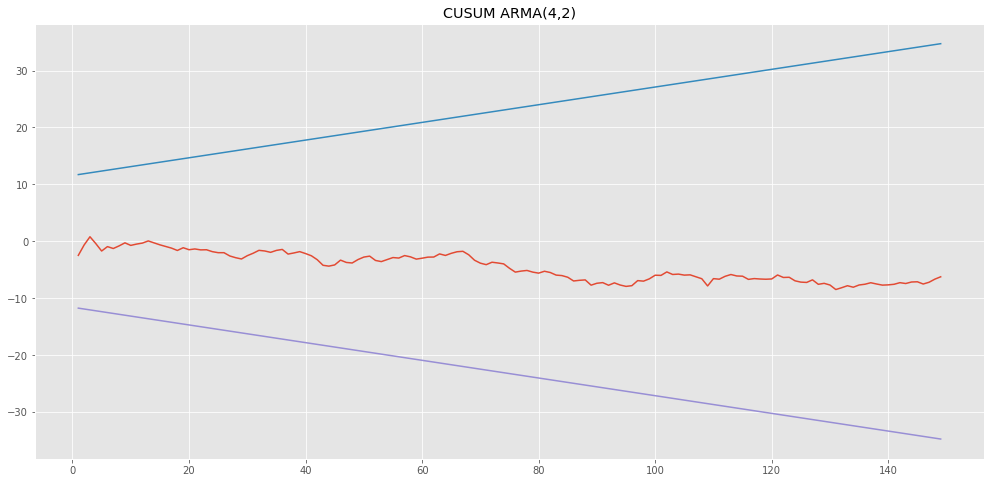

In [ ]:
cusum = residuales_arma.cumsum()
N=len(residuales_arma)
cusumsq = ((residuales_arma.values)**2)
tiempo = np.array(range(1,len(residuales_arma)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_arma.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM ARMA(4,2)")


Text(0.5, 1.0, 'CUSUM CUADRADO ARMA(4,2)')

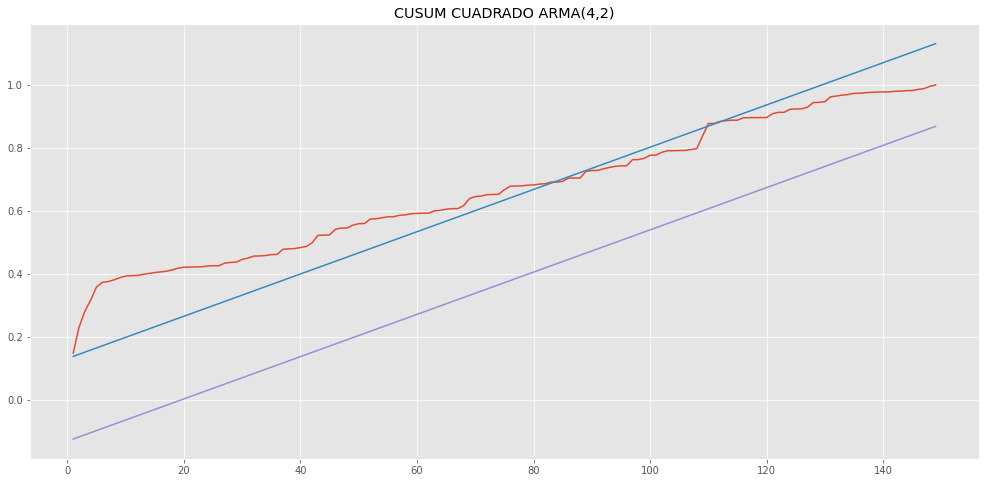

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO ARMA(4,2)")

## 4.2.4 Selección del mejor modelo ARMA con Fourier por medio de Rolling

Para seleccionar el mejor modelo ARMA con series de Fourier, se realiza rolling con cada uno. Para ello, se construyen los conjuntos de entrenamiento y de validación, se estima el error cuádratico medio u paso adelante como medida de presición y, utilizando su raíz para poder comparar, se selecciona el modelo de menor ECM

#### Rolling AR(7)

In [ ]:
## Rolling
year = 1/(1/12)
Cont2 = pd.DataFrame(Conta_sin_tend.iloc[:split3])

#Fourier n=1 2pi*1
Cont2['Year sin'] = np.sin(np.arange(1,169)*(2 * np.pi / year))
Cont2['Year cos'] = np.cos(np.arange(1,169)*(2 * np.pi / year))

# Fourier n=2 2pi*2
Cont2['Year sin2'] = np.sin(np.arange(1,169)*(4 * np.pi / year))
Cont2['Year cos2'] = np.cos(np.arange(1,169)*(4 * np.pi / year))

# Fourier n=3 2pi*3
Cont2['Year sin3'] = np.sin(np.arange(1,169)*(6 * np.pi / year))
Cont2['Year cos3'] = np.cos(np.arange(1,169)*(6 * np.pi / year))

X=np.column_stack((Cont2['Year cos'],Cont2['Year sin'],Cont2['Year cos2'],Cont2['Year sin2'],Cont2['Year cos3'],Cont2['Year sin3']))

from sklearn.metrics import mean_squared_error

history = [x for x in df_train2]
predicciones = list()
for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste del Fourier
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste AR(7)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(7,0,0), enforce_stationarity=False)
 with modelo.fix_params({'ar.L6': 0.0, 'ar.L3':0.0, 'ar.L1':0.0}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)


Predicción=-0.390531, Esperado=-0.166591
Predicción=-0.971193, Esperado=-1.952152
Predicción=-1.386266, Esperado=-1.440301
Predicción=-0.941347, Esperado=-1.105495
Predicción=-0.400644, Esperado=-0.374838
Predicción=0.518561, Esperado=0.218346
Predicción=0.628865, Esperado=0.516301
Predicción=0.163966, Esperado=0.702688
Predicción=0.665564, Esperado=0.417882
Predicción=1.112506, Esperado=1.658564
Predicción=1.058920, Esperado=2.443574
Predicción=0.112582, Esperado=-0.791299
Predicción=-0.665764, Esperado=-2.138029
Predicción=-0.831828, Esperado=-0.632454
Predicción=-1.373323, Esperado=-1.430600
Predicción=-1.119874, Esperado=-0.890302
Predicción=0.235880, Esperado=-0.151525
Predicción=0.393271, Esperado=0.362119
Predicción=0.572524, Esperado=0.979691
ECM: 0.612


#### Rolling MA(2)

In [ ]:
history = [x for x in df_train2]
predicciones = list()
for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste del Fourier
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste MA(2)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(0,0,2), enforce_stationarity=False)
 modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)

Predicción=-0.523129, Esperado=-0.166591
Predicción=-0.942295, Esperado=-1.952152
Predicción=-1.116186, Esperado=-1.440301
Predicción=-0.879046, Esperado=-1.105495
Predicción=-0.214339, Esperado=-0.374838
Predicción=0.471819, Esperado=0.218346
Predicción=0.445210, Esperado=0.516301
Predicción=0.154369, Esperado=0.702688
Predicción=0.402215, Esperado=0.417882
Predicción=1.008573, Esperado=1.658564
Predicción=0.971836, Esperado=2.443574
Predicción=0.159037, Esperado=-0.791299
Predicción=-0.564687, Esperado=-2.138029
Predicción=-0.552114, Esperado=-0.632454
Predicción=-0.738034, Esperado=-1.430600
Predicción=-0.951132, Esperado=-0.890302
Predicción=-0.112886, Esperado=-0.151525
Predicción=0.426230, Esperado=0.362119
Predicción=0.423961, Esperado=0.979691
ECM: 0.668


#### Rolling ARMA(4,2)

In [ ]:
history = [x for x in df_train2]
predicciones = list()
for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste del Fourier
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste ARMA(4,2)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(4,0,2), enforce_stationarity=False)
 modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)

Predicción=-0.743041, Esperado=-0.166591
Predicción=-1.295207, Esperado=-1.952152
Predicción=-1.337762, Esperado=-1.440301
Predicción=-1.108099, Esperado=-1.105495
Predicción=-0.409392, Esperado=-0.374838
Predicción=0.436039, Esperado=0.218346
Predicción=0.582634, Esperado=0.516301
Predicción=0.352360, Esperado=0.702688
Predicción=0.532644, Esperado=0.417882
Predicción=1.190499, Esperado=1.658564
Predicción=0.982064, Esperado=2.443574
Predicción=-0.304921, Esperado=-0.791299
Predicción=-0.817099, Esperado=-2.138029
Predicción=-0.707839, Esperado=-0.632454
Predicción=-1.193722, Esperado=-1.430600
Predicción=-1.099343, Esperado=-0.890302
Predicción=-0.053168, Esperado=-0.151525
Predicción=0.663400, Esperado=0.362119
Predicción=0.743843, Esperado=0.979691
ECM: 0.541


De los modelos selecionados se selcciona el ARMA(4,2) por ser el de menor ECM un paso adelante.

## 4.2.5 Reajuste del modelo final

In [ ]:
# Ajustando la estacionalidad
linmodel_ciclo = sm.OLS(Conta_sin_tend[:split3], X)
results_ciclo = linmodel_ciclo.fit()
Conta_final_fou = Conta_sin_tend[:split3] - results_ciclo.predict(X)

#### Ajuste de un modelo ARMA(4,2)
modelo_final_fou = sm2.tsa.statespace.sarimax.SARIMAX(Conta_final_fou, trend='n', order=(4,0,2), enforce_stationarity=False)
result_final_fou = modelo_final_fou.fit()
print(result_final_fou.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(4, 0, 2)   Log Likelihood                 -98.535
Date:                Thu, 01 Dec 2022   AIC                            211.070
Time:                        14:33:42   BIC                            232.769
Sample:                    12-01-2006   HQIC                           219.879
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2408      0.157      7.906      0.000       0.933       1.548
ar.L2         -0.5163      0.153     -3.385      0.001      -0.815      -0.217
ar.L3          0.1292      0.125      1.035      0.3

## 4.2.6 Modelamiento de la estacionalidad con Dummy

Ahora, se realiza un modelamiento con ARMA explicando la estacionalidad por medio de variables Dummy.

In [ ]:
from statsmodels.datasets import sunspots
from statsmodels.tsa.deterministic import Seasonality
Dummy= Seasonality(period=12, initial_period=12)
X=Dummy.in_sample(df_train2.index)

linmodel_ciclo2 = sm.OLS(df_train2, X)
results_ciclo2 = linmodel_ciclo2.fit()
print(results_ciclo2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     24.75
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           1.90e-27
Time:                        14:33:42   Log-Likelihood:                -114.80
No. Observations:                 149   AIC:                             253.6
Df Residuals:                     137   BIC:                             289.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
s(1,12)        0.3392      0.151      2.243      0.0

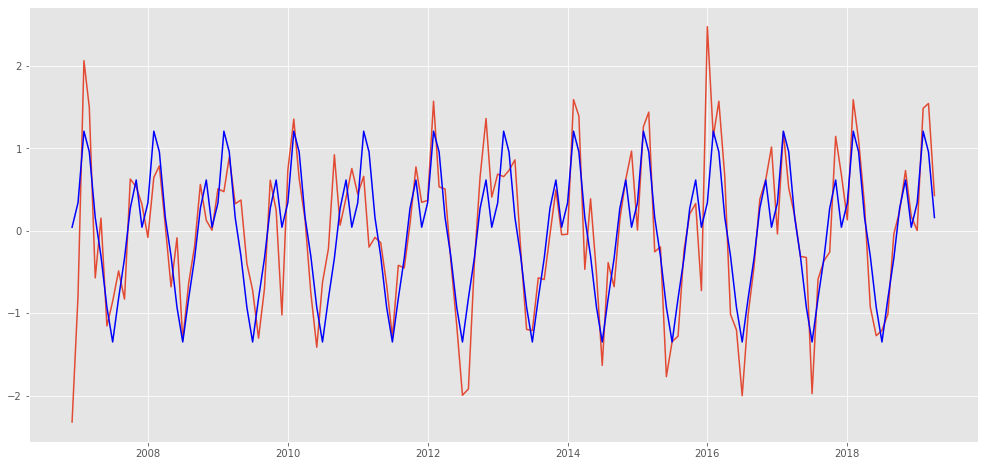

In [ ]:
#@title
ypred2 = results_ciclo2.predict(X)
Cont2["predict estacion2"] = ypred2
plt.plot(df_train2)
plt.plot(Cont2["predict estacion2"], color="blue")
plt.show()

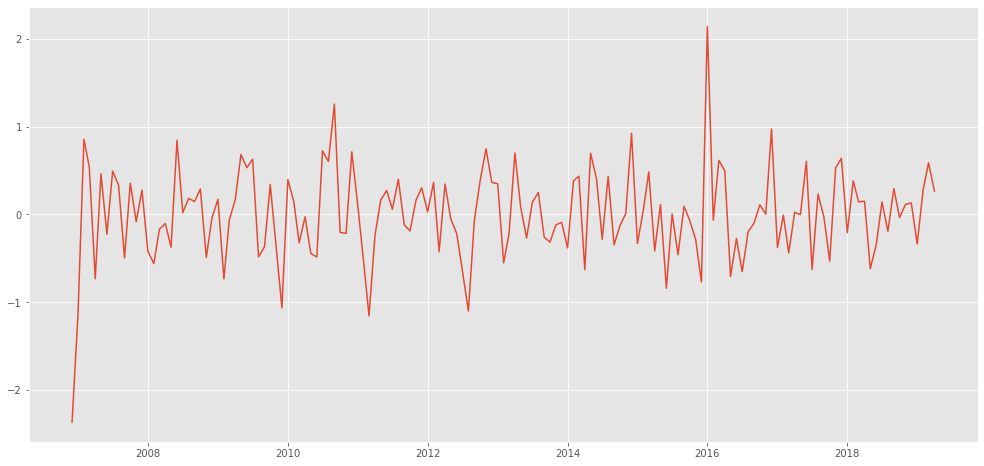

In [ ]:
#@title
# Serie sin tendencia ni estacionalidad
Conta_mod2=df_train2-ypred2
plt.plot(Conta_mod2)

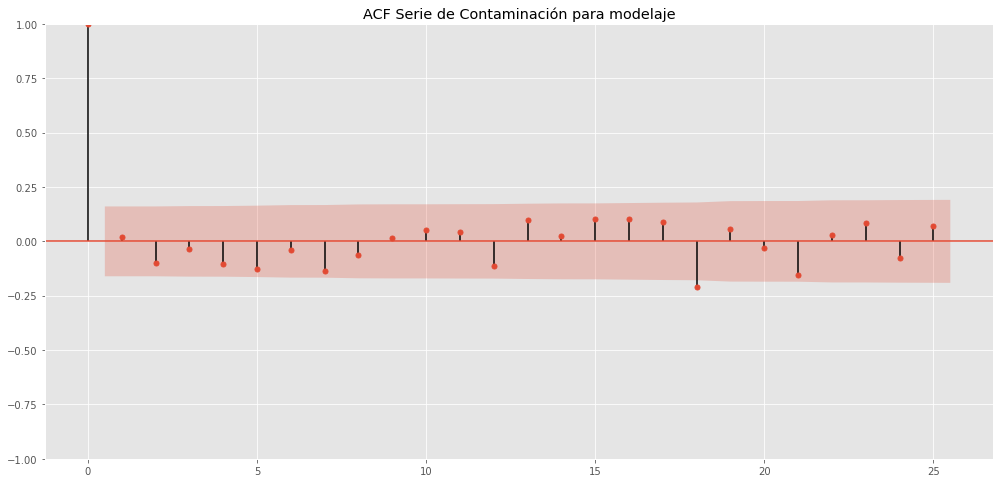

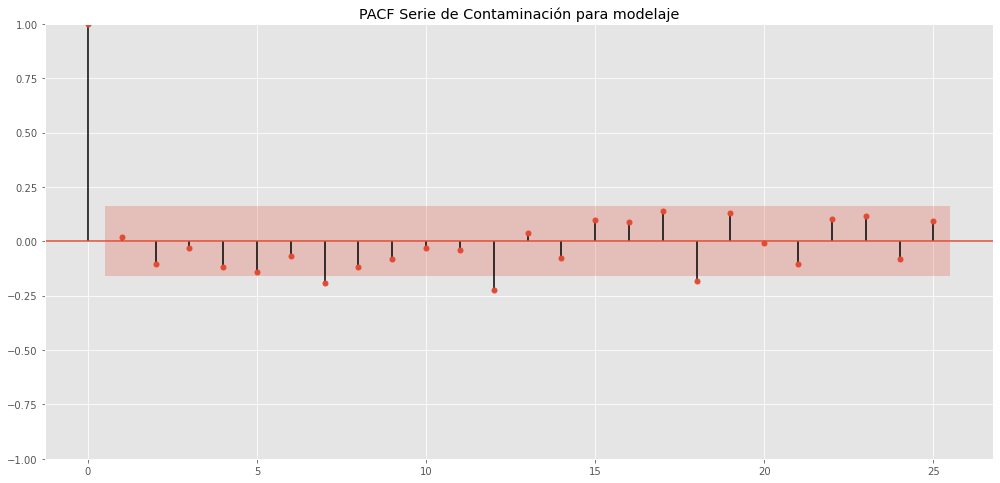

In [ ]:
#@title
acf_nodum = plot_acf(Conta_mod2,unbiased=False,lags=25,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_nodum)
pacf_nodum = plot_pacf(Conta_mod2,lags=25,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_nodum)

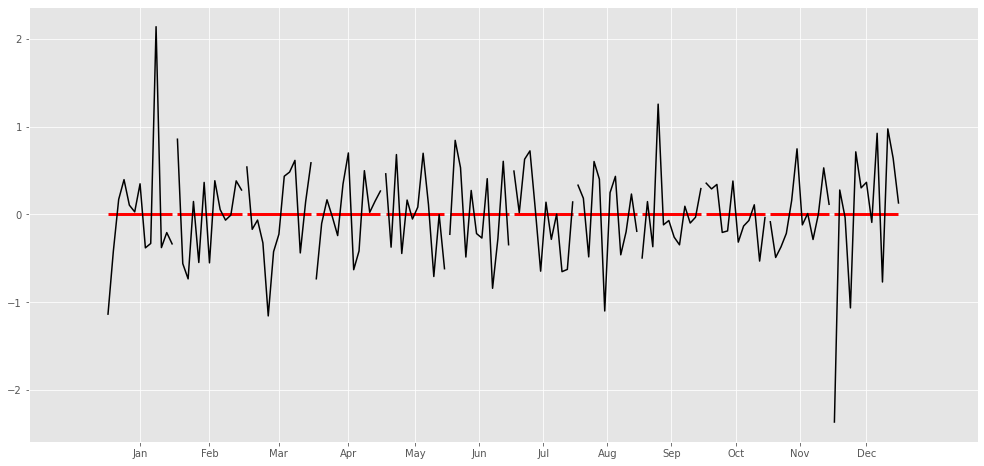

In [ ]:
#@title
meses3=sm.graphics.tsa.month_plot(Conta_mod2)
plt.show(meses3)

## 4.2.7 Modelos puros con dummy AR y MA

Dada la significancia de laa autocorrelaciones de retardo 7 se contemplan los modelos puros AR(7) Y MA(7).
Estos son refinados, en el AR(7) se estableció $𝚽_6=0$ y el MA se reduce a un MA(4).

In [ ]:
#@title
#### Ajuste de un modelo AR(7)
modelo_AR2=sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod2, trend='n', order=[7,0,0], enforce_stationarity=False)
with modelo_AR2.fix_params({'ar.L6': 0.0}):
 resultauto_ar2 = modelo_AR2.fit()
print(resultauto_ar2.summary())

#### Ajuste de un modelo MA(4)
modelo_MA2=sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod2, trend='n', order=[0,0,4], enforce_invertibility=False)
resultauto_ma2 = modelo_MA2.fit()
print(resultauto_ma2.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(7, 0, 0)   Log Likelihood                 -88.601
Date:                Thu, 01 Dec 2022   AIC                            191.202
Time:                        14:33:45   BIC                            211.892
Sample:                    12-01-2006   HQIC                           199.609
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1            -0.0704      0.087     -0.805      0.421      -0.242       0.101
ar.L2            -0.0838      0.098     -0.855      0.393      -0.276       0.108
ar.L3            -0.0857      0.078     

## 4.2.8 Análisis residuos AR(7)

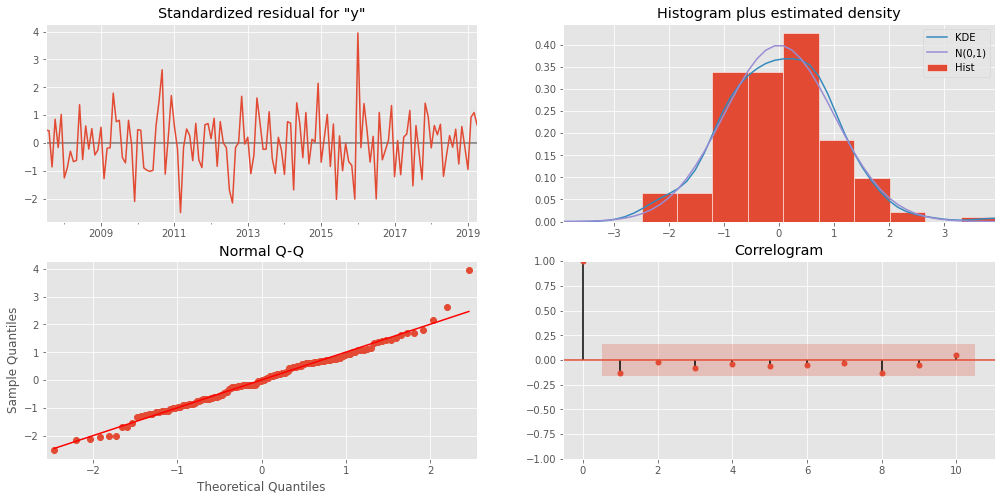

array([[1.03673057, 0.90211531]])

NormaltestResult(statistic=23.526531986151756, pvalue=7.785356246655736e-06)

In [ ]:
#@title
#####   Análisis de Residuales   AR(7)  ######
residuales_ar2=resultauto_ar2.resid
diag_ar2 = resultauto_ar.plot_diagnostics()
plt.show(diag_ar2)
## Hipótesis nula de no heterocedasticidad
resultauto_ar2.test_heteroskedasticity(method='breakvar') #[Est. de prueba, p-valor]

stats.normaltest(residuales_ar2)
#1. Estadística de prueba
#2. El p valor
#3. Sesgo estimado de los datos
#4. Curtosis estimada

***Prueba de normalidad***

In [ ]:
#@title
sp.stats.jarque_bera(residuales_ar2)

Jarque_beraResult(statistic=75.48373667525935, pvalue=0.0)

Se rechaza la hipótesis de normalidad

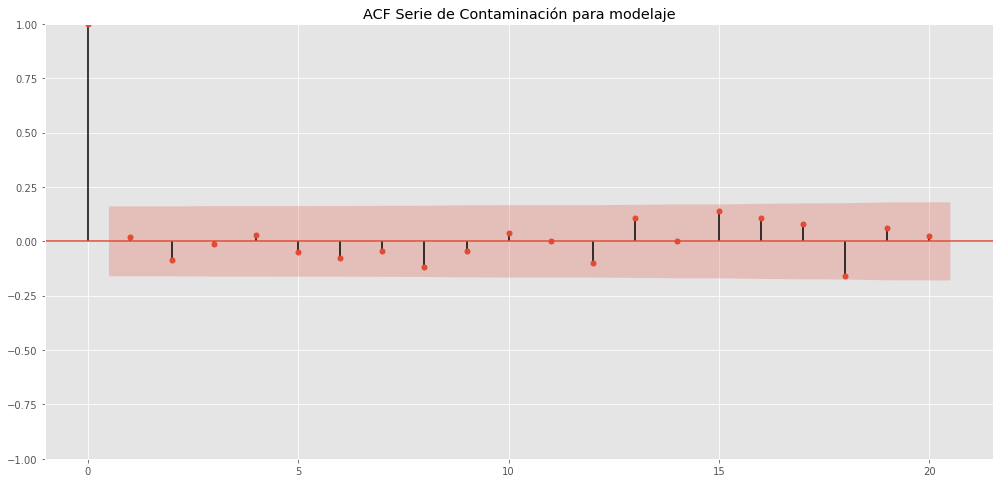

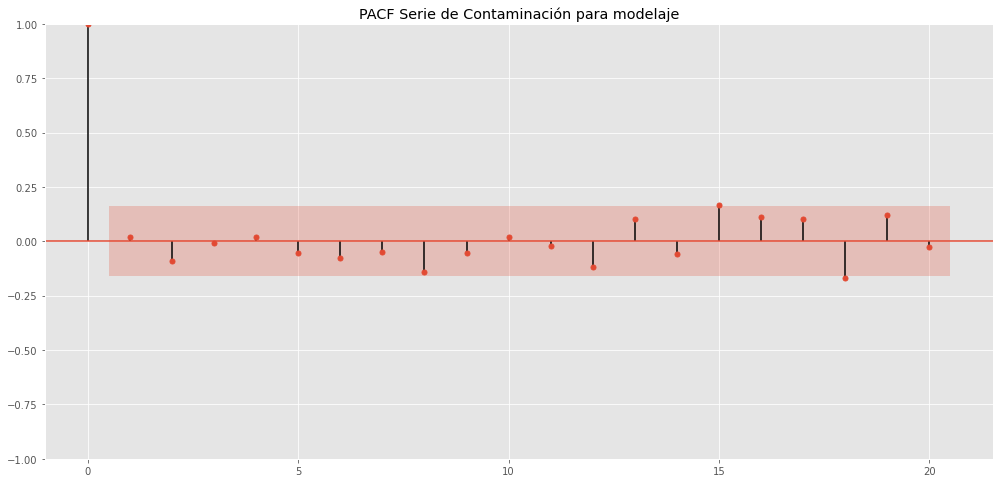

In [ ]:
#@title
acf_ar2 = plot_acf(residuales_ar2,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_ar2)
pacf_ar2 = plot_pacf(residuales_ar2,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_ar2)

***Prueba de autocorrelación global cero***

In [ ]:
#@title
len(residuales_ar2)/4 #37.25
np.sqrt(len(residuales_ar2)) #12.2
sm.stats.acorr_ljungbox(residuales_ar2, lags=[24],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
24  27.650091   0.275075

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM AR(7)')

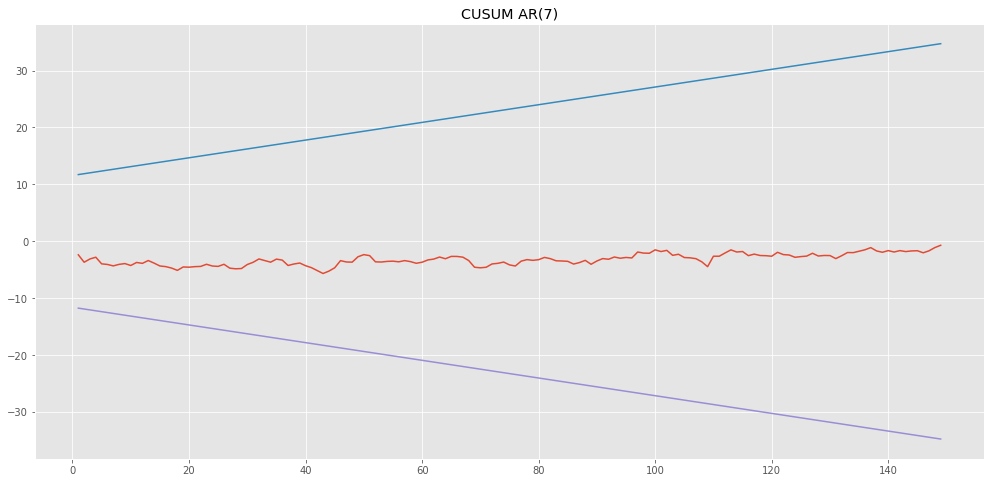

In [ ]:
cusum = residuales_ar2.cumsum()
N=len(residuales_ar2)
cusumsq = ((residuales_ar2.values)**2)
tiempo = np.array(range(1,len(residuales_ar2)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_ar2.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM AR(7)")


Text(0.5, 1.0, 'CUSUM CUADRADO AR(7)')

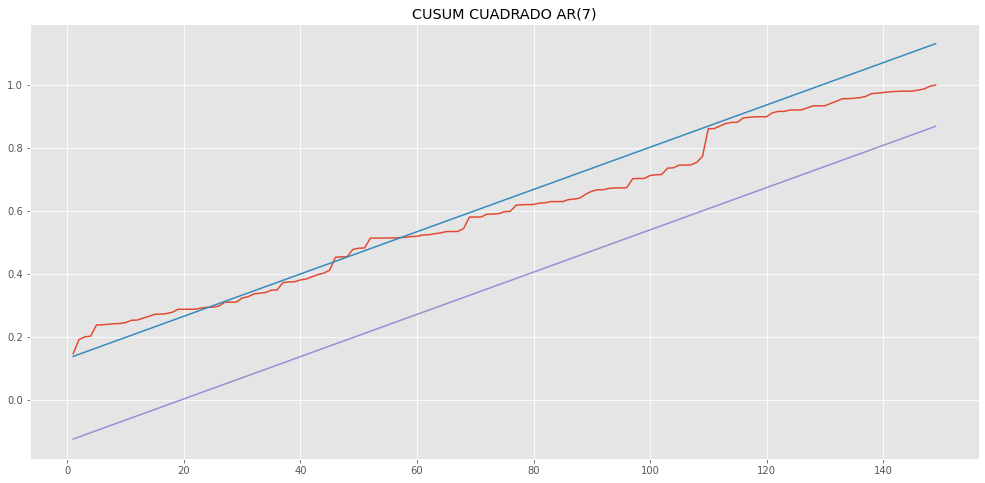

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO AR(7)")

## 4.2.9 Análisis residuos MA(4)

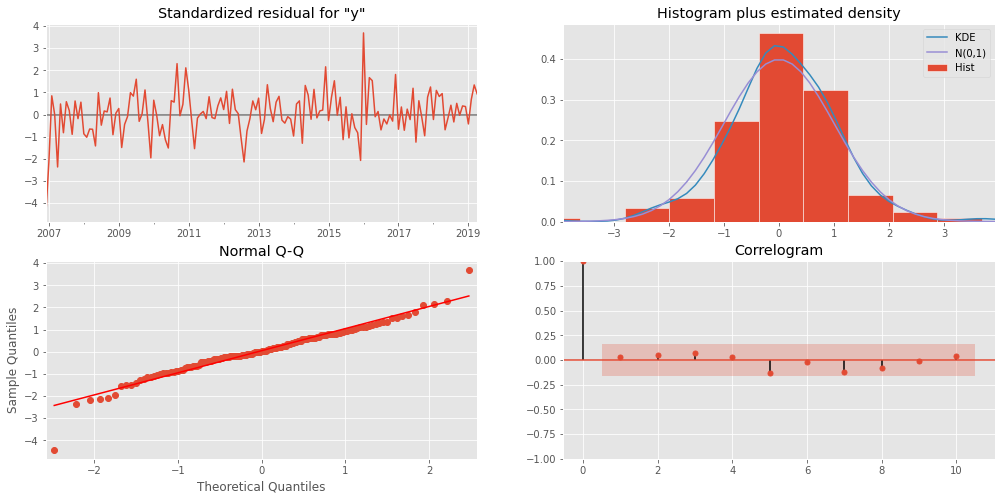

array([[0.7013125, 0.2131599]])

NormaltestResult(statistic=25.362287739931592, pvalue=3.109203823151006e-06)

In [ ]:
#@title
#####Análisis de Residuales MA(4)  ######
residuales_ma2=resultauto_ma2.resid
diag_ma2 = resultauto_ma2.plot_diagnostics()
plt.show(diag_ma2)
## Hipótesis nula de no heterocedasticidad
resultauto_ma2.test_heteroskedasticity(method='breakvar') #[Est. de prueba, p-valor]

stats.normaltest(residuales_ma2)
#1. Estadística de prueba
#2. El p valor
#3. Sesgo estimado de los datos
#4. Curtosis estimada

***Prueba de normalidad***

In [ ]:
#@title
sp.stats.jarque_bera(residuales_ma2)

Jarque_beraResult(statistic=85.60323609682123, pvalue=0.0)

Se rechaza la hipótesis de normalidad

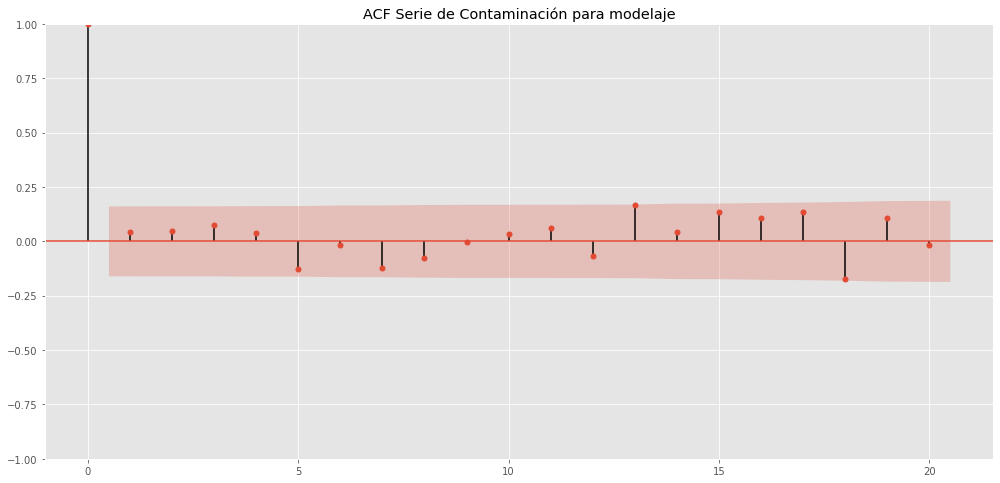

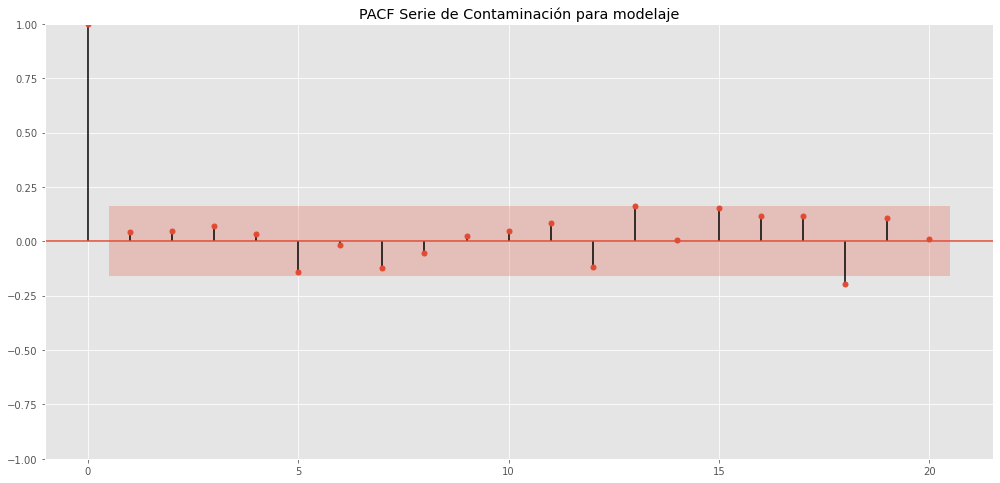

In [ ]:
#@title
acf_ma2 = plot_acf(residuales_ma2,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_ma2)
pacf_ma2 = plot_pacf(residuales_ma2,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_ma2)

***Prueba de autocorrelación global cero***

In [ ]:
#@title
len(residuales_ma2)/4 #37.25
np.sqrt(len(residuales_ma2)) #12.2
sm.stats.acorr_ljungbox(residuales_ma2, lags=[24],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
24  34.868861   0.070369

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM MA(4)')

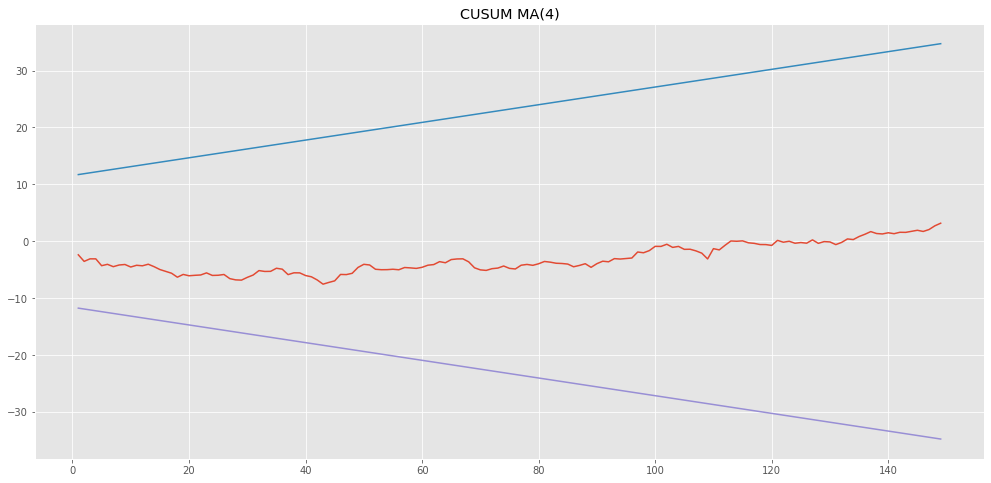

In [ ]:
cusum = residuales_ma2.cumsum()
N=len(residuales_ma2)
cusumsq = ((residuales_ma2.values)**2)
tiempo = np.array(range(1,len(residuales_ma2)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_ma2.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM MA(4)")


Text(0.5, 1.0, 'CUSUM CUADRADO MA(4)')

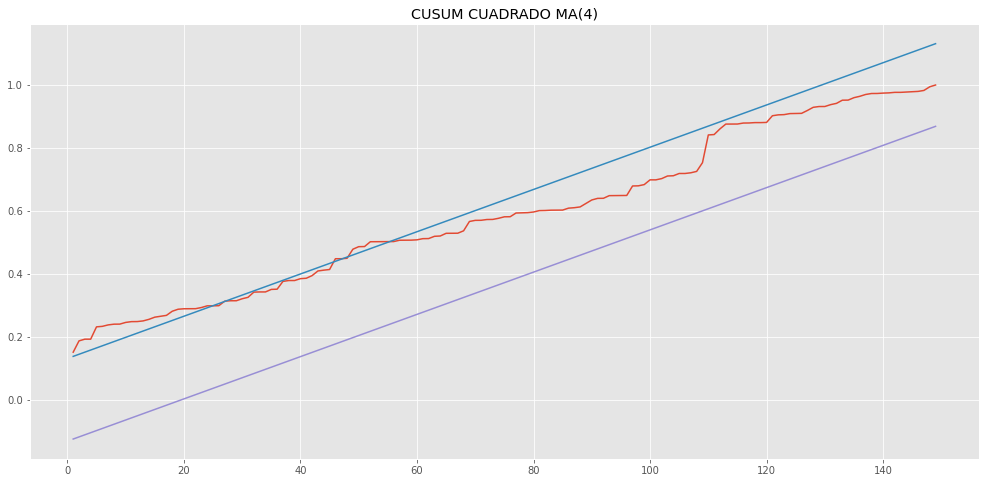

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO MA(4)")

## 4.2.10. Modelo mixto con Dummy usando autoarima

In [ ]:
#@title
auto = auto_arima(Conta_mod2,start_p=0,start_q=0,max_p=7,max_q=4,max_order=11,with_intercept=False,stepwise=False,stationary=True,seasonal=False,information_criterion='aicc')
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -101.079
Date:                Thu, 01 Dec 2022   AIC                            212.158
Time:                        14:34:09   BIC                            227.178
Sample:                    12-01-2006   HQIC                           218.261
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5913      0.091     17.421      0.000       1.412       1.770
ar.L2         -0.7558      0.067    -11.224      0.000      -0.888      -0.624
ma.L1         -1.7874      0.092    -19.442      0.000      -1.968      -1.607
ma.L2          0.8232      0.087      9.442      0.000       0.652       0.994
sigma2         0.2247      0.020     11.432      0.000       0.186       0.263
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                43.92
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.56
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo sugerido es un ARMA(2,2) este, se refina porque el $θ_2$ no es significativo, así que se continúa con un ARMA(2,1)

In [ ]:
#@title
#####Análisis de Residuales ARMA(2,1)######
modelo_ARMA2=sm2.tsa.statespace.sarimax.SARIMAX(Conta_mod2, trend='n', order=[2,0,2], enforce_invertibility=False)
with modelo_ARMA2.fix_params({'ma.L2': 0.0}):
 ajuste_ARMA2=modelo_ARMA2.fit()
print(ajuste_ARMA2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  149
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -104.992
Date:                Thu, 01 Dec 2022   AIC                            217.984
Time:                        14:34:09   BIC                            230.000
Sample:                    12-01-2006   HQIC                           222.866
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.8267      0.075     11.067      0.000       0.680       0.973
ar.L2            -0.2077      0.087     -2.374      0.018      -0.379      -0.036
ma.L1            -1.0577      0.056    -

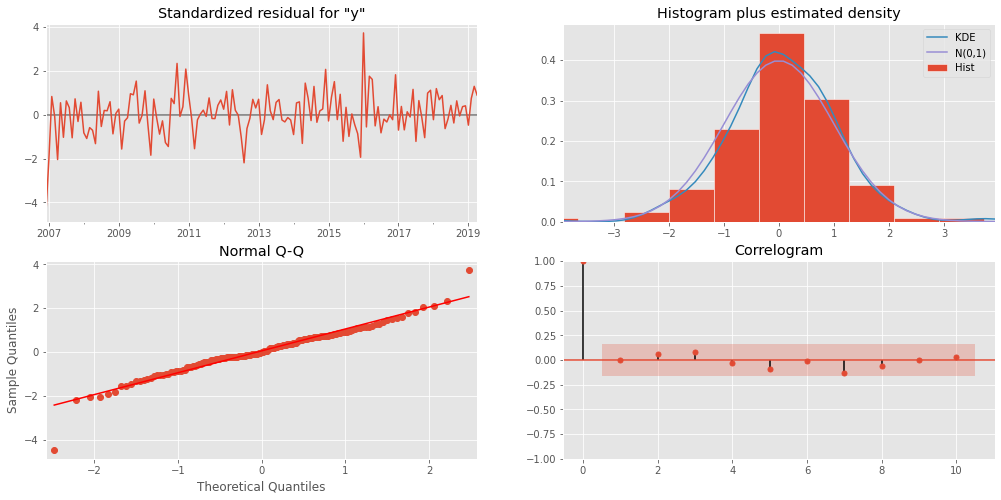

In [ ]:
#@title
residuales_arma2=ajuste_ARMA2.resid
diag_arma2 = ajuste_ARMA2.plot_diagnostics()
plt.show(diag_arma2)

***Prueba de normalidad***

In [ ]:
#@title
sp.stats.jarque_bera(residuales_arma2)

Jarque_beraResult(statistic=82.75673384064352, pvalue=0.0)

Se rechaza la hipótesis de normalidad

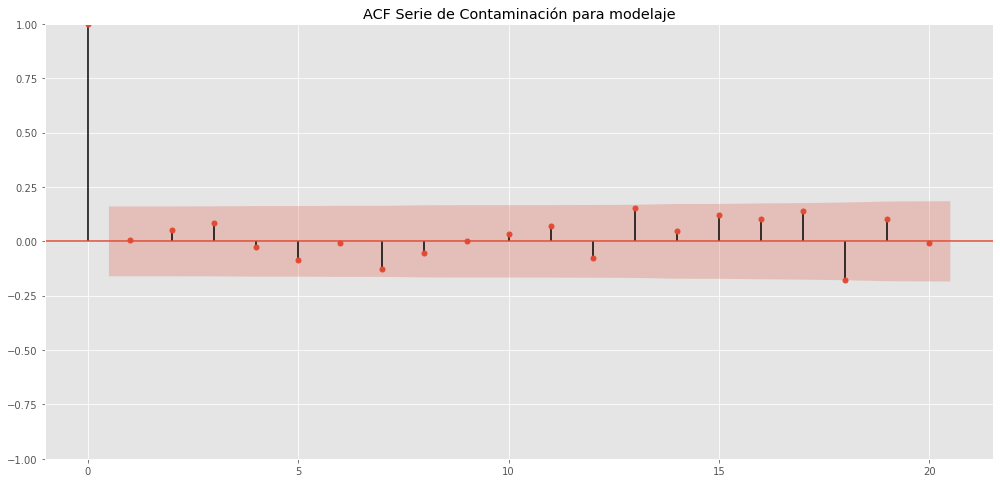

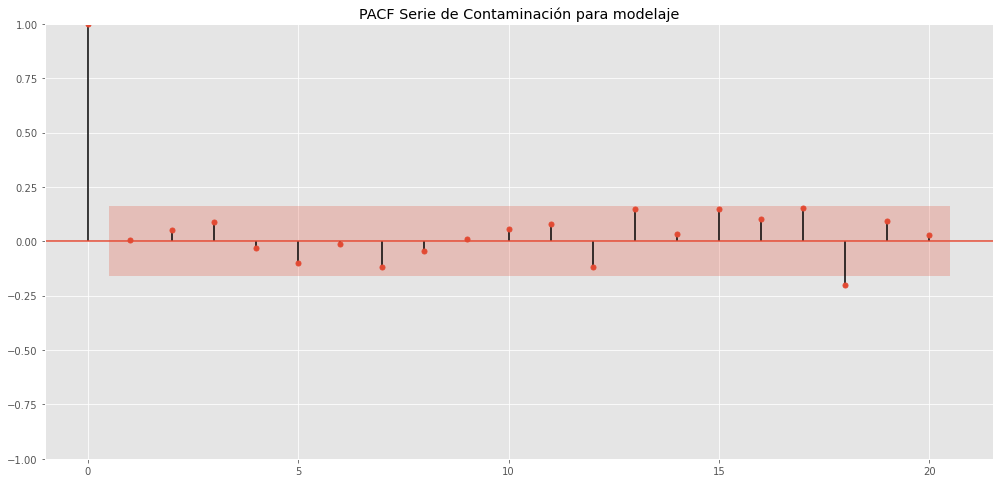

In [ ]:
acf_arma2 = plot_acf(residuales_arma2,unbiased=False,lags=20,title='ACF Serie de Contaminación para modelaje')
plt.show(acf_arma2)
pacf_arma2 = plot_pacf(residuales_arma2,lags=20,title='PACF Serie de Contaminación para modelaje')
plt.show(pacf_arma2)

***Prueba de autocorrelación global cero***

In [ ]:
#@title
len(residuales_arma2)/4 #37.25
np.sqrt(len(residuales_arma2)) #12.2
sm.stats.acorr_ljungbox(residuales_arma2, lags=[13],return_df=True)

37.25

12.206555615733702

lb_stat  lb_pvalue
13  11.608977   0.559938

El valor p obtenido es mayor que 0.05, por lo que no se rechaza la hipótesis de no autocorrelación en los residuos

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM AR(7)')

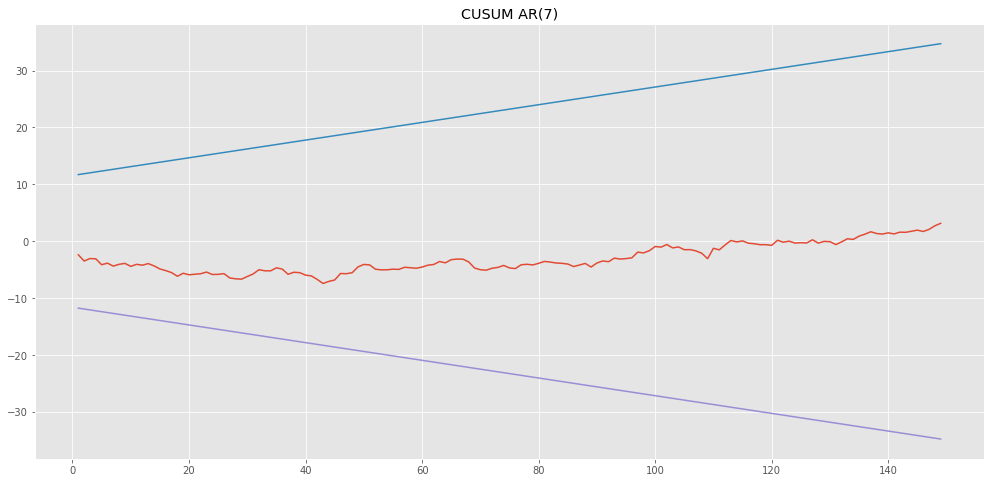

In [ ]:
cusum = residuales_arma2.cumsum()
N=len(residuales_arma2)
cusumsq = ((residuales_arma2.values)**2)
tiempo = np.array(range(1,len(residuales_arma2)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([residuales_arma2.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM AR(7)")


Text(0.5, 1.0, 'CUSUM CUADRADO AR(7)')

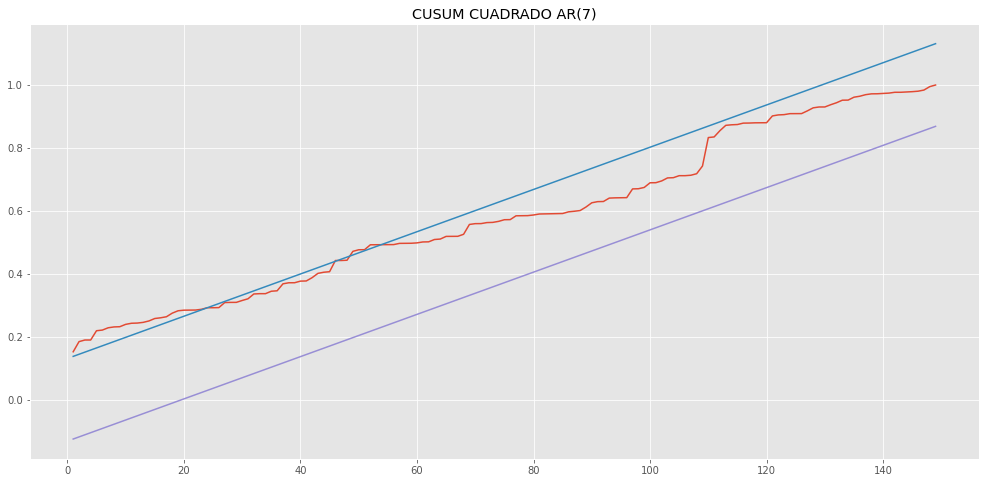

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO AR(7)")

## 4.2.11. Selección del mejor modelo ARMA con Dummy

Análogamente, se realiza un proceso de Rolling para seleccionar el mejor modelo con Dummy según el que tenga el menor ECM estimado.

#### Rolling AR(7)

In [ ]:
## Rolling
history = [x for x in df_train2]
predicciones = list()
X=Dummy.in_sample(df_train.index)

for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste de dummy
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste AR(7)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(7,0,0), enforce_stationarity=False)
 with modelo.fix_params({'ar.L6': 0.0}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred2[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)

Predicción=-0.353843, Esperado=-0.166591
Predicción=-1.022504, Esperado=-1.952152
Predicción=-1.509176, Esperado=-1.440301
Predicción=-0.833908, Esperado=-1.105495
Predicción=-0.333820, Esperado=-0.374838
Predicción=0.360937, Esperado=0.218346
Predicción=0.777880, Esperado=0.516301
Predicción=0.097346, Esperado=0.702688
Predicción=0.532383, Esperado=0.417882
Predicción=1.197461, Esperado=1.658564
Predicción=0.934031, Esperado=2.443574
Predicción=-0.057666, Esperado=-0.791299
Predicción=-0.487022, Esperado=-2.138029
Predicción=-0.939940, Esperado=-0.632454
Predicción=-1.511226, Esperado=-1.430600
Predicción=-0.797104, Esperado=-0.890302
Predicción=0.083750, Esperado=-0.151525
Predicción=0.248942, Esperado=0.362119
Predicción=0.706320, Esperado=0.979691
ECM: 0.626


#### Rolling MA(4)

In [ ]:
## Rolling
history = [x for x in df_train2]
predicciones = list()
X=Dummy.in_sample(df_train.index)

for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste de dummy
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste MA(4)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(0,0,4), enforce_stationarity=False)
 modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred2[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)

Predicción=-0.513426, Esperado=-0.166591
Predicción=-1.274791, Esperado=-1.952152
Predicción=-1.539570, Esperado=-1.440301
Predicción=-0.925761, Esperado=-1.105495
Predicción=-0.300466, Esperado=-0.374838
Predicción=0.473856, Esperado=0.218346
Predicción=0.671141, Esperado=0.516301
Predicción=0.159676, Esperado=0.702688
Predicción=0.319705, Esperado=0.417882
Predicción=1.211875, Esperado=1.658564
Predicción=0.819132, Esperado=2.443574
Predicción=-0.437631, Esperado=-0.791299
Predicción=-0.577435, Esperado=-2.138029
Predicción=-0.968063, Esperado=-0.632454
Predicción=-1.420474, Esperado=-1.430600
Predicción=-0.616401, Esperado=-0.890302
Predicción=-0.005944, Esperado=-0.151525
Predicción=0.275835, Esperado=0.362119
Predicción=0.671135, Esperado=0.979691
ECM: 0.595


#### Rolling ARMA(2,1)

In [ ]:
## Rolling
history = [x for x in df_train2]
predicciones = list()
X=Dummy.in_sample(df_train.index)

for t in range(len(df_valid)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train2)+t]]
 #Ajuste de dummy
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train2)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train2)+t] - results_ciclo.predict(X[0:len(df_train2)+t])
 # Ajuste AR(7)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(2,0,2), enforce_invertibility=False)
 with modelo.fix_params({'ma.L2': 0.0}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred2[5+t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_valid[t]))

error = np.sqrt(mean_squared_error(df_valid, predicciones))
print('ECM: %.3f' % error)

Predicción=-0.621550, Esperado=-0.166591
Predicción=-1.290166, Esperado=-1.952152
Predicción=-1.592342, Esperado=-1.440301
Predicción=-0.838385, Esperado=-1.105495
Predicción=-0.305887, Esperado=-0.374838
Predicción=0.352792, Esperado=0.218346
Predicción=0.701418, Esperado=0.516301
Predicción=0.137924, Esperado=0.702688
Predicción=0.388134, Esperado=0.417882
Predicción=1.121487, Esperado=1.658564
Predicción=0.812216, Esperado=2.443574
Predicción=-0.253291, Esperado=-0.791299
Predicción=-0.865323, Esperado=-2.138029
Predicción=-1.101849, Esperado=-0.632454
Predicción=-1.123473, Esperado=-1.430600
Predicción=-0.688448, Esperado=-0.890302
Predicción=-0.194580, Esperado=-0.151525
Predicción=0.392368, Esperado=0.362119
Predicción=0.679812, Esperado=0.979691
ECM: 0.581


De los modelos construidos anteriormente, se escoge el modelo ARMA(2,1) por ser el de menor ECM de los pronósticos un paso adelante.

## 4.2.12 Reajuste del modelo final

In [ ]:
# Ajustando la estacionalidad
linmodel_ciclo_dum = sm.OLS(Conta_sin_tend[:split3], X)
results_ciclo_dum = linmodel_ciclo_dum.fit()
Conta_final_dum = Conta_sin_tend[:split3] - results_ciclo_dum.predict(X)

#### Ajuste de un modelo ARMA(4,2)
modelo_final_dum = sm2.tsa.statespace.sarimax.SARIMAX(Conta_final_dum, trend='n', order=(2,0,2), enforce_invertibility=False)
with modelo_final_dum.fix_params({'ma.L2': 0.0}):
  result_final_dum = modelo_final_dum.fit()
print(result_final_dum.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -122.186
Date:                Thu, 01 Dec 2022   AIC                            252.373
Time:                        14:34:20   BIC                            264.869
Sample:                    12-01-2006   HQIC                           257.444
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1             0.8098      0.074     10.910      0.000       0.664       0.955
ar.L2            -0.2237      0.083     -2.709      0.007      -0.386      -0.062
ma.L1            -0.9273      0.052    -

## 5 Rolling y selección del modelo


Ahora, con los modelos obtenidos con suavizamiento exponencial, ARMA con series de Fourier y ARMA con variables Dummy, se realiza un proceso de rolling análogo al anterior para seleccionar el mejor de ellos.

### 5.1 Suavizamiento Exponencial

In [ ]:
ltrain = len(df_train)
ltest = len(df_test)
ECM = []
errores = np.array
for i in range(ltest):
  refit = ExponentialSmoothing(rContV.iloc[:ltrain+i], seasonal_periods=12, trend='add', seasonal='add',initialization_method="estimated",use_boxcox=False).fit()
  ECM.append( (df_test[i]-refit.forecast(1))**2)

errores = np.array(ECM)
errores = errores.sum()
raiz = np.sqrt(errores)
print("El Error Cuadrático Medio de predicción un paso adelante es:", raiz)

El Error Cuadrático Medio de predicción un paso adelante es: 2.5505387519047042


### 5.2 ARMA con Fourier

In [ ]:
## Rolling
year = 1/(1/12)
Cont2 = pd.DataFrame(Conta_sin_tend)

#Fourier n=1 2pi*1
Cont2['Year sin'] = np.sin(np.arange(1,188)*(2 * np.pi / year))
Cont2['Year cos'] = np.cos(np.arange(1,188)*(2 * np.pi / year))

# Fourier n=2 2pi*2
Cont2['Year sin2'] = np.sin(np.arange(1,188)*(4 * np.pi / year))
Cont2['Year cos2'] = np.cos(np.arange(1,188)*(4 * np.pi / year))

# Fourier n=3 2pi*3
Cont2['Year sin3'] = np.sin(np.arange(1,188)*(6 * np.pi / year))
Cont2['Year cos3'] = np.cos(np.arange(1,188)*(6 * np.pi / year))

X=np.column_stack((Cont2['Year cos'],Cont2['Year sin'],Cont2['Year cos2'],Cont2['Year sin2'],Cont2['Year cos3'],Cont2['Year sin3']))

df_train3 = Conta_sin_tend.iloc[:split3]

history = [x for x in df_train3]
predicciones = list()
for t in range(len(df_test)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train)+t]]
 #Ajuste del Fourier
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train)+t] - results_ciclo.predict(X[0:len(df_train)+t])
 # Ajuste AR(7)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(4,0,2), enforce_stationarity=False)
 modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento empezando en diciembre
 yhat = output[0] + ypred[t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_test2[t]))

error = np.sqrt(mean_squared_error(df_test2, predicciones))
print("El Error Cuadrático Medio de predicción un paso adelante es:", error)


Predicción=0.342902, Esperado=0.923362
Predicción=0.330434, Esperado=0.658956
Predicción=0.823314, Esperado=0.646093
Predicción=0.874973, Esperado=0.627230
Predicción=0.188945, Esperado=-0.822534
Predicción=-0.301492, Esperado=-0.849370
Predicción=-0.519617, Esperado=-0.416996
Predicción=-0.876084, Esperado=-1.386005
Predicción=-0.534754, Esperado=-0.624924
Predicción=0.314970, Esperado=-0.221536
Predicción=0.901480, Esperado=0.287680
Predicción=0.942036, Esperado=0.988762
Predicción=0.486162, Esperado=0.822805
Predicción=0.510518, Esperado=0.562692
Predicción=1.052338, Esperado=0.899255
Predicción=1.015777, Esperado=0.489415
Predicción=0.308342, Esperado=-0.488721
Predicción=-0.261091, Esperado=-0.525359
Predicción=-0.652341, Esperado=-0.561998
El Error Cuadrático Medio de predicción un paso adelante es: 0.4551580369413785


### 5.3 ARMA con Dummy

In [ ]:
## Rolling
history = [x for x in df_train3]
predicciones = list()
X=Dummy.in_sample(Conta_sin_tend.index)

for t in range(len(df_test2)):
 # aumento de la ventana
 history=[x for x in Conta_sin_tend[:len(df_train)+t]]
 #Ajuste de dummy
 linmodel_ciclo = sm.OLS(history, X[0:(len(df_train)+t)])
 results_ciclo = linmodel_ciclo.fit()
 history2 = Conta_sin_tend[:len(df_train)+t] - results_ciclo.predict(X[0:len(df_train)+t])
 # Ajuste AR(7)
 modelo = sm2.tsa.statespace.sarimax.SARIMAX(history2, trend='n', order=(2,0,2), enforce_invertibility=False)
 with modelo.fix_params({'ma.L2': 0.0}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 #se suma la componente estacional parametrizada solo de los datos de entrenamiento
 yhat = output[0] + ypred2[t]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat, df_test2[t]))

error = np.sqrt(mean_squared_error(df_test2, predicciones))
print("El Error Cuadrático Medio de predicción un paso adelante es:", error)

Predicción=0.045130, Esperado=0.923362
Predicción=0.166607, Esperado=0.658956
Predicción=0.824501, Esperado=0.646093
Predicción=0.600537, Esperado=0.627230
Predicción=0.012087, Esperado=-0.822534
Predicción=-0.269297, Esperado=-0.849370
Predicción=-0.665176, Esperado=-0.416996
Predicción=-1.038548, Esperado=-1.386005
Predicción=-0.668442, Esperado=-0.624924
Predicción=-0.202240, Esperado=-0.221536
Predicción=0.335217, Esperado=0.287680
Predicción=0.650049, Esperado=0.988762
Predicción=0.045584, Esperado=0.822805
Predicción=0.202816, Esperado=0.562692
Predicción=0.901272, Esperado=0.899255
Predicción=0.649668, Esperado=0.489415
Predicción=-0.007911, Esperado=-0.488721
Predicción=-0.296500, Esperado=-0.525359
Predicción=-0.787209, Esperado=-0.561998
El Error Cuadrático Medio de predicción un paso adelante es: 0.4276272455617776


El modelo que minimiza el ECM un paso adelante, es decir, el de mayor capacidad predictiva, para este caso, es el modelo ARMA(2,1) con variables Dummy.

## 6. Pronóstico final

Para finalizar, se realiza el pronóstico de el nivel medio de PM10 mensual en Bogotá hasta junio de 2023, es decir, hace el pronóstico de 12 tiempos adelante, por medio del modelo seleccionado y se realiza el respectivo diagnóstico de los residuales.

### 6.1 Reajuste del modelo final con Dummy

In [ ]:
# Ajustando la estacionalidad
X=Dummy.in_sample(Conta_sin_tend.index)

#### Ajuste de un modelo ARMA(4,2)
modelo_final_dum = sm2.tsa.statespace.sarimax.SARIMAX(Conta_sin_tend, trend='n', order=(2,0,2), enforce_invertibility=False, exog=X)
with modelo_final_dum.fix_params({'ma.L2': 0.0}):
  result_final_dum = modelo_final_dum.fit()
print(result_final_dum.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  187
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -126.636
Date:                Thu, 01 Dec 2022   AIC                            285.272
Time:                        14:34:34   BIC                            336.970
Sample:                    12-01-2006   HQIC                           306.220
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
s(1,12)           0.3780      0.152      2.492      0.013       0.081       0.675
s(2,12)           1.1819      0.156      7.592      0.000       0.877       1.487
s(3,12)           0.9993      0.128     

### 6.2 Análisis de residuales del modelo final

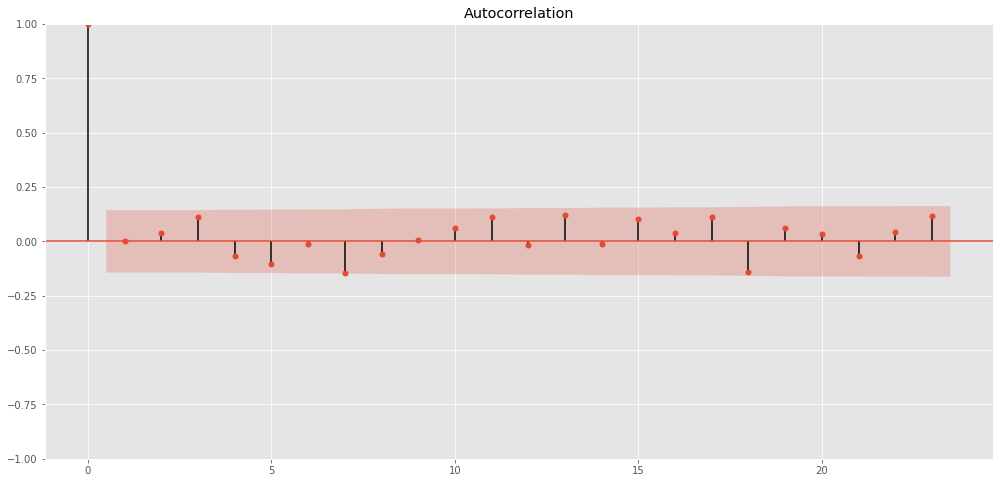

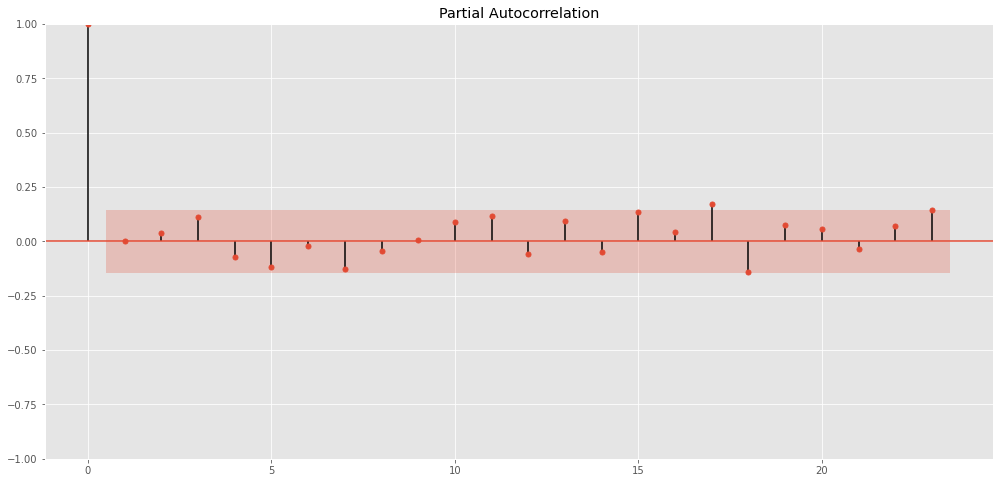

In [ ]:
acf_final = plot_acf(result_final_dum.resid,unbiased=False)
plt.show(acf_final)
pacf_final = plot_pacf(result_final_dum.resid)
plt.show(pacf_final)

De los gráficos anteriores vemos que el retardo 7 en el ACF y el retardo 17 en el PACF se salen de las bandas de correlación igual a 0. Sin embargo, no se rechaza la hipótesis nula del test de Ljung - Box, por lo que se puede confirmar la no autocorrelación en los residuales del modelo.

In [ ]:
len(result_final_dum.resid)/4 #46.75
np.sqrt(len(result_final_dum.resid)) #13.67
sm.stats.acorr_ljungbox(result_final_dum.resid, lags=[24],return_df=True)

46.75

13.674794331177344

lb_stat  lb_pvalue
24  32.861432   0.107031

In [ ]:
sp.stats.jarque_bera(result_final_dum.resid)

Jarque_beraResult(statistic=101.06304078458429, pvalue=0.0)

Sin embargo, se rechaza la hipótesis de normalidad para estos mismos residuales.

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM AR(7)')

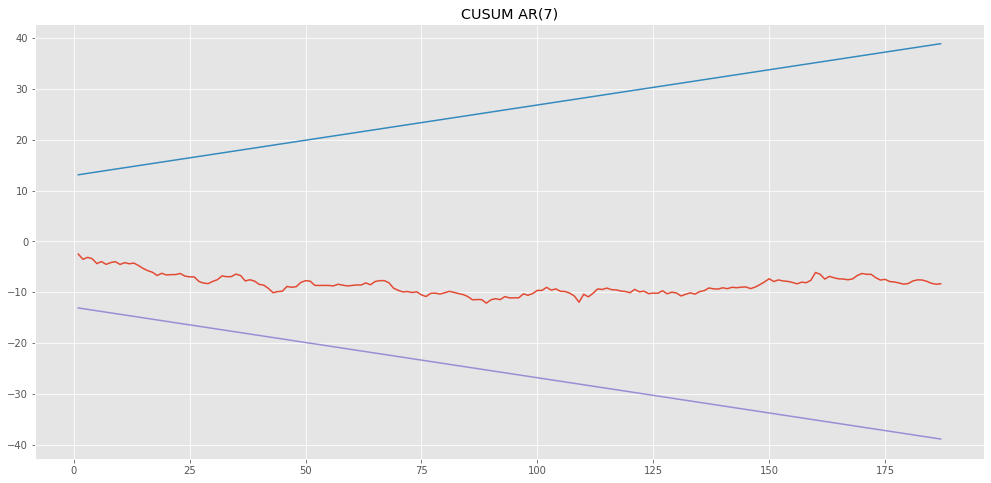

In [ ]:
cusum = result_final_dum.resid.cumsum()
N=len(result_final_dum.resid)
cusumsq = ((result_final_dum.resid.values)**2)
tiempo = np.array(range(1,len(result_final_dum.resid)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([result_final_dum.resid.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.13128####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM AR(7)")


Text(0.5, 1.0, 'CUSUM CUADRADO AR(7)')

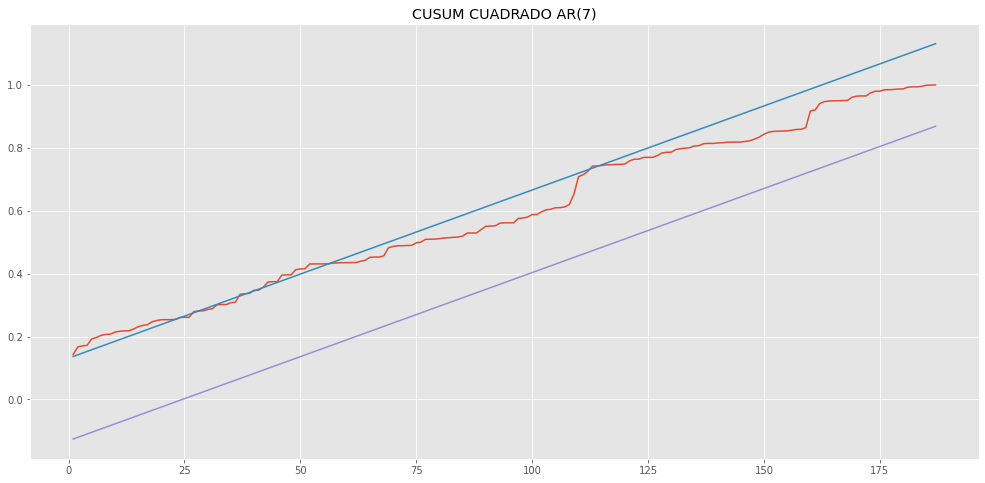

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO AR(7)")

Por los gráficos de las estadísticas CUSUM, parece haber estabilidad en los parámetros del modelo y en la varianza de los residuales.

### 6.2 Serie con los pronósticos a un año.

Habiendo hecho el análisis de los residuales, se muestran los pronósticos a un año obtenidos con sus respectivos intervalos de predicción.

2022-07-01    0.417105
2022-08-01    0.469518
2022-09-01    1.194119
2022-10-01    0.983826
2022-11-01   -0.019104
2022-12-01   -0.473411
2023-01-01   -0.924569
2023-02-01   -1.343332
2023-03-01   -0.800862
2023-04-01   -0.264779
2023-05-01    0.342923
2023-06-01    0.682624
Freq: MS, Name: predicted_mean, dtype: float64

lower y   upper y
2022-07-01 -0.508116  1.342325
2022-08-01 -0.466718  1.405754
2022-09-01  0.183350  2.204888
2022-10-01 -0.064901  2.032553
2022-11-01 -1.075556  1.037348
2022-12-01 -1.530243  0.583421
2023-01-01 -1.981471  0.132332
2023-02-01 -2.400389 -0.286275
2023-03-01 -1.857986  0.256261
2023-04-01 -1.321913  0.792356
2023-05-01 -0.714212  1.400058
2023-06-01 -0.374511  1.739759

Text(0.5, 1.0, 'Pronóstico hacia un año en el futuro')

Text(0.5, 0, 'Tiempo')

Text(0, 0.5, 'Serie sin tendencia')

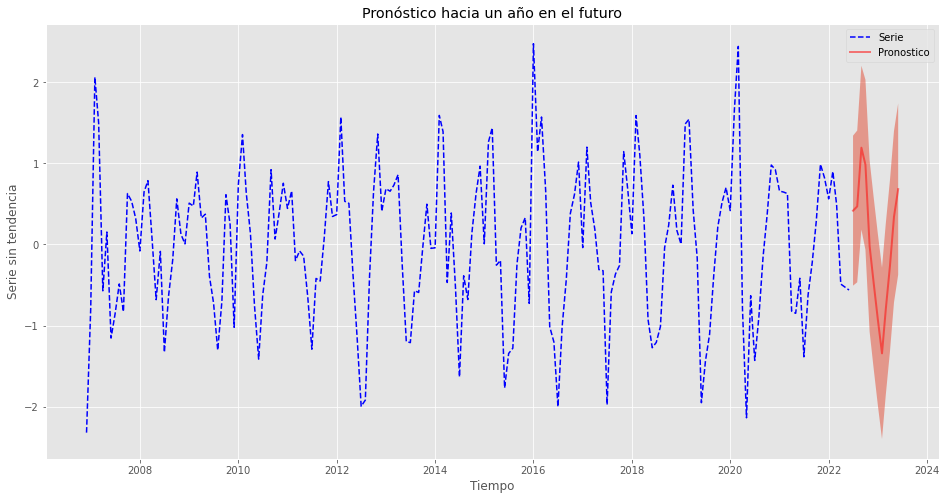

In [ ]:
indicepronosticos=pd.date_range(start='2022-07-01', periods=12, freq='M')
X_pro=Dummy.in_sample(indicepronosticos)

salforecast=result_final_dum.get_forecast(steps=12, exog=X_pro)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticos=salforecast.predicted_mean
pronosticos
ICforecast95

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1,1,1)
#Serie actual
ax.plot(Conta_sin_tend.astype('float64'), '--', color="blue", label='Serie')
# Pronóstico
ax.plot(pronosticos, lw=2, color="red", alpha=0.5, label='Pronostico')
ax.fill_between(pronosticos.index, ICforecast95.iloc[:, 0], ICforecast95.iloc[:, 1], alpha=0.5)
ax.legend(loc='upper right')
ax.set_title("Pronóstico hacia un año en el futuro")
ax.set_xlabel('Tiempo')
ax.set_ylabel('Serie sin tendencia')
plt.draw()

# Pruebas de raíces unitarias

Antes de empezar con la modelación se va a realizar la prueba de Dickey y Fuller establecer si se debe realizar diferenciación ordinaria.

In [ ]:
from statsmodels.tsa.stattools import adfuller
resultadoadf=adfuller(rContV,regression="nc")####maxlag es importante
##Se debe elegir un lagmax grande y ver si el valor t de el último coeficiente de la variable
###Diferenciada es significativo(>1.6 en valor absoluto), si así lo es se lleva a cabo el test de Dickey Fuller
###Si no lo es, hay que reducir el rezago.
print('ADF Statistic: %f' % resultadoadf[0])
print('P-value: %f' % resultadoadf[1])
for key, value in resultadoadf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(rContV,regression="nc",maxlag=12,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()
pvalue

###Al no rechazarse la hipótesis nula implica que existe raíz unitaria.

ADF Statistic: -2.875114
P-value: 0.003956
	1%: -2.579
	5%: -1.943
	10%: -1.615


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.481
Model:                            OLS   Adj. R-squared (uncentered):              0.439
Method:                 Least Squares   F-statistic:                              11.46
Date:                Thu, 01 Dec 2022   Prob (F-statistic):                    3.15e-17
Time:                        14:34:36   Log-Likelihood:                         -162.81
No. Observations:                 174   AIC:                                      351.6
Df Residuals:                     161   BIC:                                      392.7
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0197      0.005     -3.751      0.000      -0.030      -0.009
x2            -0.6378      0.077     -8.276      0.000      -0.790      -0.486
x3            -0.6836      0.088     -7.796      0.000      -0.857      -0.510
x4            -0.6065      0.090     -6.721      0.000      -0.785      -0.428
x5            -0.6812      0.087     -7.809      0.000      -0.853      -0.509
x6            -0.6786      0.087     -7.785      0.000      -0.851      -0.506
x7            -0.5961      0.086     -6.908      0.000      -0.766      -0.426
x8            -0.6946      0.086     -8.033      0.000      -0.865      -0.524
x9            -0.7178      0.087     -8.220      0.000      -0.890      -0.545
x10           -0.7032      0.089     -7.886      0.000      -0.879      -0.527
x11           -0.5853      0.092     -6.339      0.000      -0.768      -0.403
x12           -0.3495      0.084     -4.148      0.000      -0.516      -0.183
x13           -0.1188      0.073     -1.636      0.104      -0.262       0.025
==============================================================================
Omnibus:                        2.297   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.863
Skew:                          -0.205   Prob(JB):                        0.394
Kurtosis:                       3.297   Cond. No.                         47.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.00019156268773501322

Note que se rechaza la hipótesis de presencia de una raíz unitaria en la serie.

# Conjuntos de entrenamiento, validación y prueba.

In [ ]:
n = len(rContV)
train_df = rContV[0:int(n*0.7)]
val_df = rContV[int(n*0.7):int(n*0.9)]
test_df = rContV[int(n*0.9):]

# SARIMA

La serie no presenta raíz unitaria, sin embargo, como ya se confirmo la presencia de tendencia determinística, aparentemente de grado 1, esta se va a eliminar por medio de una difereciación ordinal en orden poder recuperar la tendecia a la hora de hacer predicciones.

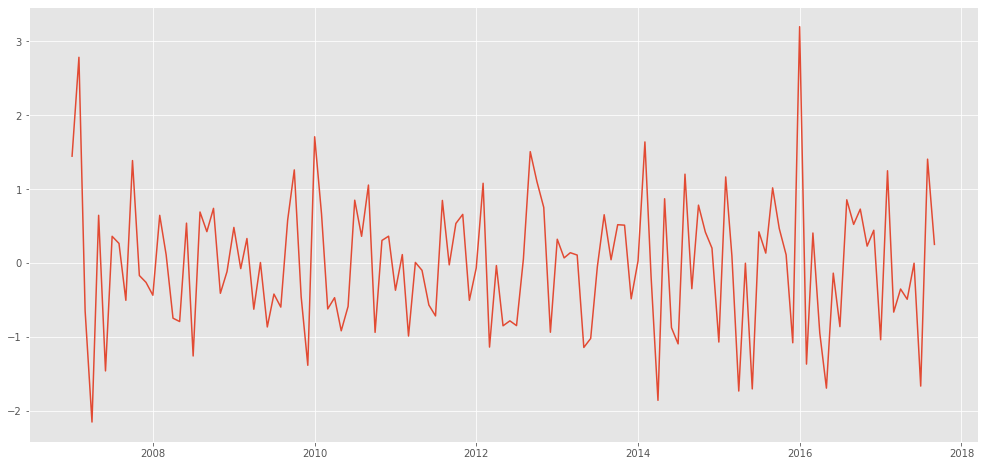

In [ ]:
diff=train_df.diff(periods=1)[1:]
plt.plot(diff)

Se evidencia que la serie difereciada ya no presenta tendecia, por lo que se confirma que esta tendencia era determinística de grado 1 y se estudia el conjunto de entrenamiento diferenciado.

Se muestran los gráficos de autocorrelación para verificar la estacionalidad vista en la serie.

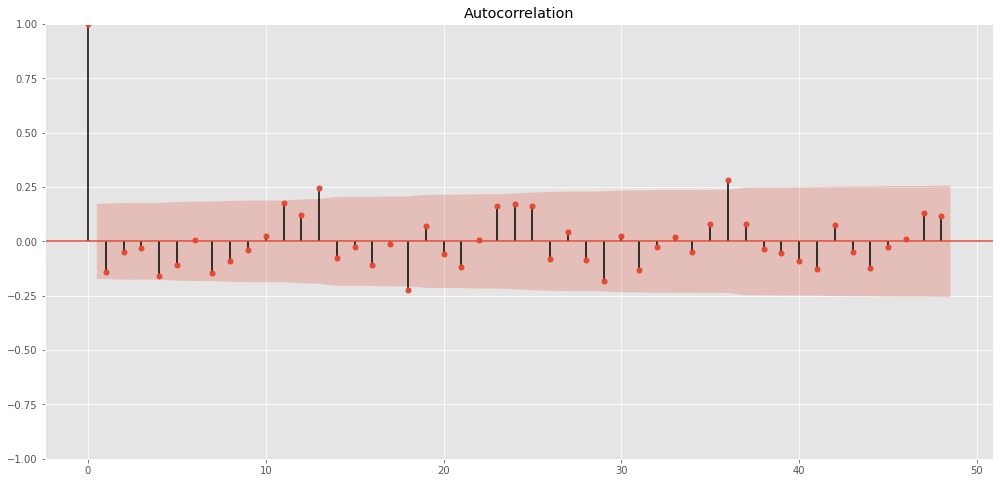

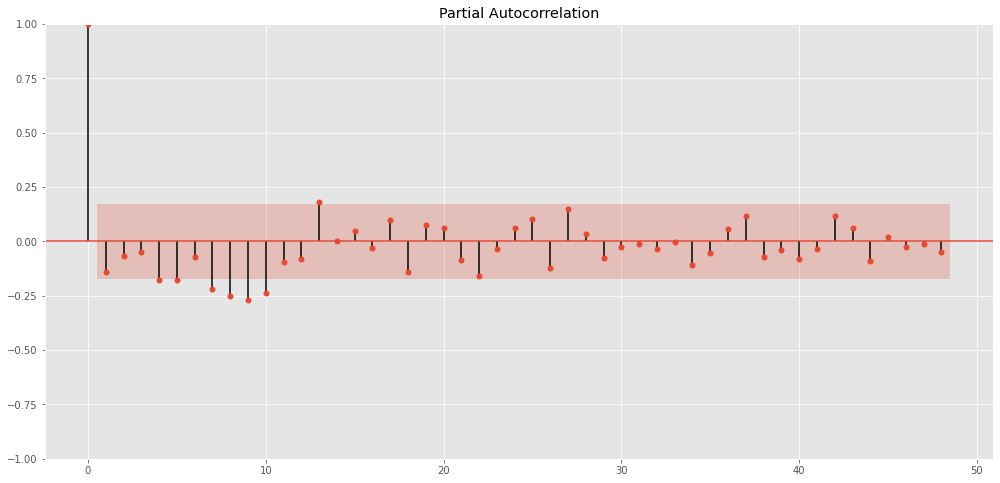

In [ ]:
acf_diff=plot_acf(diff,lags=48,unbiased=False)
pacf_diff=plot_pacf(diff,lags=48,method='ldbiased')

Difereciación estacional

Ahora, como se observó la presencia de estacionalidad de periodo 12 en la serie, se aplica una diferecnia estacional

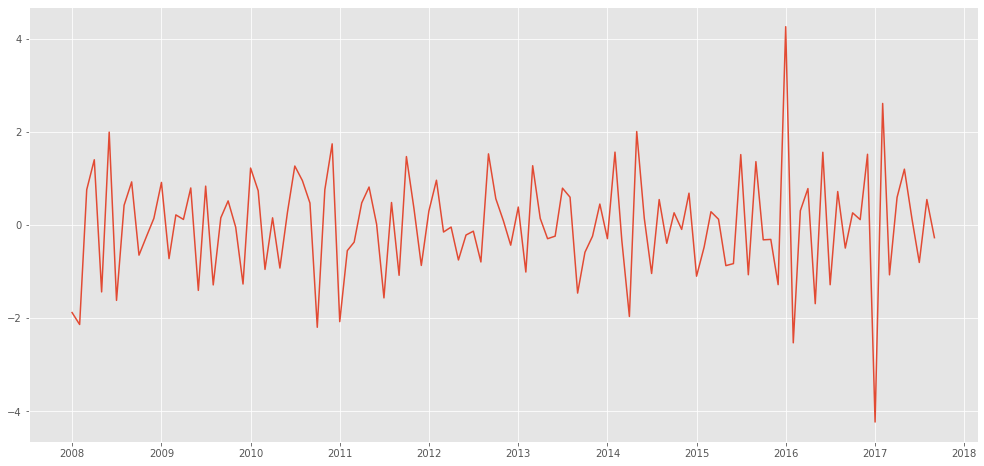

In [ ]:
diff_e=diff.diff(periods=12)[12:]
plt.plot(diff_e)

Se verifica que la serie diferenciada ahora es estacioanaria con gráficos y boxplot por meses

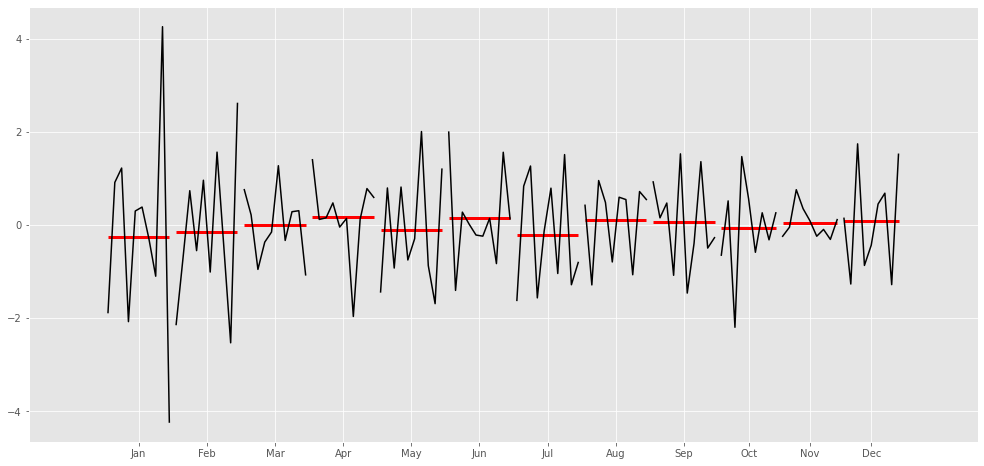

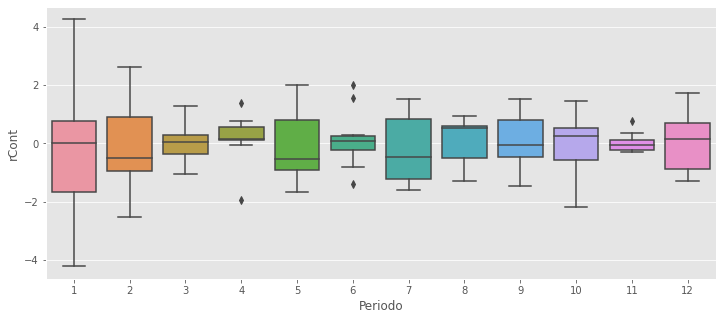

In [ ]:
import seaborn
fig = sm.graphics.tsa.month_plot(diff_e)
ig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(diff_e.index.month, diff_e, ax=ax)

Ahora, se observan los gráficos de autocorrelación para establecer los posibles órdenes p, q , P y Q.

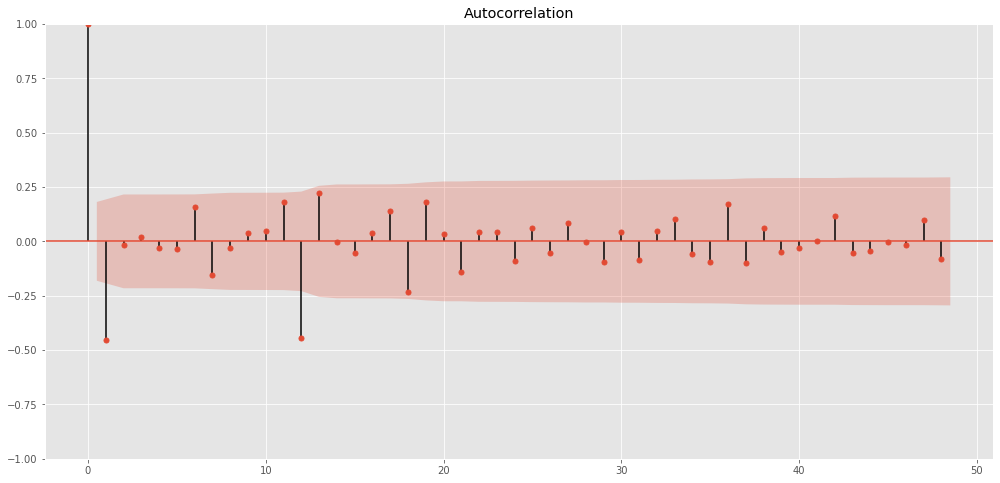

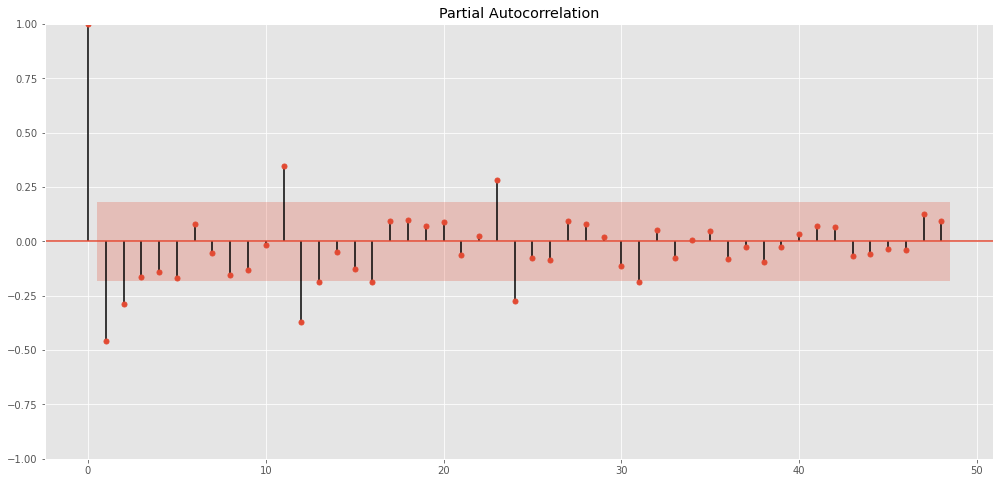

In [ ]:
acf_dd=plot_acf(diff_e,lags=48,unbiased=False)
pacf_dd=plot_pacf(diff_e,lags=48)

Se observa que los rezagos de autocorrelación simple signifativa son el 1 y el 12, mientras que en la gráfica de la autocorrelación parcial se salen los rezagos 12 y 24, dos múltiplos del periodo, así como en 1, el 2 y 11 antes del primer periodo.

Segpun esto, los posibles órdenes para un modelo SARIMA son:
Q=1, P=2, q=1 y p=2.

### Propuestas de modelos

Se propondrán 4 modelos SARIMA para que sean posteriormente contrastados por su ECM y escoger un modelo de esta familia.

In [ ]:
modelo1 = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(0,1,1), seasonal_order=(2,1,0,12))
results_1 = modelo1.fit(use_boxcox=False)
print(results_1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               rCont   No. Observations:                  130
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -126.390
Date:                             Thu, 01 Dec 2022   AIC                            260.781
Time:                                     14:34:39   BIC                            271.830
Sample:                                 12-01-2006   HQIC                           265.267
                                      - 09-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8660      0.052    -16.810      0.000      -0.967      -0.765
ar.S.L12      -0.7605      

In [ ]:
modelo2 = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(2,1,0), seasonal_order=(2,1,0,12))
results_2 = modelo2.fit(use_boxcox=False)
print(results_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              rCont   No. Observations:                  130
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -133.472
Date:                            Thu, 01 Dec 2022   AIC                            276.944
Time:                                    14:34:39   BIC                            290.755
Sample:                                12-01-2006   HQIC                           282.551
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5888      0.095     -6.179      0.000      -0.776      -0.402
ar.L2         -0.3025      0.092   

In [ ]:
modelo3 = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(3,1,0), seasonal_order=(2,1,0,12),enforce_invertibility=False)
results_3 = modelo3.fit(use_boxcox=False)
print(results_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              rCont   No. Observations:                  130
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -131.547
Date:                            Thu, 01 Dec 2022   AIC                            275.095
Time:                                    14:34:40   BIC                            291.668
Sample:                                12-01-2006   HQIC                           281.823
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6476      0.095     -6.783      0.000      -0.835      -0.460
ar.L2         -0.4244      0.095   

In [ ]:
modelo4 = sm.tsa.statespace.SARIMAX(train_df, trend='n', order=(0,1,1), seasonal_order=(3,1,0,12),enforce_invertibility=False)
results_4 = modelo4.fit(use_boxcox=False)
print(results_4.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               rCont   No. Observations:                  130
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -125.047
Date:                             Thu, 01 Dec 2022   AIC                            260.094
Time:                                     14:34:41   BIC                            273.905
Sample:                                 12-01-2006   HQIC                           265.701
                                      - 09-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8722      0.052    -16.863      0.000      -0.974      -0.771
ar.S.L12      -0.8480      

### Selección de un modelo SARIMA

In [ ]:
## ECM sobre test del primer modelo
history = [x for x in train_df]
predicciones = list()

for t in range(len(val_df)):
 # aumento de la ventana
 history=[x for x in rContV[:len(train_df)+t]]
 # Ajuste Modelo 1
 modelo= sm.tsa.statespace.SARIMAX(history, trend='n', order=(0,1,1),seasonal_order=(2,1,0,12), enforce_invertibility=False)
 with modelo.fix_params({'ma.L1':-0.8660,'ar.S.L12':-0.7605,'ar.S.L24':-0.5116}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 yhat = output[0]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat,val_df[t]))

#reescalar
 predicciones_inv=sp.special.inv_boxcox(predicciones,0.433)
 val_inv=sp.special.inv_boxcox(val_df,0.433)

error = np.sqrt(mean_squared_error(val_inv,predicciones_inv))
print('sqrt(ECM): %.3f' % error)

Predicción=9.414411, Esperado=9.098388
Predicción=9.671106, Esperado=10.470846
Predicción=9.721668, Esperado=9.923461
Predicción=9.751511, Esperado=9.341956
Predicción=10.253182, Esperado=10.785038
Predicción=10.318736, Esperado=10.255636
Predicción=9.107910, Esperado=9.461276
Predicción=8.618245, Esperado=8.186648
Predicción=7.657786, Esperado=7.762297
Predicción=7.277716, Esperado=7.762297
Predicción=7.962781, Esperado=7.906316
Predicción=8.667887, Esperado=8.847813
Predicción=9.143275, Esperado=9.098388
Predicción=9.581478, Esperado=9.579033
Predicción=9.010651, Esperado=8.974012
Predicción=10.244657, Esperado=8.719717
Predicción=9.999382, Esperado=10.146199
Predicción=9.936655, Esperado=10.146199
Predicción=9.204996, Esperado=8.974012
Predicción=7.883554, Esperado=8.323205
Predicción=7.772128, Esperado=6.496581
Predicción=6.749197, Esperado=6.997754
Predicción=7.605710, Esperado=7.313135
Predicción=8.123677, Esperado=8.047724
Predicción=8.578562, Esperado=8.589642
Predicción=9.1549

In [ ]:
## ECM sobre test del segundo modelo
history = [x for x in train_df]
predicciones = list()

for t in range(len(val_df)):
 # aumento de la ventana
 history=[x for x in rContV[:len(train_df)+t]]
 # Ajuste Modelo 1
 modelo= sm.tsa.statespace.SARIMAX(history, trend='n', order=(2,1,0),seasonal_order=(2,1,0,12), enforce_invertibility=False)
 with modelo.fix_params({'ar.L1':-0.5888,'ar.L2':-0.3025,'ar.S.L12':-0.8121,'ar.S.L24':-0.5107}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 yhat = output[0]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat,val_df[t]))

#reescalar
 predicciones_inv=sp.special.inv_boxcox(predicciones,0.433)
 val_inv=sp.special.inv_boxcox(val_df,0.433)

error = np.sqrt(mean_squared_error(val_inv,predicciones_inv))
print('sqrt(ECM): %.3f' % error)

Predicción=9.460486, Esperado=9.098388
Predicción=9.710382, Esperado=10.470846
Predicción=9.866693, Esperado=9.923461
Predicción=10.063912, Esperado=9.341956
Predicción=10.360617, Esperado=10.785038
Predicción=10.475999, Esperado=10.255636
Predicción=9.054619, Esperado=9.461276
Predicción=8.778044, Esperado=8.186648
Predicción=7.542919, Esperado=7.762297
Predicción=7.327588, Esperado=7.762297
Predicción=8.000091, Esperado=7.906316
Predicción=8.789507, Esperado=8.847813
Predicción=9.339506, Esperado=9.098388
Predicción=9.555431, Esperado=9.579033
Predicción=9.075331, Esperado=8.974012
Predicción=10.208235, Esperado=8.719717
Predicción=9.560713, Esperado=10.146199
Predicción=9.631029, Esperado=10.146199
Predicción=8.910714, Esperado=8.974012
Predicción=7.954665, Esperado=8.323205
Predicción=7.954678, Esperado=6.496581
Predicción=6.365446, Esperado=6.997754
Predicción=7.546650, Esperado=7.313135
Predicción=7.736782, Esperado=8.047724
Predicción=8.553717, Esperado=8.589642
Predicción=9.097

In [ ]:
## ECM sobre test del tercer modelo
history = [x for x in train_df]
predicciones = list()

for t in range(len(val_df)):
 # aumento de la ventana
 history=[x for x in rContV[:len(train_df)+t]]
 # Ajuste Modelo 1
 modelo= sm.tsa.statespace.SARIMAX(history, trend='n', order=(3,1,0),seasonal_order=(2,1,0,12), enforce_invertibility=False)
 with modelo.fix_params({'ar.L1':-0.6476,'ar.L2':-0.4244,'ar.L3':-0.1925,'ar.S.L12':-0.7938,'ar.S.L24':-0.5038}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 yhat = output[0]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat,val_df[t]))

#reescalar
 predicciones_inv=sp.special.inv_boxcox(predicciones,0.433)
 val_inv=sp.special.inv_boxcox(val_df,0.433)

error = np.sqrt(mean_squared_error(val_inv,predicciones_inv))
print('sqrt(ECM): %.3f' % error)

Predicción=9.596143, Esperado=9.098388
Predicción=9.629530, Esperado=10.470846
Predicción=9.886329, Esperado=9.923461
Predicción=10.028083, Esperado=9.341956
Predicción=10.257642, Esperado=10.785038
Predicción=10.578775, Esperado=10.255636
Predicción=9.127789, Esperado=9.461276
Predicción=8.645165, Esperado=8.186648
Predicción=7.664153, Esperado=7.762297
Predicción=7.289558, Esperado=7.762297
Predicción=8.057467, Esperado=7.906316
Predicción=8.673550, Esperado=8.847813
Predicción=9.300550, Esperado=9.098388
Predicción=9.644190, Esperado=9.579033
Predicción=9.057421, Esperado=8.974012
Predicción=10.228003, Esperado=8.719717
Predicción=9.648156, Esperado=10.146199
Predicción=9.738422, Esperado=10.146199
Predicción=9.005675, Esperado=8.974012
Predicción=7.678668, Esperado=8.323205
Predicción=7.941833, Esperado=6.496581
Predicción=6.492206, Esperado=6.997754
Predicción=7.544173, Esperado=7.313135
Predicción=7.925519, Esperado=8.047724
Predicción=8.335612, Esperado=8.589642
Predicción=9.168

In [ ]:
## ECM sobre test del cuarto modelo
history = [x for x in train_df]
predicciones = list()

for t in range(len(val_df)):
 # aumento de la ventana
 history=[x for x in rContV[:len(train_df)+t]]
 # Ajuste Modelo 1
 modelo= sm.tsa.statespace.SARIMAX(history, trend='n', order=(0,1,1),seasonal_order=(3,1,0,12), enforce_invertibility=False)
 with modelo.fix_params({'ma.L1':-0.8722,'ar.S.L12':-0.8480,'ar.S.L24':-0.6432,'ar.S.L36':-0.1857}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1)
 yhat = output[0]
 predicciones.append(yhat)
 print('Predicción=%f, Esperado=%f' % (yhat,val_df[t]))

#reescalar
 predicciones_inv=sp.special.inv_boxcox(predicciones,0.433)
 val_inv=sp.special.inv_boxcox(val_df,0.433)

error = np.sqrt(mean_squared_error(val_inv,predicciones_inv))
print('sqrt(ECM): %.3f' % error)

Predicción=9.386212, Esperado=9.098388
Predicción=9.695982, Esperado=10.470846
Predicción=9.646420, Esperado=9.923461
Predicción=9.697913, Esperado=9.341956
Predicción=10.401090, Esperado=10.785038
Predicción=10.444013, Esperado=10.255636
Predicción=9.038962, Esperado=9.461276
Predicción=8.834832, Esperado=8.186648
Predicción=7.785399, Esperado=7.762297
Predicción=7.346071, Esperado=7.762297
Predicción=8.074659, Esperado=7.906316
Predicción=8.601356, Esperado=8.847813
Predicción=9.161415, Esperado=9.098388
Predicción=9.539382, Esperado=9.579033
Predicción=9.098289, Esperado=8.974012
Predicción=10.046965, Esperado=8.719717
Predicción=9.945358, Esperado=10.146199
Predicción=9.960487, Esperado=10.146199
Predicción=9.039537, Esperado=8.974012
Predicción=7.965049, Esperado=8.323205
Predicción=7.569378, Esperado=6.496581
Predicción=6.778696, Esperado=6.997754
Predicción=7.534242, Esperado=7.313135
Predicción=8.130363, Esperado=8.047724
Predicción=8.604824, Esperado=8.589642
Predicción=9.0837

El modelo que minimiza el error cuadrático medio es el cuarto, luego ese será el modelo final para esta familia.

### Ajuste del modelo final SARIMA

Se unifican los conjuntos de entrenamiento y validación

In [ ]:
train = rContV[0:int(n*0.9)]

Ahora se ajusta el modelo en el conjunto unificado

In [ ]:
modelo_S = sm.tsa.statespace.SARIMAX(train, trend='n', order=(0,1,1), seasonal_order=(3,1,0,12))
results_S = modelo_S.fit(use_boxcox=False)
print(results_S.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               rCont   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -157.967
Date:                             Thu, 01 Dec 2022   AIC                            325.933
Time:                                     14:35:24   BIC                            341.151
Sample:                                 12-01-2006   HQIC                           332.114
                                      - 11-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8936      0.041    -21.765      0.000      -0.974      -0.813
ar.S.L12      -0.8306      

## Modelamiento de outliers

In [ ]:
#ruta = "/content/drive/Shareddrives/Series/rContV.csv"
#rContV.to_csv(ruta)

In [ ]:
regresoras = pd.read_csv("/content/drive/Shareddrives/Series/regresoras.csv")
regresoras = regresoras[['AO46','AO52','AO110','AO162','LS70','AO15','AO161']]
regresoras = regresoras.to_numpy()
regresoras

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
modelo_F = sm.tsa.statespace.SARIMAX(train, trend='n', order=(0,1,1), seasonal_order=(3,1,0,12), enforce_invertibility=False, exog=regresoras)
results_F = modelo_F.fit(use_boxcox=False)
print(results_F.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               rCont   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -122.114
Date:                             Thu, 01 Dec 2022   AIC                            268.228
Time:                                     14:36:20   BIC                            304.749
Sample:                                 12-01-2006   HQIC                           283.062
                                      - 11-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7789      1.053      1.689      0.091      -0.285       3.843
x2            -1.5510      

In [ ]:
import math

## ECM sobre test
history = [x for x in train]
predicciones = list()
regr = np.array([0,0,0,0,1,0,0])

for t in range(len(test_df)):
 # aumento de la ventana
 history=[x for x in rContV[:len(train)+t]]
 # Ajuste Modelo 1
 modelo= sm.tsa.statespace.SARIMAX(history, trend='n', order=(0,1,1),seasonal_order=(3,1,0,12), enforce_invertibility=False, exog=regresoras)
 with modelo.fix_params({'x1':1.7789,'x2':-1.5510,'x3':2.3061,'x4':-1.8743,'x5':0.6642,'x6':-0.6101,'x7':-1.4660,'ma.L1':-0.9136,'ar.S.L12':-0.8980,'ar.S.L24':-0.7739, 'ar.S.L36':-0.2832}):
  modelo_fit=modelo.fit(disp=0)
 output = modelo_fit.forecast(steps=1, exog=regr)
 yhat = output[0]
 predicciones.append(yhat)
 row_n = regresoras.shape[0] ##last row
 regresoras = np.insert(regresoras,row_n,[regr],axis= 0)
 #reescalar
 predicciones_inv=sp.special.inv_boxcox(predicciones,0.433)
 test_inv=sp.special.inv_boxcox(test_df,0.433)

error = mean_squared_error(test_inv,predicciones_inv)
print('ECM: %.3f' % error)
sqerror = np.sqrt(mean_squared_error(test_inv,predicciones_inv))
print('sqrt(ECM): %.3f' % sqerror)


ECM: 23.400
sqrt(ECM): 4.837


##Verificación de supuestos

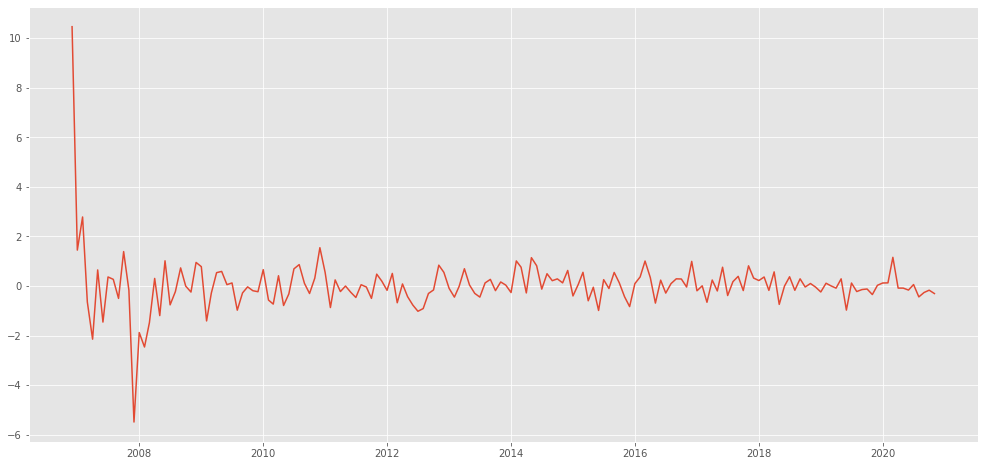

In [ ]:
residuos_F=results_F.resid
plt.plot(residuos_F)

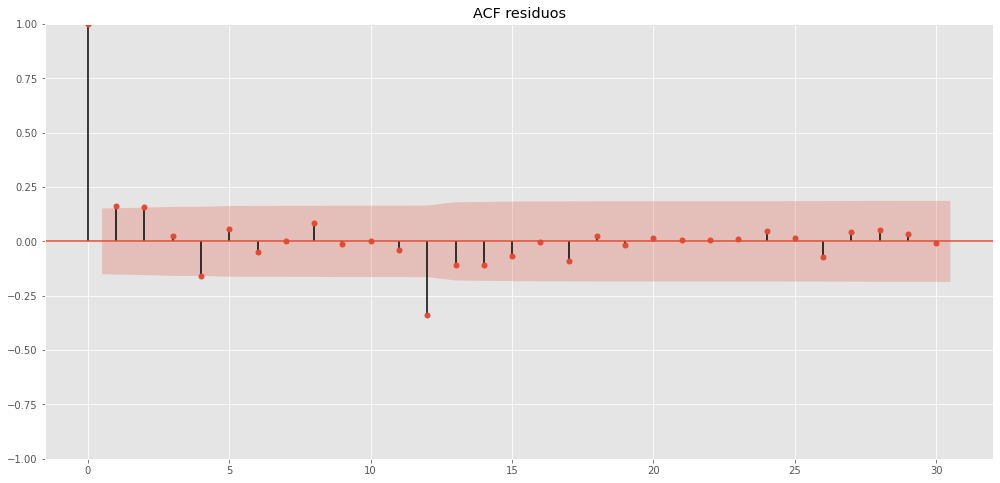

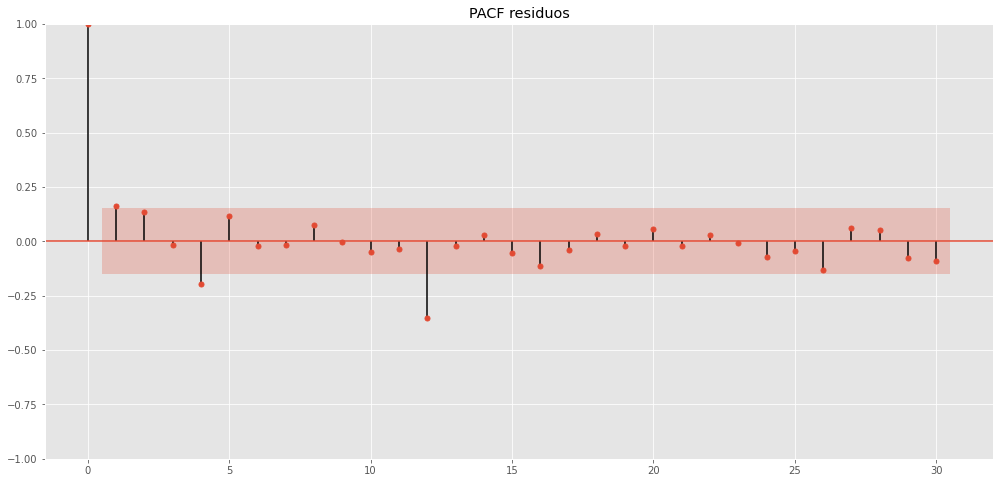

In [ ]:
acf_res1 = plot_acf(residuos_F,unbiased=False,lags=30,title='ACF residuos')
plt.show(acf_res1)
pacf_res1 = plot_pacf(residuos_F,lags=30,title='PACF residuos')
plt.show(pacf_res1)

***Prueba de autocorrelación global cero***

In [ ]:
len(residuos_F)/4 #42
sm.stats.acorr_ljungbox(residuos_F, lags=[42],return_df=True)

42.0

lb_stat  lb_pvalue
42  50.431546   0.174531

***Prueba de normalidad***

In [ ]:
 sp.stats.jarque_bera(residuos_F)

Jarque_beraResult(statistic=15158.066639108805, pvalue=0.0)

(array([  1.,   1.,  18., 136.,  10.,   1.,   0.,   0.,   0.,   1.]),
 array([-5.48888192, -3.8939739 , -2.29906588, -0.70415786,  0.89075016,
         2.48565817,  4.08056619,  5.67547421,  7.27038223,  8.86529025,
        10.46019827]),
 <a list of 10 Patch objects>)

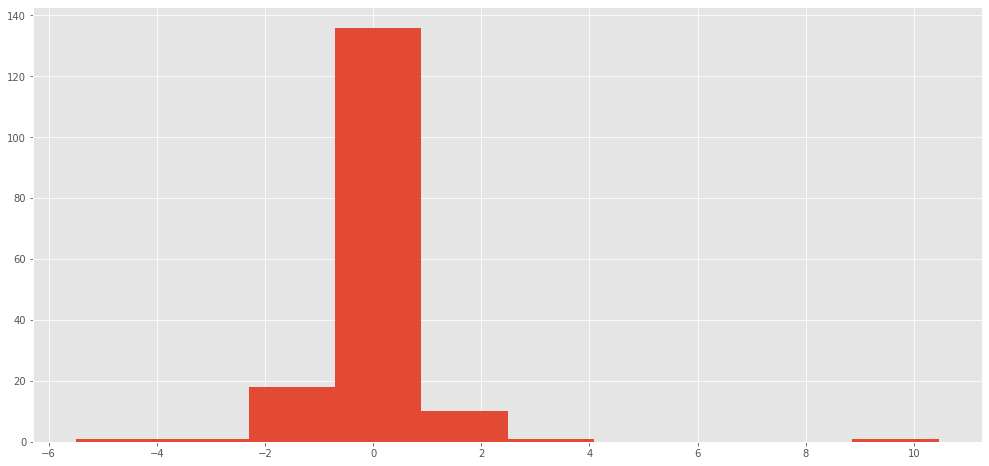

In [ ]:
plt.hist(residuos_F)

#### Análisis de Estabilidad

Text(0.5, 1.0, 'CUSUM')

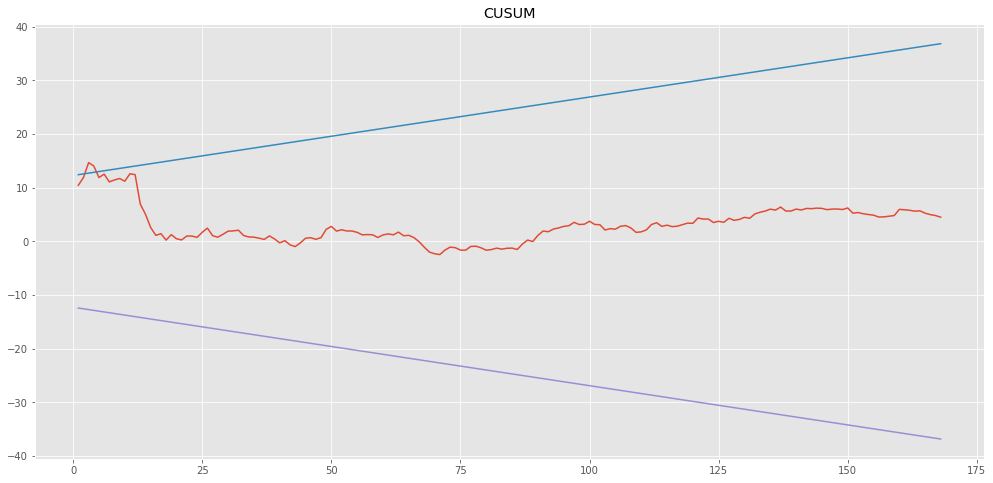

In [ ]:
cusum = results_F.resid.cumsum()
N=len(results_F.resid)
cusumsq = ((results_F.resid.values)**2)
tiempo = np.array(range(1,len(results_F.resid)+1))
cumq=cusumsq.cumsum()/np.sum(np.array([results_F.resid.values])**2)
Af=0.948 ###Cuantil del 95% para la estad?stica cusum
co=0.8959####Valor del cuantil aproximado para cusumsq para n/2
LS= Af*np.sqrt(N)+2*Af*tiempo/np.sqrt(N)
LI=-LS
LQS= co + tiempo/N
LQI=-co + tiempo/N

plt.plot(tiempo,cusum)
plt.plot(tiempo,LS)
plt.plot(tiempo,LI)
plt.title("CUSUM")


Text(0.5, 1.0, 'CUSUM CUADRADO')

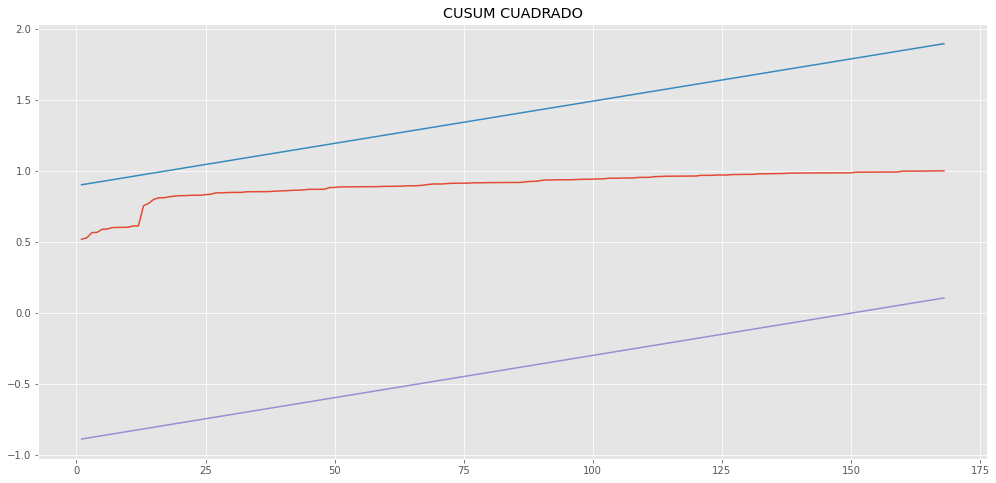

In [ ]:
plt.plot(tiempo,cumq)
plt.plot(tiempo,LQS)
plt.plot(tiempo,LQI)
plt.title("CUSUM CUADRADO")

Por los gráficos de las estadísticas CUSUM, parece haber estabilidad en los parámetros del modelo y en la varianza de los residuales.

# Maching Learning


## Redes Multicapa (MLP)

### Importacion De Datos

In [ ]:
Cont = pd.read_csv('/content/drive/Shareddrives/Series/OAB-PM10PM.csv')
print(Cont)

     Periodo       Valor
0    2006-12   51.900002
1    2007-01   66.500000
2    2007-02  100.500000
3    2007-03   91.900002
4    2007-04   66.400002
..       ...         ...
182  2022-02   41.000000
183  2022-03   38.000000
184  2022-04   31.000000
185  2022-05   31.000000
186  2022-06   31.000000

[187 rows x 2 columns]


Periodo
2006-12-01     51.900002
2007-01-01     66.500000
2007-02-01    100.500000
2007-03-01     91.900002
2007-04-01     66.400002
                 ...    
2022-02-01     41.000000
2022-03-01     38.000000
2022-04-01     31.000000
2022-05-01     31.000000
2022-06-01     31.000000
Name: Valor, Length: 187, dtype: float64


Text(0.5, 1.0, 'Concentración de material particulado inferior a 10 micras')

Text(0, 0.5, '$\\mu g/m^3$')

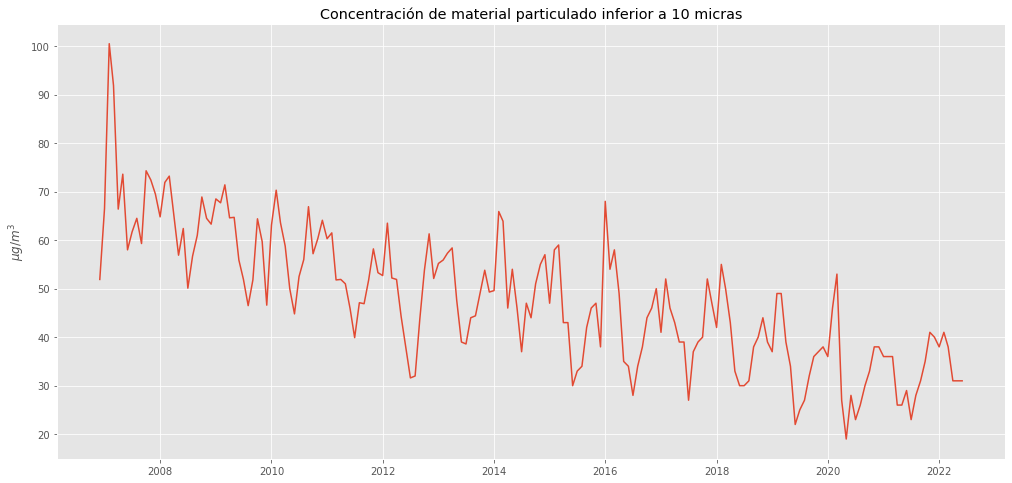

In [ ]:
Cont['Periodo']=pd.to_datetime(Cont['Periodo']) # pasar a formato fecha
Valores_cont=Cont.set_index('Periodo') # nuevo dataframe indexado por la fecha
cont_ts=Valores_cont['Valor'] # vector con los valores de la serie
print(cont_ts)

plt.plot(cont_ts)
plt.title('Concentración de material particulado inferior a 10 micras')
plt.ylabel('$\mu g/m^3$')
plt.show()

In [ ]:
Valores_cont.head() #Valores_cont es features, el nombre de la columna es Valor

Valor
Periodo               
2006-12-01   51.900002
2007-01-01   66.500000
2007-02-01  100.500000
2007-03-01   91.900002
2007-04-01   66.400002

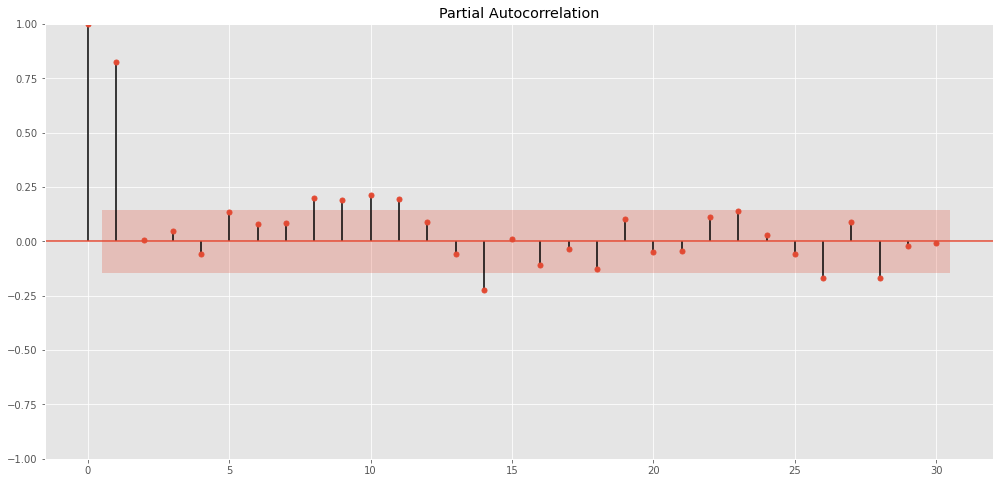

In [ ]:
pacf_diff=plot_pacf(cont_ts,lags=30,method='ldbiased')

###Separacion(Entrenamiento-Validación-Prueba) y Normalización.

In [ ]:
from pandas import DataFrame

SerieOri=pd.DataFrame(Valores_cont['Valor'])
dfConta=DataFrame()

for i in range(12,0,-1):
    dfConta[['t-'+str(i)]] = SerieOri.shift(i)

#dfRetail['Year sin']= Retail['Year sin']
#dfRetail['Year cos']= Retail['Year cos']

dfConta['t'] = SerieOri.values

dfConta

t-12  t-11  t-10   t-9   t-8   t-7   t-6   t-5        t-4  \
Periodo                                                                 
2006-12-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN        NaN   
2007-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN        NaN   
2007-02-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN        NaN   
2007-03-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN        NaN   
2007-04-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  51.900002   
...          ...   ...   ...   ...   ...   ...   ...   ...        ...   
2022-02-01  36.0  36.0  26.0  26.0  29.0  23.0  28.0  31.0  35.000000   
2022-03-01  36.0  26.0  26.0  29.0  23.0  28.0  31.0  35.0  41.000000   
2022-04-01  26.0  26.0  29.0  23.0  28.0  31.0  35.0  41.0  40.000000   
2022-05-01  26.0  29.0  23.0  28.0  31.0  35.0  41.0  40.0  38.000000   
2022-06-01  29.0  23.0  28.0  31.0  35.0  41.0  40.0  38.0  41.000000   

                  t-3         t-2         t-1           t  
Periodo                                                    
2006-12-01        NaN         NaN         NaN   51.900002  
2007-01-01        NaN         NaN   51.900002   66.500000  
2007-02-01        NaN   51.900002   66.500000  100.500000  
2007-03-01  51.900002   66.500000  100.500000   91.900002  
2007-04-01  66.500000  100.500000   91.900002   66.400002  
...               ...         ...         ...         ...  
2022-02-01  41.000000   40.000000   38.000000   41.000000  
2022-03-01  40.000000   38.000000   41.000000   38.000000  
2022-04-01  38.000000   41.000000   38.000000   31.000000  
2022-05-01  41.000000   38.000000   31.000000   31.000000  
2022-06-01  38.000000   31.000000   31.000000   31.000000  

[187 rows x 13 columns]

Definimos aquí las covariables y rezagos a tener en cuenta.

In [ ]:
dfConta_corta = dfConta[12:]
print(dfConta_corta.head(12))
dfConta_corta.shape

CortasplitConta = dfConta_corta.values
XConta = CortasplitConta[:, 0:-1]
yConta = CortasplitConta[:,-1]

                  t-12        t-11        t-10        t-9        t-8  \
Periodo                                                                
2007-12-01   51.900002   66.500000  100.500000  91.900002  66.400002   
2008-01-01   66.500000  100.500000   91.900002  66.400002  73.599998   
2008-02-01  100.500000   91.900002   66.400002  73.599998  58.000000   
2008-03-01   91.900002   66.400002   73.599998  58.000000  61.700001   
2008-04-01   66.400002   73.599998   58.000000  61.700001  64.500000   
2008-05-01   73.599998   58.000000   61.700001  64.500000  59.299999   
2008-06-01   58.000000   61.700001   64.500000  59.299999  74.300003   
2008-07-01   61.700001   64.500000   59.299999  74.300003  72.400002   
2008-08-01   64.500000   59.299999   74.300003  72.400002  69.500000   
2008-09-01   59.299999   74.300003   72.400002  69.500000  64.800000   
2008-10-01   74.300003   72.400002   69.500000  64.800000  71.900000   
2008-11-01   72.400002   69.500000   64.800000  71.900000  73.20

(175, 13)

Asignamos los datos de entrenamiento, validación y prueba en los mismos límites considerados para el modelo SARIMA

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

XCon_train=XConta[0:118]
XCon_val=XConta[118:156]
XCon_test=XConta[156:]
XCon_train_full=XConta[0:156]

yCon_train=yConta[0:118]
yCon_val=yConta[118:156]
yCon_test=yConta[156:]
yCon_train_full=yConta[0:156]

scaler=MinMaxScaler()
XCon_train=scaler.fit_transform(XCon_train)
XCon_val=scaler.transform(XCon_val)
XCon_test=scaler.transform(XCon_test)
XCon_train_full=scaler.transform(XCon_train_full)

print('Observations for feature: %d' % (len(cont_ts)))
print('Training Observations for feature: %d' % (len(XCon_train)))
print('Validation Observations for feature: %d' % (len(XCon_val)))
print('Testing Observations for feature: %d' % (len(XCon_test)))

Observations for feature: 187
Training Observations for feature: 118
Validation Observations for feature: 38
Testing Observations for feature: 19


In [ ]:
tf.random.set_seed(123)
#Intento 1: MSE=35.65
#input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
#hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
#hidden2 = keras.layers.Dense(32,activation="relu")(hidden1)
#output_layer = keras.layers.Dense(1, activation='relu')(hidden2)

#Intento 2: MSE=31.06
#input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
#hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
#hidden2 = keras.layers.Dense(64,activation="relu")(hidden1)
#output_layer = keras.layers.Dense(1, activation='relu')(hidden2)

#Intento 3: MSE=26.79
#input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
#hidden1 = keras.layers.Dense(128,activation="relu")(input_layer)
#hidden2 = keras.layers.Dense(128,activation="relu")(hidden1)
#output_layer = keras.layers.Dense(1, activation='relu')(hidden2)

#Intento 4: MSE=26.51
input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(64,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(64,activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, activation='relu')(hidden3)

#Intento 5: MSE=27.18
#input_layer = keras.layers.Input(shape=XCon_train.shape[1:])
#hidden1 = keras.layers.Dense(256,activation="relu")(input_layer)
#hidden2 = keras.layers.Dense(256,activation="relu")(hidden1)
#output_layer = keras.layers.Dense(1, activation='relu')(hidden2)

ts_model=keras.Model(inputs=[input_layer],outputs=[output_layer])
ts_model.summary()
ts_model.compile(loss="mean_squared_error",optimizer="adam")
history=ts_model.fit(XCon_train,yCon_train,epochs=50,batch_size=5,validation_data=(XCon_val,yCon_val))

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 12)]              0         
                                                                 
 dense_323 (Dense)           (None, 64)                832       
                                                                 
 dense_324 (Dense)           (None, 64)                4160      
                                                                 
 dense_325 (Dense)           (None, 64)                4160      
                                                                 
 dense_326 (Dense)           (None, 1)                 65        
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
24/24 [==============================] - 1s 7

In [ ]:
mse_test=ts_model.evaluate(XCon_val,yCon_val)

2/2 [==============================] - 0s 4ms/step - loss: 26.5189


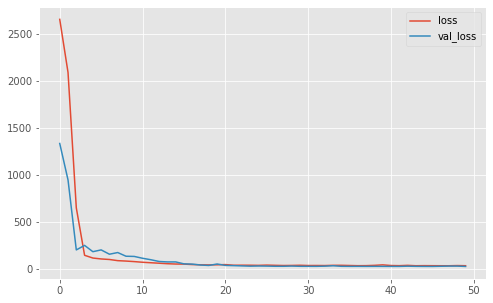

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
ypred=ts_model.predict(XCon_val)
print(ypred)
len(ypred)

2/2 [==============================] - 0s 6ms/step
[[40.100235]
 [42.008   ]
 [46.050514]
 [45.724068]
 [47.210026]
 [45.227547]
 [43.921043]
 [39.57351 ]
 [30.348135]
 [28.858515]
 [33.50949 ]
 [34.9777  ]
 [39.74823 ]
 [42.485374]
 [45.23887 ]
 [45.006165]
 [45.15635 ]
 [44.10658 ]
 [41.43716 ]
 [35.199112]
 [29.655895]
 [26.64448 ]
 [29.588205]
 [31.79838 ]
 [35.23236 ]
 [37.75737 ]
 [38.896004]
 [43.31199 ]
 [43.714287]
 [43.59732 ]
 [41.10238 ]
 [30.443705]
 [22.399307]
 [24.164946]
 [28.732916]
 [30.172697]
 [30.067152]
 [36.790405]]


38

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Contaminación')

Text(0, 0.5, 'Micras')

Text(0.5, 0, 'Index')

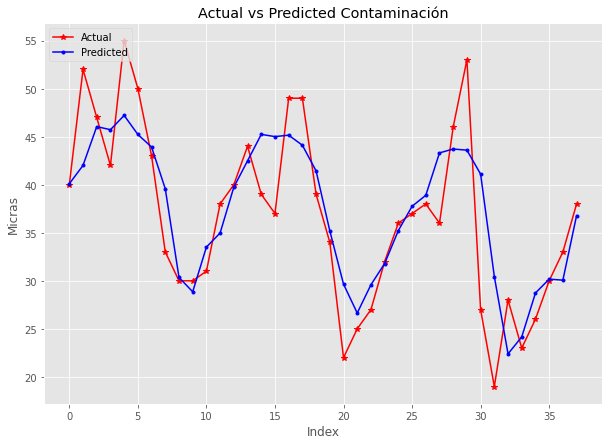

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(range(yCon_val.size), yCon_val, linestyle='-', marker='*', color='r')
plt.plot(range(ypred.size), ypred, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Contaminación')
plt.ylabel('Micras')
plt.xlabel('Index')

### Reajuste final

In [ ]:
tf.random.set_seed(123)

input_layer = keras.layers.Input(shape=XCon_train_full.shape[1:])
hidden1 = keras.layers.Dense(64,activation="relu")(input_layer)
hidden2 = keras.layers.Dense(64,activation="relu")(hidden1)
hidden3 = keras.layers.Dense(64,activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, activation='relu')(hidden3)

ts_model_full=keras.Model(inputs=[input_layer],outputs=[output_layer])
ts_model_full.summary()
ts_model_full.compile(loss="mean_squared_error",optimizer="adam")
history=ts_model_full.fit(XCon_train_full,yCon_train_full,epochs=50,batch_size=5,validation_data=(XCon_test,yCon_test))

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 12)]              0         
                                                                 
 dense_331 (Dense)           (None, 64)                832       
                                                                 
 dense_332 (Dense)           (None, 64)                4160      
                                                                 
 dense_333 (Dense)           (None, 64)                4160      
                                                                 
 dense_334 (Dense)           (None, 1)                 65        
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - 1s 8

In [ ]:
mse_test=ts_model_full.evaluate(XCon_test,yCon_test)

1/1 [==============================] - 0s 18ms/step - loss: 13.8042


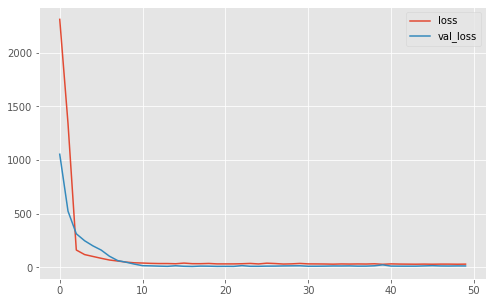

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
ypred=ts_model.predict(XCon_test)
print(ypred)
len(ypred)

1/1 [==============================] - 0s 26ms/step
[[40.87983 ]
 [42.083817]
 [42.905685]
 [37.049934]
 [30.220598]
 [25.68789 ]
 [24.92621 ]
 [25.349699]
 [26.51277 ]
 [29.508352]
 [32.357132]
 [37.850502]
 [39.076653]
 [38.976746]
 [37.756756]
 [35.1677  ]
 [32.547005]
 [29.2567  ]
 [26.835468]]


19

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted Contaminación')

Text(0, 0.5, 'Micras')

Text(0.5, 0, 'Index')

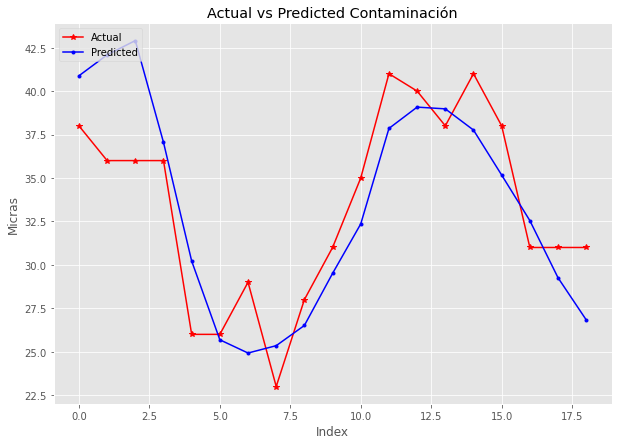

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(range(yCon_test.size), yCon_test, linestyle='-', marker='*', color='r')
plt.plot(range(ypred.size), ypred, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Contaminación')
plt.ylabel('Micras')
plt.xlabel('Index')

Veamos entonces el comportamiento del modelo con los datos de prueba.

In [ ]:
#Redes 2 capa
ypred_TRAIN=ts_model_full.predict(XCon_train_full)
ypred_TEST=ts_model_full.predict(XCon_test)

ypred_TRAIN=ypred_TRAIN[:,0]
ypred_TEST=ypred_TEST[:,0]
Redes=np.concatenate((ypred_TRAIN, ypred_TEST))

Real = np.concatenate((yCon_train_full,yCon_test))

d = {'Real': Real,  'Redes':Redes}
Todo=pd.DataFrame(data=d, index=Valores_cont.index[12:])
print(Todo)


1/1 [==============================] - 0s 14ms/step
            Real      Redes
Periodo                    
2007-12-01  69.5  68.665955
2008-01-01  64.8  76.234657
2008-02-01  71.9  77.888138
2008-03-01  73.2  72.742104
2008-04-01  65.0  67.519463
...          ...        ...
2022-02-01  41.0  36.567680
2022-03-01  38.0  33.167843
2022-04-01  31.0  29.049263
2022-05-01  31.0  26.436489
2022-06-01  31.0  25.699589

[175 rows x 2 columns]


Ahora, observemos el comportamiento general.

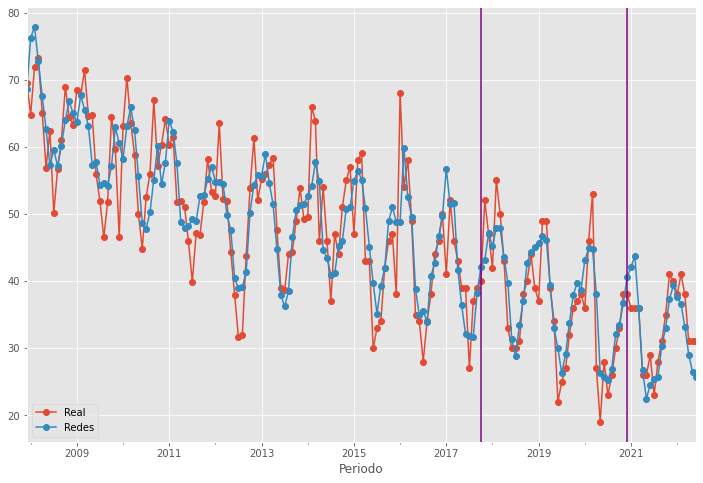

In [ ]:
ax = Todo.plot( marker="o", figsize=(12,8))
ax.axvline(x=Valores_cont.index[130].date(),color='purple')
ax.axvline(x=Valores_cont.index[168].date(),color='purple')

### Análisis Residuos

In [ ]:
difRedes=Todo['Redes']-Todo['Real']


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Gráfica de errores de predicciòn para el modelo de redes MLP')

Text(0, 0.5, 'Error')

Text(0.5, 0, 'Index')

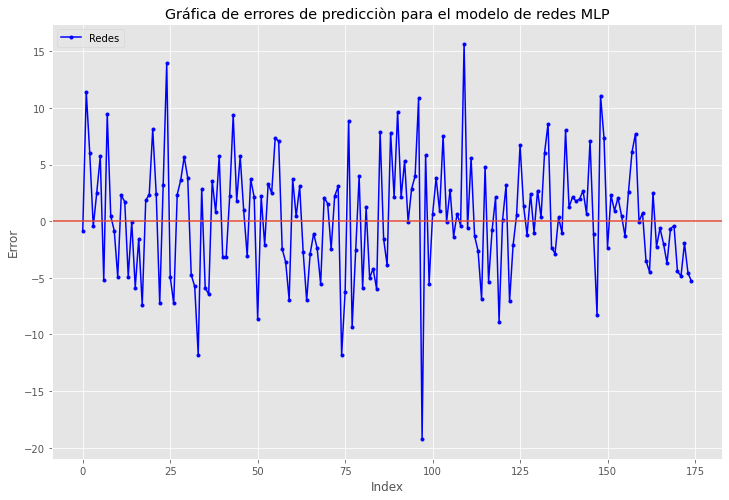

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(difRedes.size), difRedes, linestyle='-', marker='.', color='b')
plt.axhline(y=0, linestyle='-')
plt.legend(['Redes'], loc=2)
plt.title('Gráfica de errores de predicciòn para el modelo de redes MLP')
plt.ylabel('Error')
plt.xlabel('Index')

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

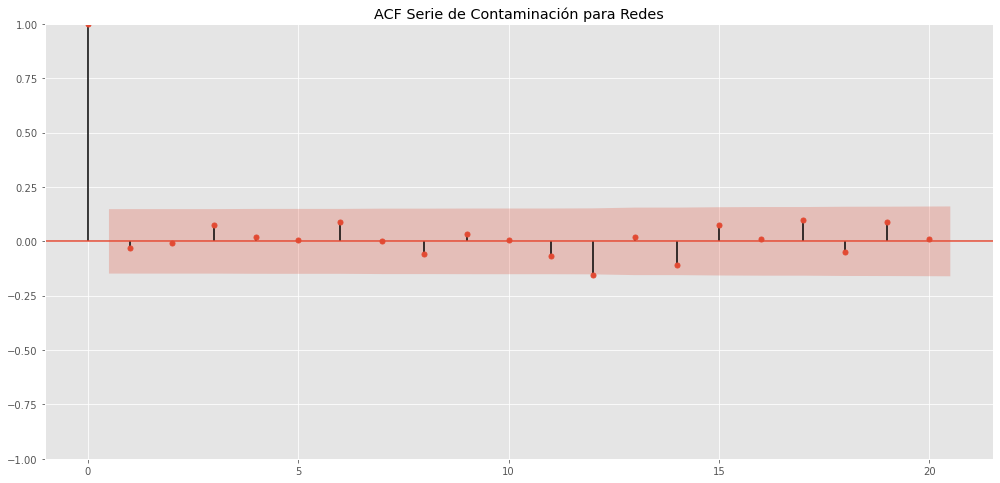

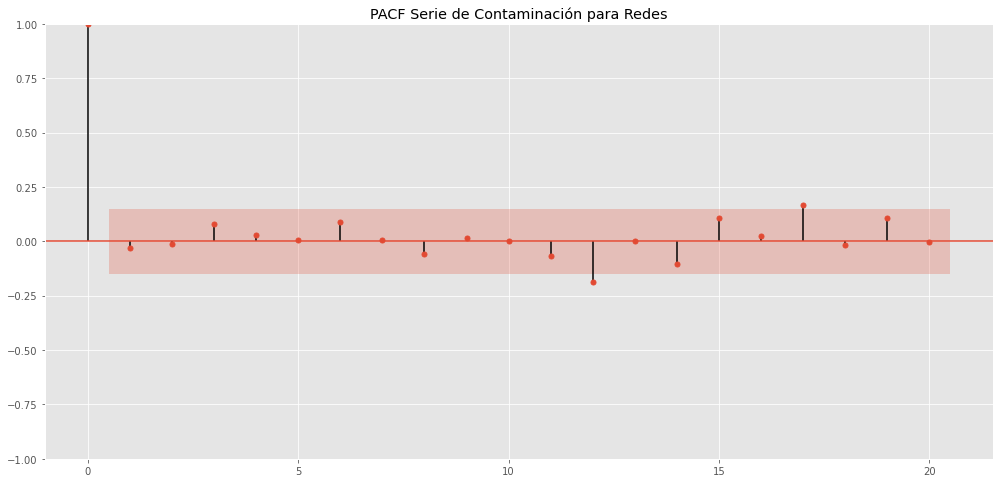

In [ ]:
plt.figure(figsize=(10, 6))
acf_red = plot_acf(difRedes,unbiased=False,lags=20,title='ACF Serie de Contaminación para Redes')
plt.show(acf_red)
pacf_red = plot_pacf(difRedes,lags=20,title='PACF Serie de Contaminación para Redes')
plt.show(pacf_red)

### ECM

In [ ]:
MseRED=np.dot(difRedes[168:],difRedes[168:])/len(difRedes[168:])

print('\n Mse para Redes:')
np.sqrt(MseRED)


 Mse para Redes:


3.7092146649228024

## LSTM

### Identificación del modelo autorregresivo usando la autocorrelación parcial
Por medio de la autocorrelación parcial se identificará el número de retardos, y la longitud de la secuencia que se necesitaran para la red recurrente.

In [ ]:
pacf = sm.tsa.stattools.pacf(Valores_cont['Valor'], nlags=30)
T = len(Valores_cont['Valor'])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 1


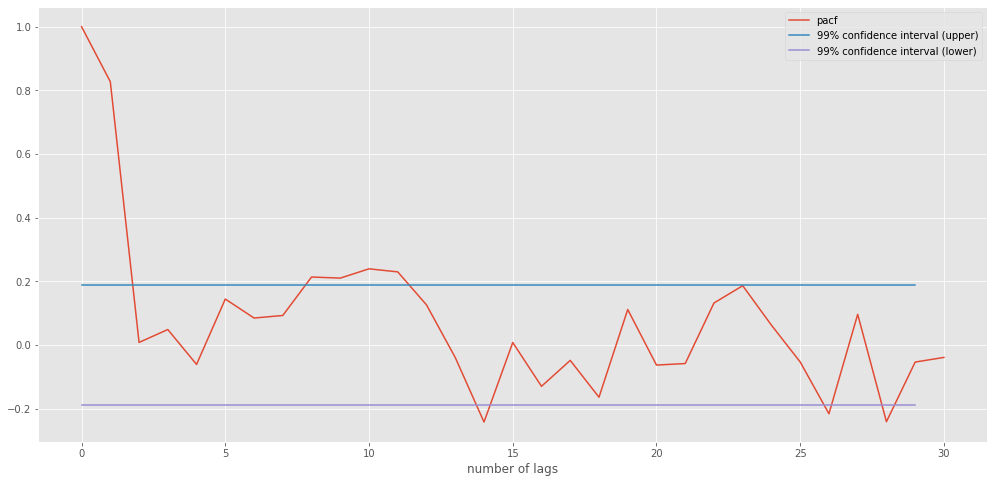

In [ ]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

In [ ]:
Con_train = Valores_cont['Valor'].iloc[:168]
Con_test = Valores_cont['Valor'].iloc[168:]
len(Con_test)

19

### **Normalización**

In [ ]:
mu = float(Con_train.mean())
sigma = float(Con_train.std())

stdize_input = lambda x: (x - mu) / sigma

Con_train = Con_train.apply(stdize_input)
Con_test = Con_test.apply(stdize_input)
len(Con_test)

19

###**Separación datos de entrenamiento y validación para predecir los datos un paso adelante**

In [ ]:
n_steps_ahead = 1
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []

    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [ ]:
x_train = get_lagged_features(Con_train, n_steps, n_steps_ahead)
y_train =  Con_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = Con_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(Con_test, n_steps, n_steps_ahead)
y_test =  Con_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = Con_test.index[n_steps + n_steps_ahead - 1:]

x_train, x_test = x_train.T, x_test.T
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(167, 1, 1), (167,), (18, 1, 1), (18,)]


###**Definición de modelos LSTM**

In [ ]:
def LSTM_(n_units = 16, l1_reg=0.0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Como la serie es de pocos datos vamos a utilizar un tamaño de 100 y un número de épocas de 10.

In [ ]:
import tensorflow.keras as keras
max_epochs = 50
batch_size = 5
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)
params = {
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 32,
        'color':'red', 'label': 'LSTM'}
}

###**Validación cruzada**
La validación cruzada es un téctina que sirve para evaluar varios modelos de redes neuronales mediante el entrenamiento de un subconjunto de datos de la serie y luego lo evalua en otro subconjunto de datos el cual es complementario al utilizado para el entrenamiento. En este caso se comparan los modelos de GRU (Gated Recurrent Unit), de LSTM (Long-Short Term Memory) y de RNN simple (un solo perceptrón.
Para saber que hiperparámetros utilizar en el modelelamiento definimos tres potencias de 2 más utilizadas en el modelamiento de redes neuronales (16, 32, 64), 4 valores para la regresión (0, 0.001, 0.01, 0.1).

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
import tensorflow as tf

In [ ]:
do_training = True
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [16, 32, 64, 128]
    l1_reg = [0, 0.001, 0.01, 0.1]

    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}

    # In the kth split, TimeSeriesSplit returns first k folds
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)

    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs,
                               batch_size=batch_size, verbose=2)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid,
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Se han truncado las últimas 5000 líneas del flujo de salida.
18/18 - 0s - loss: 0.4749 - 35ms/epoch - 2ms/step
Epoch 8/50
18/18 - 0s - loss: 0.4413 - 37ms/epoch - 2ms/step
Epoch 9/50
18/18 - 0s - loss: 0.4243 - 36ms/epoch - 2ms/step
Epoch 10/50
18/18 - 0s - loss: 0.4152 - 40ms/epoch - 2ms/step
Epoch 11/50
18/18 - 0s - loss: 0.4071 - 30ms/epoch - 2ms/step
Epoch 12/50
18/18 - 0s - loss: 0.4025 - 33ms/epoch - 2ms/step
Epoch 13/50
18/18 - 0s - loss: 0.3986 - 32ms/epoch - 2ms/step
Epoch 14/50
18/18 - 0s - loss: 0.3929 - 33ms/epoch - 2ms/step
Epoch 15/50
18/18 - 0s - loss: 0.3882 - 33ms/epoch - 2ms/step
Epoch 16/50
18/18 - 0s - loss: 0.3869 - 31ms/epoch - 2ms/step
Epoch 17/50
18/18 - 0s - loss: 0.3844 - 31ms/epoch - 2ms/step
Epoch 18/50
18/18 - 0s - loss: 0.3816 - 32ms/epoch - 2ms/step
Epoch 19/50
18/18 - 0s - loss: 0.3818 - 33ms/epoch - 2ms/step
Epoch 20/50
18/18 - 0s - loss: 0.3780 - 30ms/epoch - 2ms/step
Epoch 21/50
18/18 - 0s - loss: 0.3770 - 30ms/epoch - 2ms/step
Epoch 22/50
18/18 - 0s 

###**Entrenamiento del modelo por validación cruzada**

In [ ]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs,
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training lstm model
Epoch 1/50
34/34 [==============================] - 1s 2ms/step - loss: 0.8635
Epoch 2/50
34/34 [==============================] - 0s 2ms/step - loss: 0.8022
Epoch 3/50
34/34 [==============================] - 0s 2ms/step - loss: 0.7513
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.7014
Epoch 5/50
34/34 [==============================] - 0s 2ms/step - loss: 0.6530
Epoch 6/50
34/34 [==============================] - 0s 2ms/step - loss: 0.6066
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 0.5630
Epoch 8/50
34/34 [==============================] - 0s 2ms/step - loss: 0.5231
Epoch 9/50
34/34 [==============================] - 0s 2ms/step - loss: 0.4876
Epoch 10/50
34/34 [==============================] - 0s 2ms/step - loss: 0.4571
Epoch 11/50
34/34 [==============================] - 0s 2ms/step - loss: 0.4319
Epoch 12/50
34/34 [==============================] - 0s 3ms/step - loss: 0.4118
Epoch 13/50
34/34 [==========

In [ ]:
for key in params.keys():
    params[key]['model'].save('Contaminación-SAVED-' + key + '.hdf5', overwrite=True)

###**Predicción**

In [ ]:
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('Contaminación-SAVED-' + key + '.hdf5')

In [ ]:
for key in params.keys():
    model = params[key]['model']
    model.summary()

    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])

    params[key]['pred_test'] = model.predict(x_test, verbose=1)
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, 16)                1152      
                                                                 
 dense_172 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step


###**Rendimiento de los modelos**

In [ ]:
PredRedContaTrain=params['lstm']['pred_train']
PredRedContaTest=params['lstm']['pred_test']

In [ ]:
PredRedContaTrainST=PredRedContaTrain*sigma +mu
PredRedContaTestST=PredRedContaTest*sigma +mu

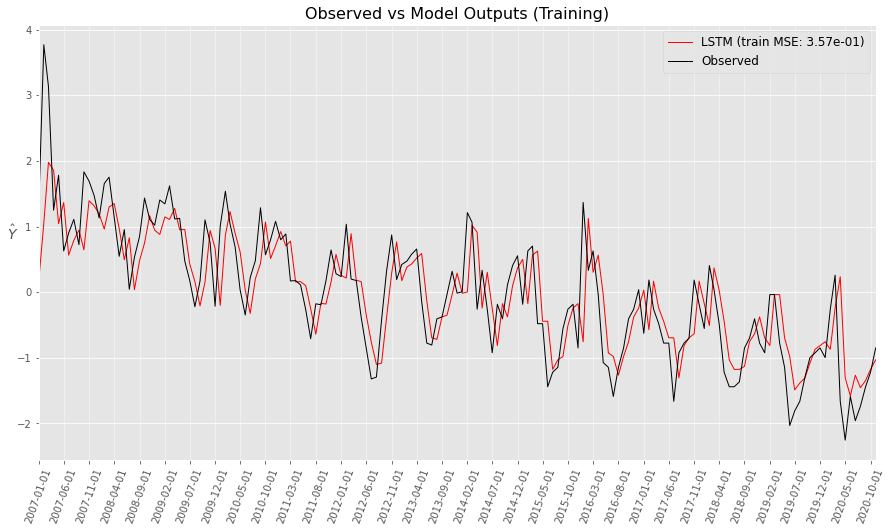

In [ ]:
from datetime import datetime
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
x_vals=x_vals[::max(1,len(x_vals)//30)]
for t in x_vals: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(x_vals, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

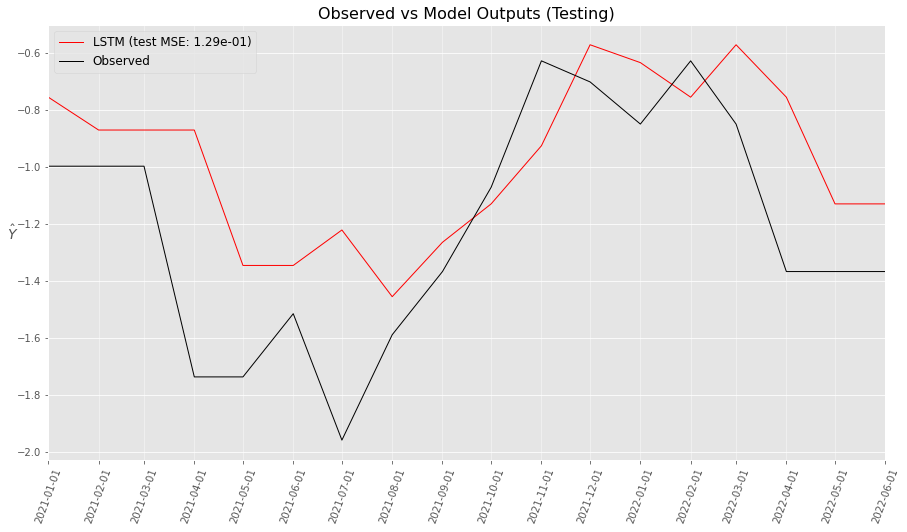

In [ ]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
x_vals=x_vals[::max(1,len(x_vals)//30)]
for t in x_vals: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(x_vals, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

In [ ]:
PredRedContaTrainST2=PredRedContaTrainST[:,0]
PredRedContaTestST2=PredRedContaTestST[:,0]

PredRedesConta=np.concatenate((PredRedContaTrainST2, PredRedContaTestST2))

### Análisis Residuos

In [ ]:
2#Redes 2 capa
Real = np.concatenate((Valores_cont['Valor'].iloc[1:168],Valores_cont['Valor'].iloc[169:]))

d2 = {'Real': Real,  'Redes LSTM':PredRedesConta}
Todo2=pd.DataFrame(data=d2)
print(Todo2)

len(PredRedesConta)
len(Real)

2

           Real  Redes LSTM
0     66.500000   51.677956
1    100.500000   63.696777
2     91.900002   76.269234
3     66.400002   74.622246
4     73.599998   63.628441
..          ...         ...
180   41.000000   39.275913
181   38.000000   41.763443
182   31.000000   39.275913
183   31.000000   34.211246
184   31.000000   34.211246

[185 rows x 2 columns]


185

185

In [ ]:
difRedLSTM=Todo2['Redes LSTM']-Todo2['Real']


<Figure size 1224x648 with 0 Axes>

Text(0.5, 1.0, 'Gráfica de errores de predicciòn para el modelo de redes MLP')

Text(0, 0.5, 'Error')

Text(0.5, 0, 'Index')

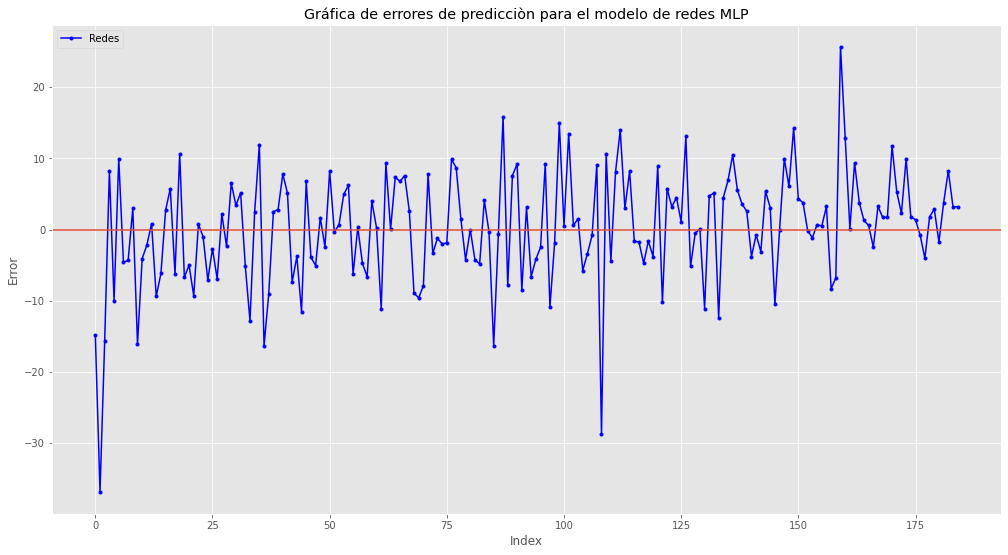

In [ ]:
plt.figure(figsize=(17, 9))
plt.plot(range(difRedLSTM.size), difRedLSTM, linestyle='-', marker='.', color='b')
plt.axhline(y=0, linestyle='-')
plt.legend(['Redes'], loc=2)
plt.title('Gráfica de errores de predicciòn para el modelo de redes MLP')
plt.ylabel('Error')
plt.xlabel('Index')

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

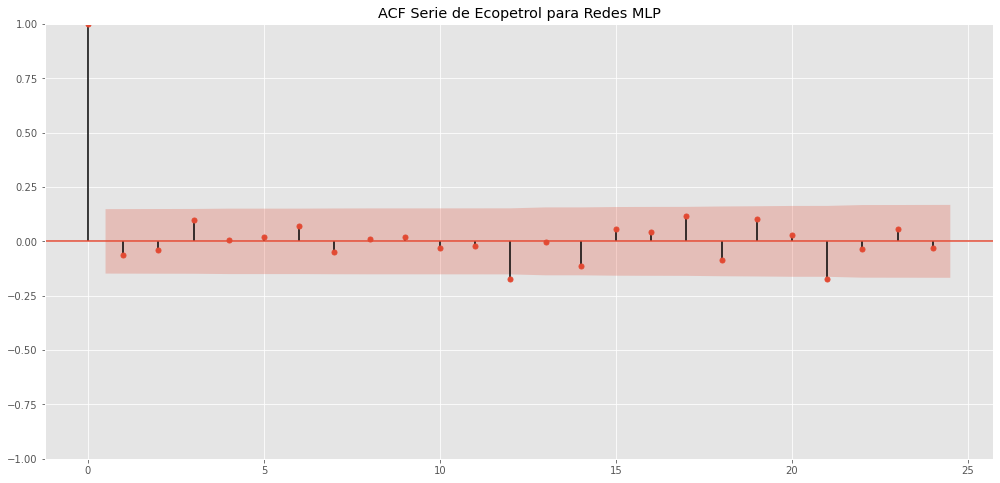

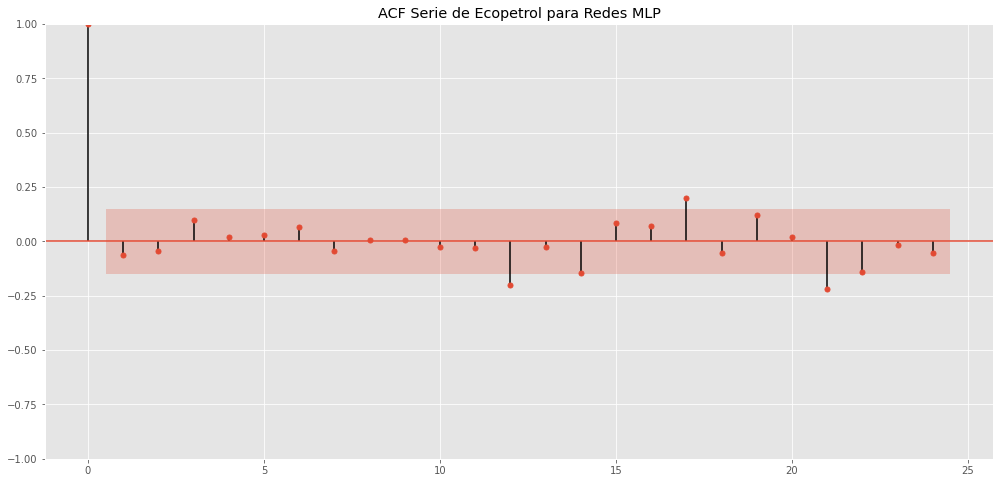

In [ ]:
plt.figure(figsize=(10, 6))
acf_red = plot_acf(difRedes,unbiased=False,lags=24,title='ACF Serie de Ecopetrol para Redes MLP')
plt.show(acf_red)
pacf_red = plot_pacf(difRedes,lags=24,title='ACF Serie de Ecopetrol para Redes MLP')
plt.show(pacf_red)

### ECM

In [ ]:
MseRED=np.dot(difRedLSTM[167:],difRedLSTM[167:])/len(difRedLSTM[167:])
#len(difRedLSTM[167:])
print('\n Mse para Redes:')
np.sqrt(MseRED)


 Mse para Redes:


4.867781983609937

## Arboles

### Eliminación de la tendencia determinística

In [ ]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn

LinearRegression()

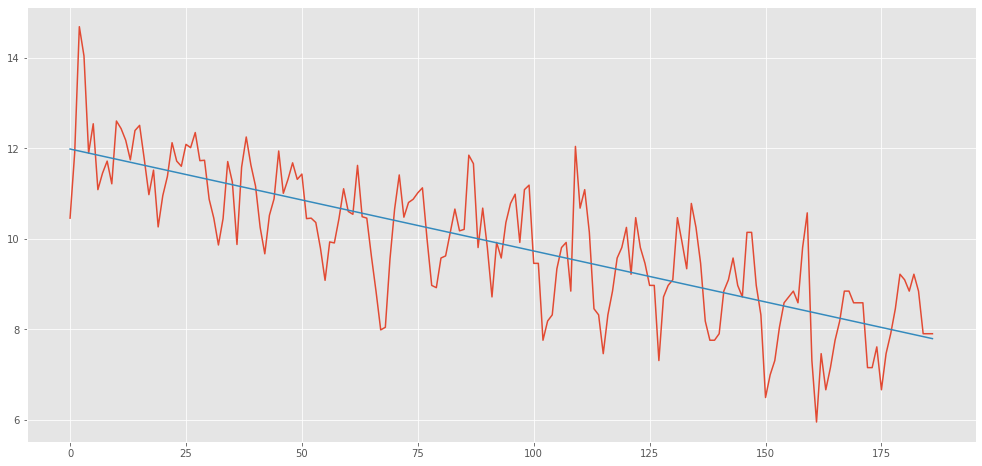

array([-0.27030881])

554.4748140293548

In [ ]:
from sklearn.linear_model import LinearRegression
X1=np.arange(2006+11/12,2022.5,1/12)
X=X1
X = np.reshape(X, (len(X), 1))
y = rContV.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()
model.coef_
model.intercept_

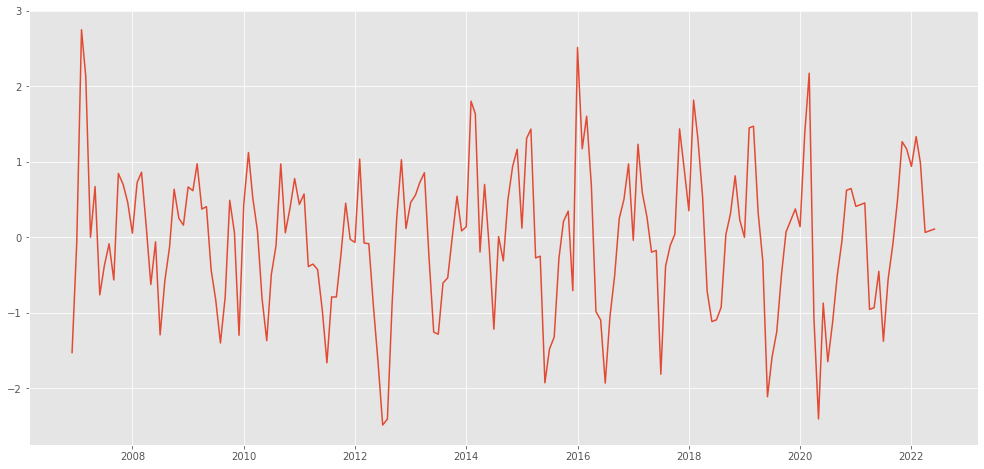

In [ ]:
Cont_sinTend = rContV.values - trend
Cont = Cont.assign(rContsinT=Cont_sinTend) # al dataframe original le añadimos los valores de la transformación

rValorST=Cont.set_index('Periodo')  # Otro dataframe con el índice de la fecha
rContST= rValorST['rContsinT']
plt.plot(rContST)
plt.show()

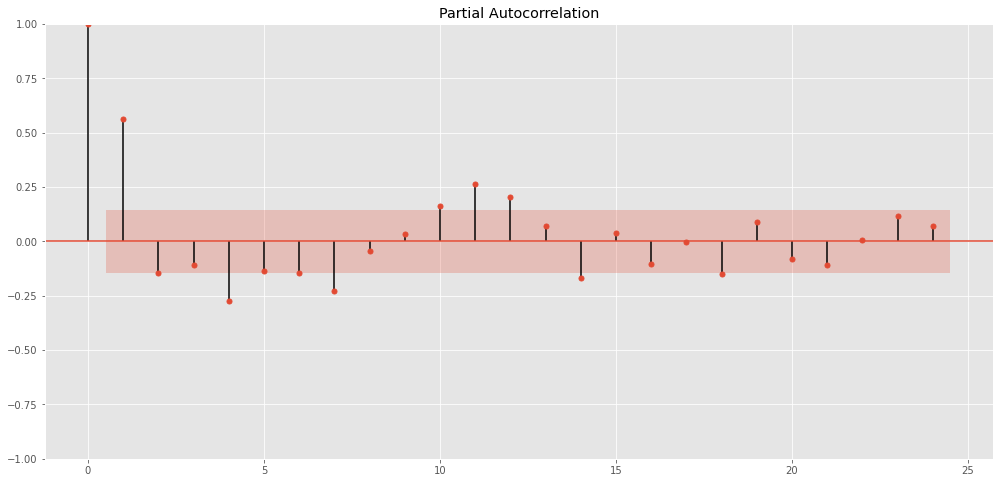

In [ ]:
pacf_=plot_pacf(rContST,lags=24,method='ldbiased')

###Creación de variables rezagadas

In [ ]:
from pandas import DataFrame
df1 = DataFrame()

# incluir los retardos que van a explicar el tiempo t
for i in range(12,0,-1):
    df1['t-'+str(i)] = rContST.shift(i)

# añadir el tiempo t
df1['t'] = rContST.values

print(df1)

# eliminar los valores NA
df1_cont = df1[12:]

print(df1_cont)

                t-12      t-11      t-10       t-9       t-8       t-7  \
Periodo                                                                  
2006-12-01       NaN       NaN       NaN       NaN       NaN       NaN   
2007-01-01       NaN       NaN       NaN       NaN       NaN       NaN   
2007-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2007-03-01       NaN       NaN       NaN       NaN       NaN       NaN   
2007-04-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-02-01  0.431464  0.453990 -0.955962 -0.933436 -0.452546 -1.377832   
2022-03-01  0.453990 -0.955962 -0.933436 -0.452546 -1.377832 -0.557160   
2022-04-01 -0.955962 -0.933436 -0.452546 -1.377832 -0.557160 -0.094182   
2022-05-01 -0.933436 -0.452546 -1.377832 -0.557160 -0.094182  0.479531   
2022-06-01 -0.452546 -1.377832 -0.557160 -0.094182  0.479531  1.265568   

                 t-6       t-5       

### Dividir los datos

In [ ]:
# Split data

PM25split = df1_cont.values
# split into lagged variables and original time series
X_PM25 = PM25split[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y_PM25 = PM25split[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [ ]:
train_size = int(118)
train_target = y_PM25[0:train_size]
valid_target = y_PM25[train_size:156]
test_target = y_PM25[156:len(y_PM25)]

# regresoras
train_feature = X_PM25[0:train_size]
valid_feature = X_PM25[train_size:156]
test_feature = X_PM25[156:len(y_PM25)]

print('Observaciones respuesta: %d' % (len(y_PM25)))
print('Tamaño respuestas de entrenamiento: %d' % (len(train_target)))
print('Tamaño respuestas de validación: %d' % (len(valid_target)))
print('Tamaño respuestas de prueba: %d' % (len(test_target)))

print('Observaciones covariables: %d' % (len(X_PM25)))
print('Tamaño covariables de entrenamiento: %d' % (len(train_feature)))
print('Tamaño covariables de validación: %d' % (len(valid_feature)))
print('Tamaño covariables de prueba: %d' % (len(test_feature)))

Observaciones respuesta: 175
Tamaño respuestas de entrenamiento: 118
Tamaño respuestas de validación: 38
Tamaño respuestas de prueba: 19
Observaciones covariables: 175
Tamaño covariables de entrenamiento: 118
Tamaño covariables de validación: 38
Tamaño covariables de prueba: 19


### Decisión profundidad del árbol

In [ ]:
# Decision Tree Regresion Model
from sklearn.tree import DecisionTreeRegressor

# Find the best Max Depth

# Loop through a few different max depths and check the performance
# Try different max depths. We want to optimize our ML models to make the best predictions possible.
# For regular decision trees, max_depth, which is a hyperparameter, limits the number of splits in a tree.
# You can find the best value of max_depth based on the R-squared score of the model on the test set.


for d in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
    # Create the tree and fit it
    decision_tree_PM25 = DecisionTreeRegressor(max_depth=d, random_state=123)
    decision_tree_PM25.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_PM25.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_PM25.score(test_feature, test_target))  # You want the test score to be positive and high
    print("el ECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_PM25.predict(valid_feature),valid_target, squared=False), "\n")

DecisionTreeRegressor(max_depth=2, random_state=123)

max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.4627057579787818
Coeficiente R2 sobre el conjunto de validación: 0.47479227218111486
el ECM sobre el conjunto de validación es: 0.705138650261206 



DecisionTreeRegressor(max_depth=3, random_state=123)

max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.6122789147084373
Coeficiente R2 sobre el conjunto de validación: 0.27127336451470485
el ECM sobre el conjunto de validación es: 0.8283216441465101 



DecisionTreeRegressor(max_depth=4, random_state=123)

max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7299348834574582
Coeficiente R2 sobre el conjunto de validación: 0.10776255291146208
el ECM sobre el conjunto de validación es: 0.8650093094866041 



DecisionTreeRegressor(max_depth=5, random_state=123)

max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8090163119019955
Coeficiente R2 sobre el conjunto de validación: -0.025619941867553342
el ECM sobre el conjunto de validación es: 0.7931147433232523 



DecisionTreeRegressor(max_depth=6, random_state=123)

max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.8704302632706327
Coeficiente R2 sobre el conjunto de validación: 0.07284942722428722
el ECM sobre el conjunto de validación es: 0.932488348881518 



DecisionTreeRegressor(max_depth=7, random_state=123)

max_depth= 7
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9281893539217972
Coeficiente R2 sobre el conjunto de validación: -0.0593202737384988
el ECM sobre el conjunto de validación es: 0.9718464703858973 



DecisionTreeRegressor(max_depth=8, random_state=123)

max_depth= 8
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9751763571091508
Coeficiente R2 sobre el conjunto de validación: 0.2327009025341773
el ECM sobre el conjunto de validación es: 1.0064537590137064 



DecisionTreeRegressor(max_depth=9, random_state=123)

max_depth= 9
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9931657686979646
Coeficiente R2 sobre el conjunto de validación: -0.24141545051031343
el ECM sobre el conjunto de validación es: 0.9398361677467341 



DecisionTreeRegressor(max_depth=10, random_state=123)

max_depth= 10
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9988695610354631
Coeficiente R2 sobre el conjunto de validación: -0.08814471342312347
el ECM sobre el conjunto de validación es: 0.9688534487733308 



DecisionTreeRegressor(max_depth=11, random_state=123)

max_depth= 11
Coeficiente R2 sobre el conjunto de entrenamiento: 0.9999152733970308
Coeficiente R2 sobre el conjunto de validación: -0.004485485981710946
el ECM sobre el conjunto de validación es: 0.9762235645649444 



### Predicciones en el conjunto de prueba

DecisionTreeRegressor(max_depth=2, random_state=123)

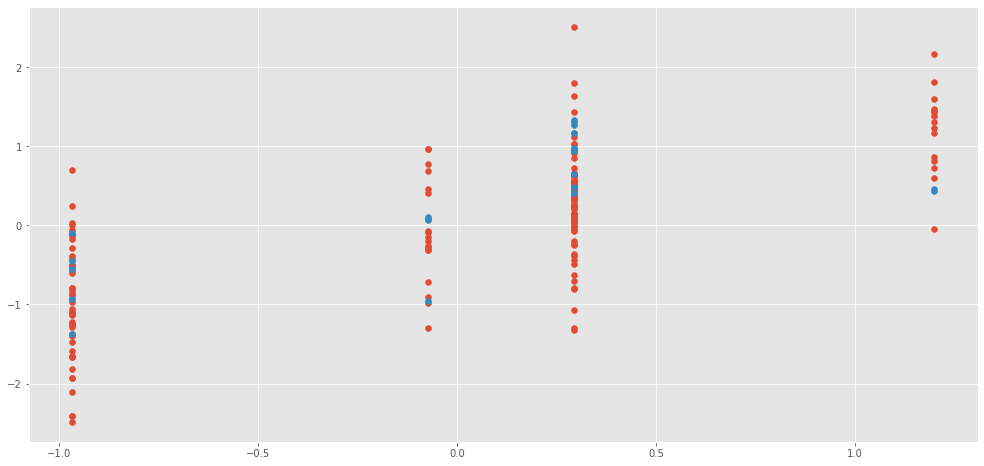

In [ ]:
# Plot predicted against actual values

from matplotlib import pyplot as plt

train_size2=156
train_target2 = y_PM25[0:train_size2]
train_feature2 = X_PM25[0:train_size2]

# Usando la mayor profundidad
decision_tree_f = DecisionTreeRegressor(max_depth=2, random_state=123)
decision_tree_f.fit(train_feature2, train_target2)

# Predicciones para el conjunto de entrenamiento y prueba
train_prediction = decision_tree_f.predict(train_feature2)
test_prediction = decision_tree_f.predict(test_feature)

# Valores reales vs Predicciones
plt.scatter(train_prediction, train_target2, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()

|--- feature_0 <= -0.09
|   |--- feature_11 <= -0.13
|   |   |--- value: [-0.97]
|   |--- feature_11 >  -0.13
|   |   |--- value: [-0.07]
|--- feature_0 >  -0.09
|   |--- feature_0 <= 1.17
|   |   |--- value: [0.29]
|   |--- feature_0 >  1.17
|   |   |--- value: [1.20]



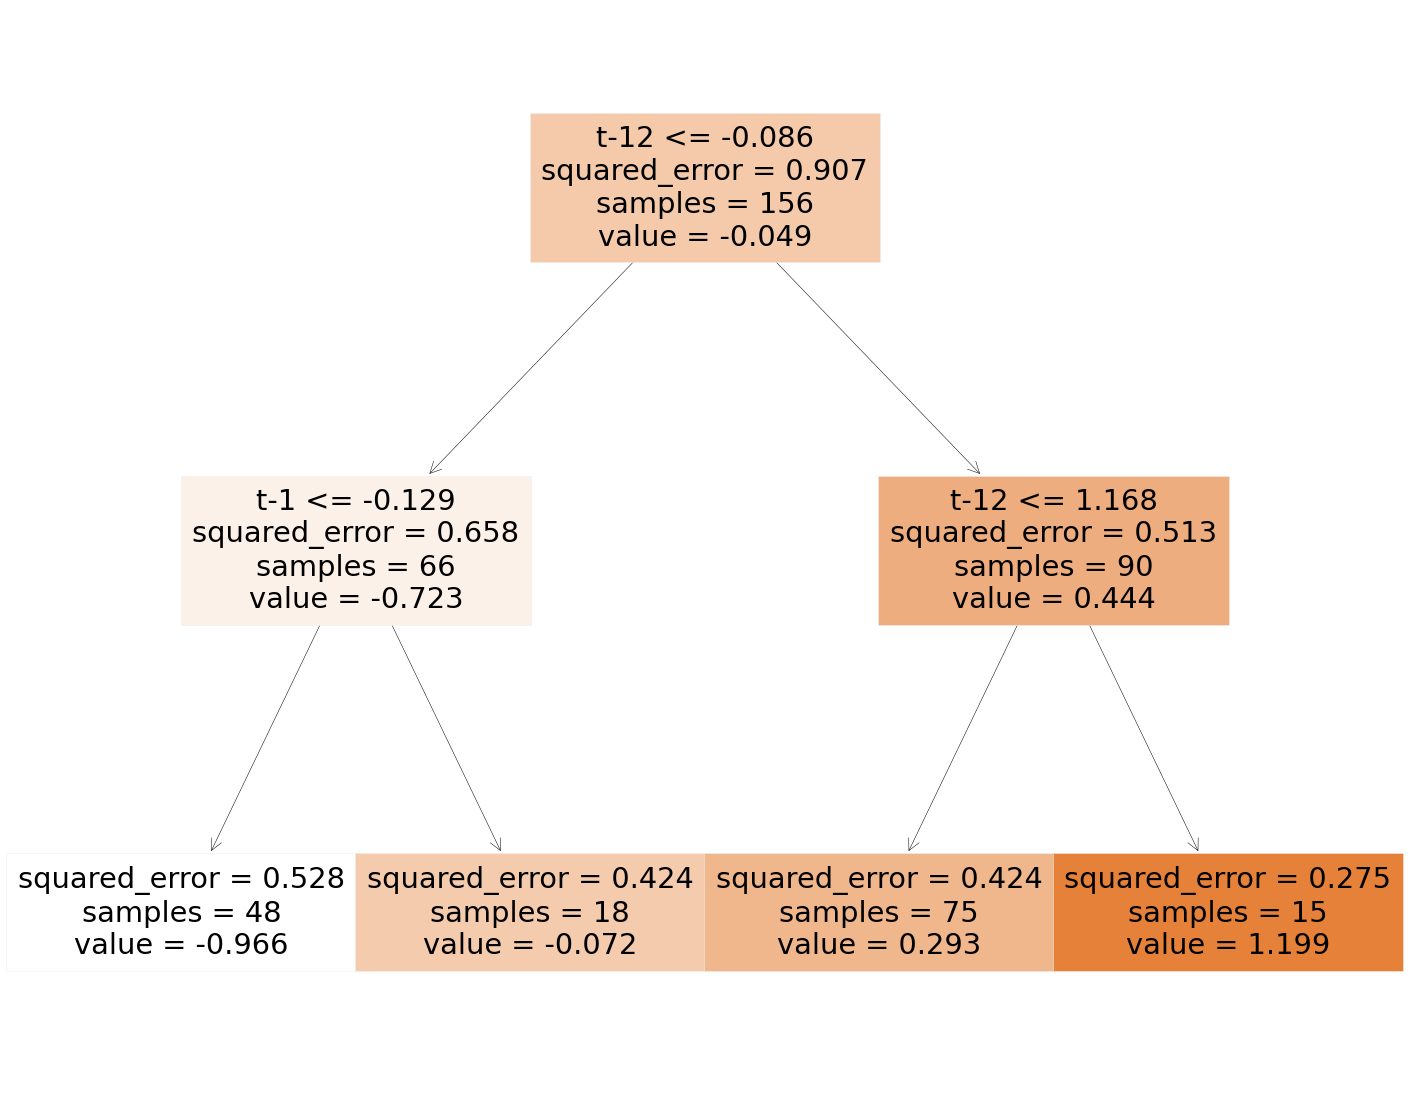

In [ ]:
from sklearn import tree

listacaract=list(df1_cont.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_f)
print(text_representation)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_f,
                   feature_names=listacaract,
                   class_names=respuesta,
                   filled=True)

     Prediccion  Original
0     -0.072304  0.464059
1      0.293375  0.053830
2      1.198792  0.723700
3      1.198792  0.860769
4      0.293375  0.140179
..          ...       ...
151   -0.966325 -1.648140
152   -0.966325 -1.136168
153   -0.966325 -0.508510
154    0.293375 -0.061633
155    0.293375  0.622058

[156 rows x 2 columns]


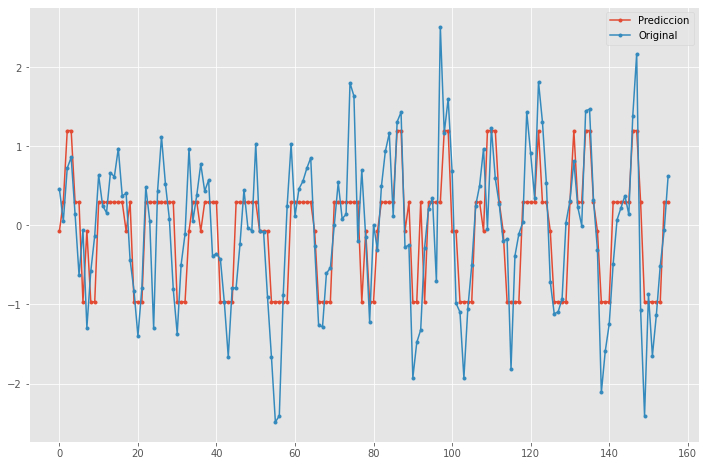

In [ ]:
Plot_predic = {'Prediccion' : train_prediction, 'Original' : train_target2}
Todo=pd.DataFrame(data=Plot_predic)
print(Todo)

ax = Todo.plot( marker=".", figsize=(12,8))

### ECM sobre original

In [ ]:
from scipy.special import boxcox, inv_boxcox

test_p_reg = trend[168:187] + test_prediction
test_target_reg = trend[168:187] + test_target

test_p_orig = inv_boxcox(test_p_reg, 0.433)
test_target_orig = inv_boxcox(test_target_reg, 0.433)

Resid_arb=test_p_orig - test_target_orig
print("ECM en el conjunto de prueba: ", np.sqrt(sum(Resid_arb**2)))

ECM en el conjunto de prueba:  19.928140941246404


In [ ]:
pred = np.concatenate((train_prediction, test_prediction))
pred_reg = trend[12:187] + pred
pred_orig = inv_boxcox(pred_reg, 0.433)

target = np.concatenate((train_target2, test_target))
target_reg = trend[12:187] + target
target_orig = inv_boxcox(target_reg, 0.433)

Plot_predic = {'Prediccion' : pred_orig, 'Original' : target_orig}
Todo=pd.DataFrame(data=Plot_predic, index=df1_cont.index)
print(Todo)

            Prediccion  Original
Periodo                         
2007-12-01   63.702358      69.5
2008-01-01   67.378554      64.8
2008-02-01   77.378519      71.9
2008-03-01   77.113605      73.2
2008-04-01   66.645347      65.0
...                ...       ...
2022-02-01   32.960780      41.0
2022-03-01   32.797560      38.0
2022-04-01   30.056554      31.0
2022-05-01   29.901660      31.0
2022-06-01   29.747220      31.0

[175 rows x 2 columns]


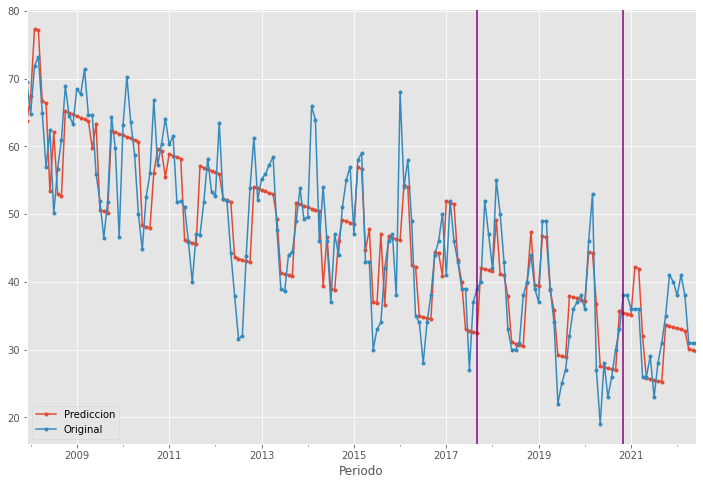

In [ ]:
ax = Todo.plot( marker=".", figsize=(12,8))
ax.axvline(x=cont_ts.index[129].date(),color='purple')
ax.axvline(x=cont_ts.index[167].date(),color='purple')

### Análisis de residuales

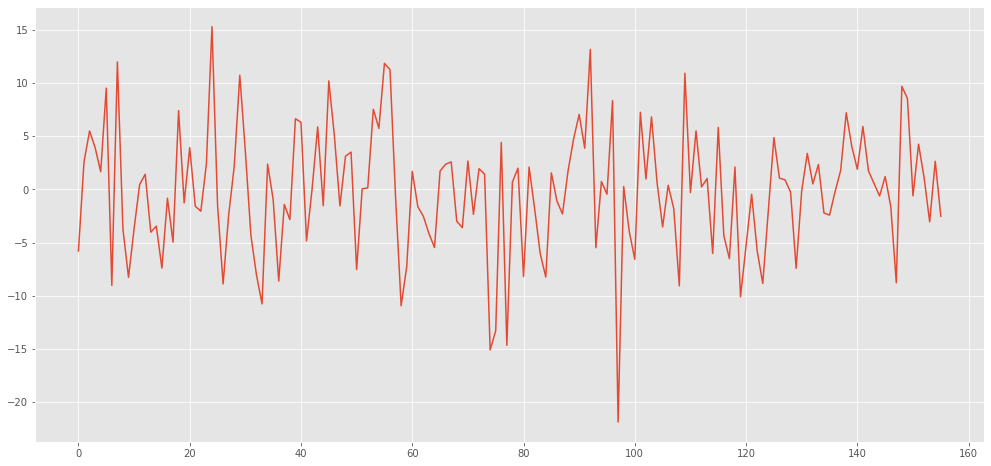

In [ ]:
train_p_reg = trend[12:168] + train_prediction
train_target_reg = trend[12:168] + train_target2

train_p_orig = inv_boxcox(train_p_reg, 0.433)
train_target_orig = inv_boxcox(train_target_reg, 0.433)

Resid_arb2=train_p_orig - train_target_orig
plt.plot(Resid_arb2)

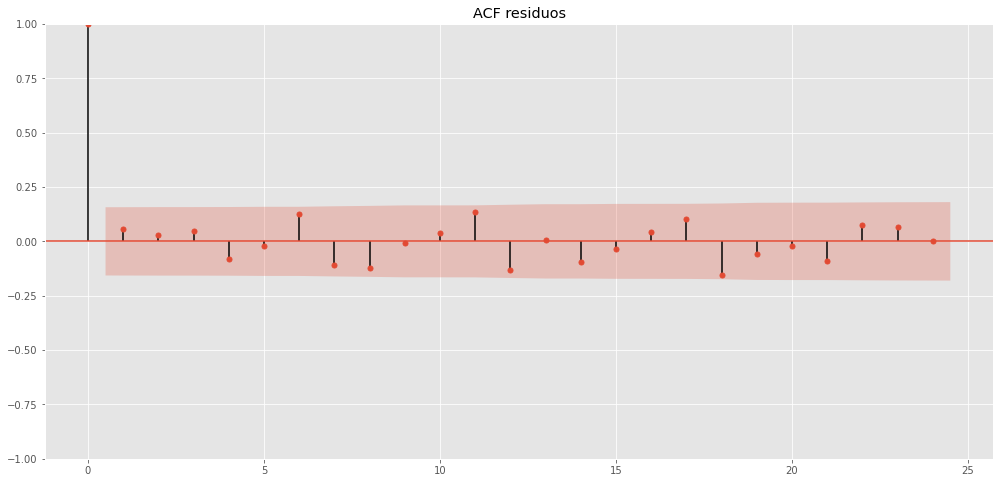

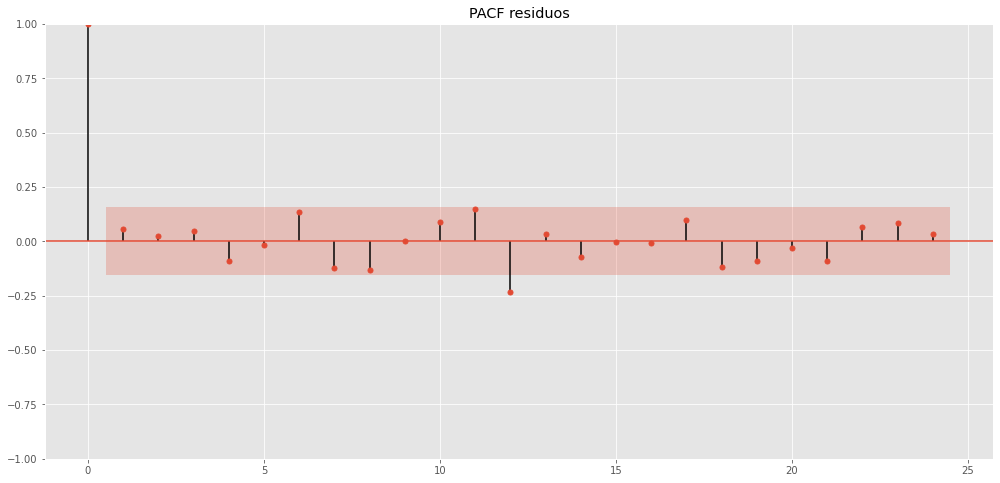

In [ ]:
acf_res2 = plot_acf(Resid_arb2,unbiased=False,lags=24,title='ACF residuos')
plt.show(acf_res2)
pacf_res2 = plot_pacf(Resid_arb2,lags=24,title='PACF residuos')
plt.show(pacf_res2)

### ECM

In [ ]:
MseRED=np.dot(difRedLSTM[167:],difRedLSTM[167:])/len(difRedLSTM[167:])
#len(difRedLSTM[167:])
print('\n Mse para Redes:')
np.sqrt(MseRED)


 Mse para Redes:


4.867781983609937

# Pronósticos finales

## Re ajuste del modelo final

In [ ]:
modelo_FINAL = sm.tsa.statespace.SARIMAX(rContV, trend='n', order=(0,1,1), seasonal_order=(3,1,0,12), enforce_invertibility=False, exog=regresoras)
results_FINAL = modelo_FINAL.fit(use_boxcox=False)
print(results_FINAL.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               rCont   No. Observations:                  187
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 12)   Log Likelihood                -142.899
Date:                             Thu, 01 Dec 2022   AIC                            309.798
Time:                                     15:48:07   BIC                            347.706
Sample:                                 12-01-2006   HQIC                           325.176
                                      - 06-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7453      1.081      1.614      0.107      -0.374       3.865
x2            -1.5352      

## Pronósticos

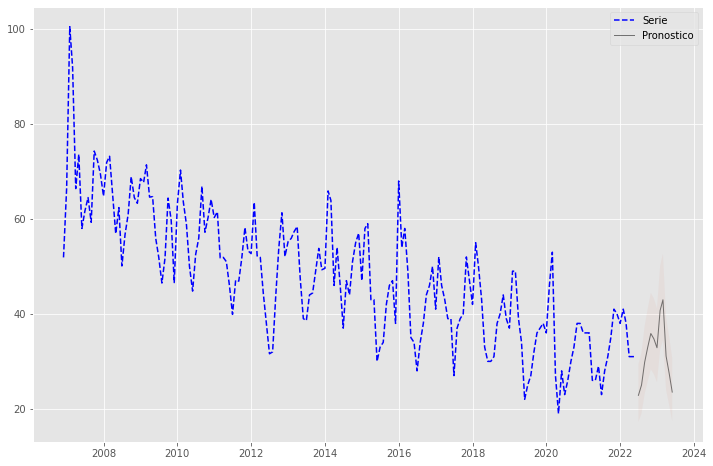

In [ ]:
#sp.special.inv_boxcox(logAirPass,lmbda=0)
####Etapa de pronósticos
reg=np.array([[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],
              [0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0],[0,0,0,0,1,0,0]])
pronosticos=results_FINAL.forecast(steps=12, exog=reg)


salforecastotro=results_FINAL.get_forecast(steps=12, exog=reg)
ICforecast95=salforecastotro.conf_int(alpha=0.05)
pronosticos=salforecastotro.predicted_mean

###Reescalar#####
pronosticos_inboxcox=sp.special.inv_boxcox(np.array(pronosticos[0:]),0.433)
ICinfforecast95_invbox=sp.special.inv_boxcox(np.array(ICforecast95.iloc[:,0]),0.433)
ICsupforecast95_invbox=sp.special.inv_boxcox(np.array(ICforecast95.iloc[:,1]),0.433)
pronosticos_inboxcox=pd.Series(pronosticos_inboxcox,index=pronosticos.index)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#Serie actual
ax.plot(cont_ts.astype('float64'), '--', color="blue", label='Serie')
# Pronóstico
ax.plot(pronosticos_inboxcox, lw=1, color="black", alpha=0.5, label='Pronostico')
ax.fill_between(pronosticos.index, ICinfforecast95_invbox, ICsupforecast95_invbox, alpha=0.05)
ax.legend(loc='upper right')
plt.draw()